In [78]:
import pickle
import xarray as xr
import cartopy as cp
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd

import cartopy
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.patches import Rectangle
import cmocean as cm

from scipy import interpolate

https://nbviewer.org/github/tjarnikova/NanooseObs/blob/main/observationalClimatologyandTrends.ipynb
last updated from TJ's script above March 23 2023

TJ notes 

objective:

process raw time-series of Nanoose observational data, bin into bi-weekly timeperiods (24 per year, 1st and second half of each month), derive climatology, ascertain any trend from 1979-2022.

    here I open data and visualize raw, uninterpolated data (time and depths, coloured by temperature)

    note that there are some spurious obs below 400 meters.

Following communication (2023-03-22) with GO, we are disregarding observations below 400m.

In [79]:
obs_ctd = glob.glob('D:/Sync/For_TJ/nanoose_prepped_2023-02-13/prepped_pyapnames/CTD/*.nc')
test_ctd = obs_ctd[0:20]
obs = xr.open_dataset(test_ctd[0])

obs

<xarray.Dataset>
Dimensions:      (pressure: 264, single: 1)
Dimensions without coordinates: pressure, single
Data variables:
    Pres         (pressure) float32 ...
    temperature  (pressure) float64 ...
    cTemp        (pressure) float64 ...
    salinity     (pressure) float64 ...
    aSal         (pressure) float64 ...
    pDen         (pressure) float64 ...
    time         (single) datetime64[ns] ...
    depth        (single) float32 ...
    latitude     (single) float32 ...
    longitude    (single) float32 ...

0
1000
2000
3000
4000
5000


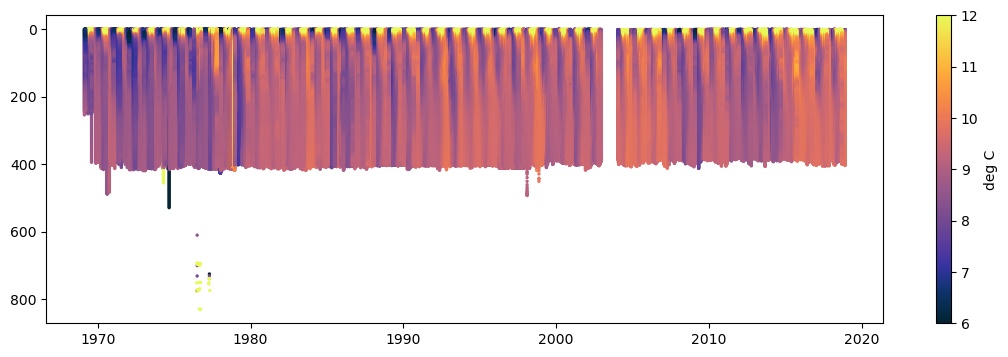

In [4]:
scat = True

if scat:

    fact = 0.5
    fig, axs = plt.subplots(1,1, figsize=(27*fact, 8*fact), facecolor='w', edgecolor='k')

    # with open('./sampleda./ForTereza/prepped_pyapnames/11-03-08_2014h.pickle', 'rb') as pickle_file:
    #     model = pickle.load(pickle_file)
    bad_ctds = []
    for i in range(0, len(obs_ctd)):
        if i%1000 == 0:
            print(i)
        try:
            obs = xr.open_dataset(obs_ctd[i])
            ttime = (obs['time'].values)
            tobs = len(obs['Pres'].values)
            t = np.empty(tobs, dtype='datetime64[s]')
            t[:] = ttime[0]
            w =axs.scatter(t, obs['Pres'].values, c = obs['cTemp'].values, s = 2, vmin = 6, vmax = 12, cmap = cm.cm.thermal)

        except:
            bad_ctds.append(obs_ctd[i])

    plt.colorbar(w, label = 'deg C')
    axs.invert_yaxis()

    fig.savefig('raw_ctd_nanoose.jpg')


raw timeseries of temperature alt text

    sort ctd names by date, for processing

In [80]:
ctd_bydate = []
for i in range(0,len(obs_ctd)):
    my_string = obs_ctd[i]
    datestr = (my_string.split("CTD_",1)[1]) #get the stuff after CTD
    ctd_bydate.append(datestr)
    
ctd_bydate.sort()
print('first 10 date substrings from ctd file names,  to check if sorting worked')
print(ctd_bydate[0:10])

first 10 date substrings from ctd file names,  to check if sorting worked
['1969-02-11_1835h.nc', '1969-02-11_2010h.nc', '1969-02-28_1725h.nc', '1969-02-28_2000h.nc', '1969-03-03_1725h.nc', '1969-03-06_1713h.nc', '1969-03-07_1720h.nc', '1969-03-10_0000h.nc', '1969-03-13_1740h.nc', '1969-03-17_1800h.nc']


In [81]:
tmodel = xr.open_dataset('D:/Sync/For_TJ/SalishSea1500-RUN203_1h_grid_T_y1990m04_clipped.nc')
mod_depth = tmodel['deptht']

modd_um = np.zeros(40)
for i in range(0,40):

    modd_um[i] = mod_depth[i]
    
modd_um

array([  0.5000003 ,   1.5000031 ,   2.50001144,   3.50003052,
         4.50007057,   5.50015068,   6.50031042,   7.50062323,
         8.50123596,   9.50243282,  10.50476551,  11.50931168,
        12.51816654,  13.53541183,  14.56898212,  15.63428783,
        16.76117325,  18.00713539,  19.48178482,  21.38997841,
        24.10025597,  28.22991562,  34.68575668,  44.51772308,
        58.48433304,  76.58558655,  98.06295776, 121.86651611,
       147.08946228, 173.11448669, 199.57304382, 226.26029968,
       253.06663513, 279.93453979, 306.834198  , 333.75018311,
       360.67453003, 387.60321045, 414.53408813, 441.46609497])



    write a function that will interpolate t and s to model depths and test it

    if verbose == True here, it prints out pictures to show what it's doing

    do this interpolation for every CTD, and save in a pickle array along with the dates



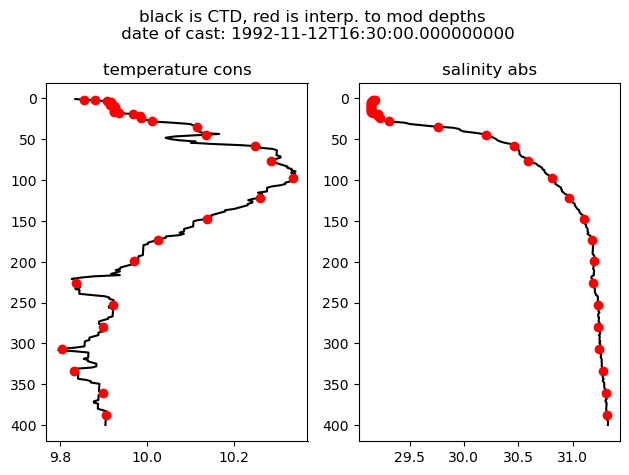

In [82]:
def get_model_interpolated(ncname, verbose = True):

    tobs = xr.open_dataset(ncname)
    obs_d = tobs['Pres'].values
    obs_t = tobs['cTemp'].values
    obs_s = tobs['aSal'].values
    ttime = tobs['time'][0].values
    
    #throw out stuff below 400
    filt = obs_d > 400
    obs_d[filt] = np.nan
    obs_t[filt] = np.nan
    obs_s[filt] = np.nan
    
    try:
        f = interpolate.interp1d(obs_d, obs_t) #temperature
        f2 = interpolate.interp1d(obs_d, obs_s) #salinity

        ## can only interpolate to model points that are within observations 
        mod_d = modd_um[(modd_um<max(obs_d)) & (modd_um>min(obs_d))]
        firstind = np.where(modd_um == np.min(mod_d))[0][0] ## first model index we were able to interpolate to 
        interp_t = f(mod_d)   # use interpolation function returned by `interp1d`
        interp_s = f2(mod_d)

        ### 
        t_full = np.zeros(40)
        t_full[:] = -999
        t_full[firstind:firstind+len(mod_d)] = interp_t
        t_full[t_full < -900] = np.nan

        s_full = np.zeros(40)
        s_full[:] = -999
        s_full[firstind:firstind+len(mod_d)] = interp_s
        s_full[s_full < -900] = np.nan



        if verbose:
            fig, axs =  plt.subplots(1,2)
            axs = axs.ravel()
            axs[0].plot(obs_t, obs_d, 'k-', interp_t, mod_d, 'or')
            axs[1].plot(obs_s, obs_d, 'k-', interp_s, mod_d, 'or')
            axs[0].set_title('temperature cons')
            axs[1].set_title('salinity abs')
            axs[0].invert_yaxis()
            axs[1].invert_yaxis()

            fig.suptitle(f'black is CTD, red is interp. to mod depths \n date of cast: {ttime}')
            plt.tight_layout()
            plt.show()
    except:
               
        t_full = np.zeros(40)
        t_full[:] = -999
        t_full[t_full < -900] = np.nan
        s_full = np.zeros(40)
        s_full[:] = -999
        s_full[s_full < -900] = np.nan
        
    return t_full, s_full, ttime


t_full, s_full, ttime  = get_model_interpolated(obs_ctd[300])

In [83]:
extract = True
if extract:
    time_array = np.empty(len(ctd_bydate), dtype='datetime64[s]')
    salt_array = np.zeros([len(ctd_bydate), 40])
    temp_array = np.zeros([len(ctd_bydate), 40])

    for i in range(0,len(ctd_bydate)):
        print(f'{i}, {ctd_bydate[i]}')
        tstr = glob.glob(f'D:/Sync/For_TJ/nanoose_prepped_2023-02-13/prepped_pyapnames/CTD/*{ctd_bydate[i]}')[0]
        t_full, s_full, ttime  = get_model_interpolated(tstr, verbose = False)

        salt_array[i,:] = s_full
        temp_array[i,:] = t_full
        time_array[i] = ttime

        pickle.dump(salt_array, open("D:/temp_nemo/CTD-salt_array.pkl", 'wb'))
        pickle.dump(temp_array, open("D:/temp_nemo/CTD-temp_array.pkl", 'wb'))
        pickle.dump(time_array, open("D:/temp_nemo/CTD-time_array.pkl", 'wb'))

#t_full, s_full, ttime  = get_model_interpolated(obs_ctd[i])

0, 1969-02-11_1835h.nc
1, 1969-02-11_2010h.nc
2, 1969-02-28_1725h.nc
3, 1969-02-28_2000h.nc
4, 1969-03-03_1725h.nc
5, 1969-03-06_1713h.nc
6, 1969-03-07_1720h.nc
7, 1969-03-10_0000h.nc
8, 1969-03-13_1740h.nc
9, 1969-03-17_1800h.nc
10, 1969-03-17_2345h.nc
11, 1969-03-18_1855h.nc
12, 1969-03-18_2025h.nc
13, 1969-03-19_1712h.nc
14, 1969-03-24_2035h.nc
15, 1969-03-26_0000h.nc
16, 1969-03-26_1938h.nc
17, 1969-03-27_1705h.nc
18, 1969-03-27_1803h.nc
19, 1969-03-27_1856h.nc
20, 1969-03-28_1511h.nc
21, 1969-03-28_1541h.nc
22, 1969-03-28_1616h.nc
23, 1969-04-02_2005h.nc
24, 1969-04-07_0000h.nc
25, 1969-04-07_0000h.nc
26, 1969-04-07_0000h.nc
27, 1969-04-08_1710h.nc
28, 1969-04-09_0000h.nc
29, 1969-04-09_0000h.nc
30, 1969-04-09_0000h.nc
31, 1969-04-10_1455h.nc
32, 1969-04-12_1850h.nc
33, 1969-04-15_1445h.nc
34, 1969-04-17_1735h.nc
35, 1969-04-18_0000h.nc
36, 1969-04-22_1704h.nc
37, 1969-04-23_1700h.nc
38, 1969-04-24_1740h.nc
39, 1969-04-26_0000h.nc
40, 1969-04-29_2145h.nc
41, 1969-04-30_1630h.nc
42

338, 1970-11-04_1725h.nc
339, 1970-11-09_1740h.nc
340, 1970-11-09_2155h.nc
341, 1970-11-12_1655h.nc
342, 1970-11-13_1905h.nc
343, 1970-11-16_1750h.nc
344, 1970-11-17_1720h.nc
345, 1970-11-18_1745h.nc
346, 1970-11-21_0325h.nc
347, 1970-11-24_2300h.nc
348, 1970-11-25_2250h.nc
349, 1970-11-26_2205h.nc
350, 1970-11-27_1745h.nc
351, 1970-12-01_2155h.nc
352, 1970-12-02_1815h.nc
353, 1970-12-03_2010h.nc
354, 1970-12-04_1745h.nc
355, 1970-12-04_2000h.nc
356, 1970-12-08_1830h.nc
357, 1970-12-09_1530h.nc
358, 1970-12-11_1830h.nc
359, 1970-12-17_2030h.nc
360, 1970-12-18_1815h.nc
361, 1970-12-29_1810h.nc
362, 1970-12-30_0035h.nc
363, 1970-12-30_1750h.nc
364, 1971-01-04_2020h.nc
365, 1971-01-05_1945h.nc
366, 1971-01-06_1830h.nc
367, 1971-01-06_2315h.nc
368, 1971-01-14_1945h.nc
369, 1971-01-14_2325h.nc
370, 1971-01-16_1850h.nc
371, 1971-01-18_2245h.nc
372, 1971-01-19_1615h.nc
373, 1971-01-19_2235h.nc
374, 1971-01-20_1810h.nc
375, 1971-01-21_2150h.nc
376, 1971-01-22_1830h.nc
377, 1971-01-26_1800h.nc


667, 1972-08-14_2118h.nc
668, 1972-08-16_1732h.nc
669, 1972-08-17_1922h.nc
670, 1972-08-21_1700h.nc
671, 1972-08-23_1425h.nc
672, 1972-08-24_1435h.nc
673, 1972-08-25_1539h.nc
674, 1972-08-28_1645h.nc
675, 1972-08-29_1620h.nc
676, 1972-08-29_1634h.nc
677, 1972-08-31_1852h.nc
678, 1972-09-05_1640h.nc
679, 1972-09-06_1430h.nc
680, 1972-09-07_1600h.nc
681, 1972-09-08_1510h.nc
682, 1972-09-13_1921h.nc
683, 1972-09-13_2216h.nc
684, 1972-09-14_1516h.nc
685, 1972-09-14_1913h.nc
686, 1972-09-18_1653h.nc
687, 1972-09-19_1633h.nc
688, 1972-09-19_2153h.nc
689, 1972-09-21_1618h.nc
690, 1972-09-27_1618h.nc
691, 1972-09-28_1747h.nc
692, 1972-09-29_1625h.nc
693, 1972-10-04_1825h.nc
694, 1972-10-06_1645h.nc
695, 1972-10-12_1626h.nc
696, 1972-10-13_1630h.nc
697, 1972-10-18_1629h.nc
698, 1972-10-19_1739h.nc
699, 1972-10-24_1850h.nc
700, 1972-10-26_1622h.nc
701, 1972-11-02_1751h.nc
702, 1972-11-04_1712h.nc
703, 1972-11-07_2238h.nc
704, 1972-11-08_1715h.nc
705, 1972-11-14_1730h.nc
706, 1972-11-15_1730h.nc


996, 1974-05-23_1630h.nc
997, 1974-05-27_1744h.nc
998, 1974-05-28_2050h.nc
999, 1974-05-29_1625h.nc
1000, 1974-05-30_1625h.nc
1001, 1974-05-31_1703h.nc
1002, 1974-06-03_1627h.nc
1003, 1974-06-04_1510h.nc
1004, 1974-06-05_1545h.nc
1005, 1974-06-06_1515h.nc
1006, 1974-06-07_1544h.nc
1007, 1974-06-08_1652h.nc
1008, 1974-06-09_1628h.nc
1009, 1974-06-10_1628h.nc
1010, 1974-06-11_1628h.nc
1011, 1974-06-12_1630h.nc
1012, 1974-06-18_1728h.nc
1013, 1974-06-19_1738h.nc
1014, 1974-06-20_1630h.nc
1015, 1974-06-21_1631h.nc
1016, 1974-06-23_1615h.nc
1017, 1974-06-24_1615h.nc
1018, 1974-06-25_1615h.nc
1019, 1974-06-25_1859h.nc
1020, 1974-07-02_1630h.nc
1021, 1974-07-08_2016h.nc
1022, 1974-07-10_1626h.nc
1023, 1974-07-11_1636h.nc
1024, 1974-07-12_1621h.nc
1025, 1974-07-13_1629h.nc
1026, 1974-07-15_1901h.nc
1027, 1974-07-16_1637h.nc
1028, 1974-07-17_1551h.nc
1029, 1974-07-19_1539h.nc
1030, 1974-07-19_2122h.nc
1031, 1974-07-25_0255h.nc
1032, 1974-07-25_1820h.nc
1033, 1974-07-26_1700h.nc
1034, 1974-08-01

1312, 1976-07-23_1755h.nc
1313, 1976-07-28_1635h.nc
1314, 1976-07-28_2315h.nc
1315, 1976-07-30_2055h.nc
1316, 1976-07-30_2115h.nc
1317, 1976-08-03_0700h.nc
1318, 1976-08-03_2200h.nc
1319, 1976-08-05_0700h.nc
1320, 1976-08-06_0700h.nc
1321, 1976-08-09_0000h.nc
1322, 1976-08-09_2055h.nc
1323, 1976-08-10_1300h.nc
1324, 1976-08-10_1525h.nc
1325, 1976-08-13_0700h.nc
1326, 1976-08-16_1645h.nc
1327, 1976-08-17_1726h.nc
1328, 1976-08-17_1726h.nc
1329, 1976-08-18_1646h.nc
1330, 1976-08-23_1700h.nc
1331, 1976-08-26_0700h.nc
1332, 1976-08-30_1920h.nc
1333, 1976-09-01_1650h.nc
1334, 1976-09-01_1650h.nc
1335, 1976-09-02_0700h.nc
1336, 1976-09-02_1940h.nc
1337, 1976-09-02_2045h.nc
1338, 1976-09-08_1630h.nc
1339, 1976-09-08_1630h.nc
1340, 1976-09-10_1640h.nc
1341, 1976-09-15_1643h.nc
1342, 1976-09-16_2100h.nc
1343, 1976-09-23_1300h.nc
1344, 1976-09-27_1626h.nc
1345, 1976-09-30_1745h.nc
1346, 1976-10-01_1625h.nc
1347, 1976-10-04_1630h.nc
1348, 1976-10-04_1630h.nc
1349, 1976-10-06_1830h.nc
1350, 1976-1

1636, 1979-09-24_1730h.nc
1637, 1979-09-26_1620h.nc
1638, 1979-10-04_1645h.nc
1639, 1979-10-15_1800h.nc
1640, 1979-10-16_1630h.nc
1641, 1979-10-17_1645h.nc
1642, 1979-10-19_1630h.nc
1643, 1979-10-23_1730h.nc
1644, 1979-10-24_1700h.nc
1645, 1979-10-25_1515h.nc
1646, 1979-10-29_1630h.nc
1647, 1979-10-30_1645h.nc
1648, 1979-10-31_1800h.nc
1649, 1979-11-01_1800h.nc
1650, 1979-11-02_1800h.nc
1651, 1979-11-05_1700h.nc
1652, 1979-11-07_1830h.nc
1653, 1979-11-08_1745h.nc
1654, 1979-11-09_1745h.nc
1655, 1979-11-13_1730h.nc
1656, 1979-11-13_1930h.nc
1657, 1979-11-14_1800h.nc
1658, 1979-11-26_1730h.nc
1659, 1979-11-28_1745h.nc
1660, 1979-11-28_1845h.nc
1661, 1979-11-29_2215h.nc
1662, 1979-11-30_1800h.nc
1663, 1979-12-04_2000h.nc
1664, 1979-12-07_1805h.nc
1665, 1979-12-12_1730h.nc
1666, 1979-12-14_2040h.nc
1667, 1979-12-15_2130h.nc
1668, 1979-12-18_2300h.nc
1669, 1979-12-19_1740h.nc
1670, 1979-12-21_1725h.nc
1671, 1980-01-06_1751h.nc
1672, 1980-02-08_1756h.nc
1673, 1980-02-13_1805h.nc
1674, 1980-0

1956, 1982-06-10_2200h.nc
1957, 1982-06-11_1800h.nc
1958, 1982-06-15_1635h.nc
1959, 1982-06-21_1643h.nc
1960, 1982-06-25_1641h.nc
1961, 1982-06-28_1623h.nc
1962, 1982-06-29_1654h.nc
1963, 1982-06-30_1627h.nc
1964, 1982-07-02_1622h.nc
1965, 1982-07-06_1704h.nc
1966, 1982-07-08_1645h.nc
1967, 1982-07-14_1650h.nc
1968, 1982-07-15_1706h.nc
1969, 1982-07-15_2319h.nc
1970, 1982-07-16_1701h.nc
1971, 1982-07-26_1644h.nc
1972, 1982-07-27_1639h.nc
1973, 1982-07-30_1619h.nc
1974, 1982-08-03_1639h.nc
1975, 1982-08-05_1703h.nc
1976, 1982-08-09_1750h.nc
1977, 1982-08-10_2345h.nc
1978, 1982-08-13_1647h.nc
1979, 1982-08-16_1633h.nc
1980, 1982-08-18_0830h.nc
1981, 1982-08-20_1634h.nc
1982, 1982-08-24_1656h.nc
1983, 1982-08-25_1539h.nc
1984, 1982-08-26_1631h.nc
1985, 1982-08-30_2108h.nc
1986, 1982-09-01_1659h.nc
1987, 1982-09-07_0600h.nc
1988, 1982-09-13_1700h.nc
1989, 1982-09-14_0600h.nc
1990, 1982-09-16_0600h.nc
1991, 1982-09-17_0600h.nc
1992, 1982-09-22_1713h.nc
1993, 1982-09-23_0600h.nc
1994, 1982-0

2274, 1984-04-10_1612h.nc
2275, 1984-04-11_1608h.nc
2276, 1984-04-12_1143h.nc
2277, 1984-04-14_1725h.nc
2278, 1984-04-16_2312h.nc
2279, 1984-04-17_1607h.nc
2280, 1984-04-18_2137h.nc
2281, 1984-04-19_1605h.nc
2282, 1984-04-26_1610h.nc
2283, 1984-04-27_1700h.nc
2284, 1984-04-28_1733h.nc
2285, 1984-05-01_1601h.nc
2286, 1984-05-02_1510h.nc
2287, 1984-05-02_1808h.nc
2288, 1984-05-04_1526h.nc
2289, 1984-05-07_1607h.nc
2290, 1984-05-08_1458h.nc
2291, 1984-05-10_1535h.nc
2292, 1984-05-11_1510h.nc
2293, 1984-05-11_1616h.nc
2294, 1984-05-12_1610h.nc
2295, 1984-05-14_1648h.nc
2296, 1984-05-15_1459h.nc
2297, 1984-05-16_1509h.nc
2298, 1984-05-16_2153h.nc
2299, 1984-05-17_1511h.nc
2300, 1984-05-18_1508h.nc
2301, 1984-05-24_1521h.nc
2302, 1984-05-24_1915h.nc
2303, 1984-05-25_1618h.nc
2304, 1984-05-29_1512h.nc
2305, 1984-05-30_1554h.nc
2306, 1984-06-01_1748h.nc
2307, 1984-06-04_1609h.nc
2308, 1984-06-06_1510h.nc
2309, 1984-06-08_1509h.nc
2310, 1984-06-12_1528h.nc
2311, 1984-06-13_1530h.nc
2312, 1984-0

2596, 1986-02-26_1653h.nc
2597, 1986-02-26_2133h.nc
2598, 1986-02-27_2055h.nc
2599, 1986-02-28_1628h.nc
2600, 1986-03-03_1706h.nc
2601, 1986-03-04_1614h.nc
2602, 1986-03-05_1627h.nc
2603, 1986-03-06_1622h.nc
2604, 1986-03-10_1739h.nc
2605, 1986-03-11_1841h.nc
2606, 1986-03-12_1629h.nc
2607, 1986-03-13_1742h.nc
2608, 1986-03-14_2126h.nc
2609, 1986-03-17_1412h.nc
2610, 1986-03-19_1513h.nc
2611, 1986-03-20_1719h.nc
2612, 1986-03-20_2226h.nc
2613, 1986-03-21_1643h.nc
2614, 1986-03-22_0841h.nc
2615, 1986-03-24_1602h.nc
2616, 1986-03-25_1619h.nc
2617, 1986-03-26_1717h.nc
2618, 1986-03-27_1613h.nc
2619, 1986-04-01_1618h.nc
2620, 1986-04-07_1753h.nc
2621, 1986-04-15_1629h.nc
2622, 1986-04-17_1716h.nc
2623, 1986-04-25_1622h.nc
2624, 1986-04-29_1542h.nc
2625, 1986-04-30_1543h.nc
2626, 1986-05-02_1531h.nc
2627, 1986-05-05_2008h.nc
2628, 1986-05-06_1608h.nc
2629, 1986-05-07_2008h.nc
2630, 1986-05-08_1544h.nc
2631, 1986-05-13_2009h.nc
2632, 1986-05-14_1657h.nc
2633, 1986-05-15_1601h.nc
2634, 1986-0

2913, 1988-06-08_1617h.nc
2914, 1988-06-10_1514h.nc
2915, 1988-06-14_1832h.nc
2916, 1988-06-15_1633h.nc
2917, 1988-06-21_1624h.nc
2918, 1988-06-22_1635h.nc
2919, 1988-06-23_1536h.nc
2920, 1988-06-27_2103h.nc
2921, 1988-06-29_1641h.nc
2922, 1988-06-29_2011h.nc
2923, 1988-07-06_1655h.nc
2924, 1988-07-07_1557h.nc
2925, 1988-07-13_1549h.nc
2926, 1988-07-14_1654h.nc
2927, 1988-07-19_1503h.nc
2928, 1988-07-21_1638h.nc
2929, 1988-07-22_1649h.nc
2930, 1988-07-28_1517h.nc
2931, 1988-07-29_1636h.nc
2932, 1988-08-02_1526h.nc
2933, 1988-08-05_1542h.nc
2934, 1988-08-06_1531h.nc
2935, 1988-08-29_1518h.nc
2936, 1988-08-31_1504h.nc
2937, 1988-09-01_1625h.nc
2938, 1988-09-06_1540h.nc
2939, 1988-09-07_1637h.nc
2940, 1988-09-12_1606h.nc
2941, 1988-09-14_1730h.nc
2942, 1988-09-15_1436h.nc
2943, 1988-09-19_1605h.nc
2944, 1988-09-20_1623h.nc
2945, 1988-09-21_1634h.nc
2946, 1988-09-22_1550h.nc
2947, 1988-09-23_1510h.nc
2948, 1988-09-29_1635h.nc
2949, 1988-10-04_1712h.nc
2950, 1988-10-05_1534h.nc
2951, 1988-1

3230, 1991-01-10_1715h.nc
3231, 1991-01-12_1735h.nc
3232, 1991-01-14_1727h.nc
3233, 1991-01-15_1924h.nc
3234, 1991-01-17_1836h.nc
3235, 1991-01-18_1904h.nc
3236, 1991-01-23_1638h.nc
3237, 1991-01-24_1654h.nc
3238, 1991-01-25_1902h.nc
3239, 1991-01-29_2137h.nc
3240, 1991-01-30_1506h.nc
3241, 1991-02-05_1650h.nc
3242, 1991-02-08_1710h.nc
3243, 1991-02-12_1610h.nc
3244, 1991-02-13_1757h.nc
3245, 1991-02-15_1647h.nc
3246, 1991-02-21_1646h.nc
3247, 1991-02-22_1751h.nc
3248, 1991-02-25_1750h.nc
3249, 1991-02-28_1034h.nc
3250, 1991-03-01_1632h.nc
3251, 1991-03-04_2218h.nc
3252, 1991-03-06_0215h.nc
3253, 1991-03-07_2030h.nc
3254, 1991-03-12_1646h.nc
3255, 1991-03-13_1800h.nc
3256, 1991-03-14_1805h.nc
3257, 1991-03-18_1747h.nc
3258, 1991-03-19_1829h.nc
3259, 1991-03-21_1911h.nc
3260, 1991-03-22_1437h.nc
3261, 1991-03-23_1821h.nc
3262, 1991-03-25_1931h.nc
3263, 1991-03-26_1625h.nc
3264, 1991-03-27_1620h.nc
3265, 1991-03-28_1725h.nc
3266, 1991-04-02_1914h.nc
3267, 1991-04-04_1630h.nc
3268, 1991-0

3549, 1993-01-20_1619h.nc
3550, 1993-01-21_1921h.nc
3551, 1993-01-22_2003h.nc
3552, 1993-01-26_1714h.nc
3553, 1993-01-27_1620h.nc
3554, 1993-01-28_1647h.nc
3555, 1993-01-29_1741h.nc
3556, 1993-02-02_2116h.nc
3557, 1993-02-03_1753h.nc
3558, 1993-02-04_1718h.nc
3559, 1993-02-09_1923h.nc
3560, 1993-02-10_1613h.nc
3561, 1993-02-11_1718h.nc
3562, 1993-02-19_1623h.nc
3563, 1993-02-23_1637h.nc
3564, 1993-02-26_1723h.nc
3565, 1993-03-02_1711h.nc
3566, 1993-03-04_1708h.nc
3567, 1993-03-05_2131h.nc
3568, 1993-03-06_1532h.nc
3569, 1993-03-16_1657h.nc
3570, 1993-03-17_1711h.nc
3571, 1993-03-18_2356h.nc
3572, 1993-03-19_1614h.nc
3573, 1993-04-13_1527h.nc
3574, 1993-04-14_1529h.nc
3575, 1993-04-15_1508h.nc
3576, 1993-04-16_1535h.nc
3577, 1993-04-21_1622h.nc
3578, 1993-04-22_1625h.nc
3579, 1993-04-27_1607h.nc
3580, 1993-04-28_1608h.nc
3581, 1993-04-29_1508h.nc
3582, 1993-04-30_1545h.nc
3583, 1993-05-07_1449h.nc
3584, 1993-05-08_1506h.nc
3585, 1993-05-14_1504h.nc
3586, 1993-05-18_1657h.nc
3587, 1993-0

3868, 1995-12-20_1947h.nc
3869, 1996-01-10_1757h.nc
3870, 1996-01-16_1854h.nc
3871, 1996-01-17_1620h.nc
3872, 1996-01-19_1744h.nc
3873, 1996-01-23_1902h.nc
3874, 1996-01-24_1707h.nc
3875, 1996-01-31_1810h.nc
3876, 1996-02-01_1744h.nc
3877, 1996-02-15_1727h.nc
3878, 1996-02-16_1728h.nc
3879, 1996-02-21_1629h.nc
3880, 1996-02-22_1725h.nc
3881, 1996-02-27_1943h.nc
3882, 1996-03-07_1827h.nc
3883, 1996-03-08_1624h.nc
3884, 1996-03-13_1000h.nc
3885, 1996-03-13_1155h.nc
3886, 1996-03-13_1927h.nc
3887, 1996-03-19_1719h.nc
3888, 1996-03-20_1628h.nc
3889, 1996-03-21_1715h.nc
3890, 1996-03-23_1615h.nc
3891, 1996-04-02_1725h.nc
3892, 1996-04-03_1158h.nc
3893, 1996-04-03_1235h.nc
3894, 1996-04-10_1104h.nc
3895, 1996-04-11_0841h.nc
3896, 1996-04-17_0926h.nc
3897, 1996-04-17_1639h.nc
3898, 1996-04-24_0928h.nc
3899, 1996-04-24_1641h.nc
3900, 1996-04-25_0928h.nc
3901, 1996-04-25_1639h.nc
3902, 1996-04-30_1159h.nc
3903, 1996-04-30_1910h.nc
3904, 1996-05-01_0919h.nc
3905, 1996-05-01_1630h.nc
3906, 1996-0

4187, 1998-07-21_0814h.nc
4188, 1998-07-21_1624h.nc
4189, 1998-07-22_0811h.nc
4190, 1998-07-22_1153h.nc
4191, 1998-07-22_1520h.nc
4192, 1998-07-23_0753h.nc
4193, 1998-07-30_0920h.nc
4194, 1998-08-04_1148h.nc
4195, 1998-08-06_0909h.nc
4196, 1998-08-11_0918h.nc
4197, 1998-08-12_0908h.nc
4198, 1998-08-21_0921h.nc
4199, 1998-09-09_0944h.nc
4200, 1998-09-11_1038h.nc
4201, 1998-09-15_0812h.nc
4202, 1998-09-15_1440h.nc
4203, 1998-09-16_0823h.nc
4204, 1998-09-16_1450h.nc
4205, 1998-09-17_0815h.nc
4206, 1998-09-22_0815h.nc
4207, 1998-09-23_0927h.nc
4208, 1998-09-23_1550h.nc
4209, 1998-09-30_0814h.nc
4210, 1998-10-01_0847h.nc
4211, 1998-10-08_0811h.nc
4212, 1998-10-14_1006h.nc
4213, 1998-10-14_1032h.nc
4214, 1998-10-14_1040h.nc
4215, 1998-10-14_1125h.nc
4216, 1998-10-14_1133h.nc
4217, 1998-10-16_0816h.nc
4218, 1998-10-16_0820h.nc
4219, 1998-10-22_1304h.nc
4220, 1998-10-28_0912h.nc
4221, 1998-10-30_0827h.nc
4222, 1998-11-05_0830h.nc
4223, 1998-11-13_0808h.nc
4224, 1998-11-13_0817h.nc
4225, 1998-1

4507, 2002-04-19_0823h.nc
4508, 2002-04-24_0942h.nc
4509, 2002-05-01_0940h.nc
4510, 2002-05-02_1009h.nc
4511, 2002-05-07_0835h.nc
4512, 2002-05-22_1245h.nc
4513, 2002-06-18_0814h.nc
4514, 2002-06-19_0815h.nc
4515, 2002-07-16_1219h.nc
4516, 2002-07-23_1143h.nc
4517, 2002-08-06_1017h.nc
4518, 2002-08-07_1008h.nc
4519, 2002-08-07_1011h.nc
4520, 2002-08-29_1124h.nc
4521, 2002-09-03_0843h.nc
4522, 2002-09-04_0844h.nc
4523, 2002-09-10_0833h.nc
4524, 2002-09-26_0830h.nc
4525, 2002-10-01_0931h.nc
4526, 2002-10-02_0923h.nc
4527, 2002-10-03_0828h.nc
4528, 2002-10-15_0825h.nc
4529, 2002-10-16_0836h.nc
4530, 2002-10-17_0822h.nc
4531, 2002-10-23_0853h.nc
4532, 2002-10-24_0842h.nc
4533, 2002-10-25_0823h.nc
4534, 2002-10-29_0837h.nc
4535, 2002-10-30_0824h.nc
4536, 2002-11-01_0938h.nc
4537, 2002-11-15_1002h.nc
4538, 2002-11-22_1017h.nc
4539, 2002-11-26_1002h.nc
4540, 2002-11-27_0924h.nc
4541, 2002-12-03_0909h.nc
4542, 2002-12-17_0834h.nc
4543, 2004-01-15_0855h.nc
4544, 2004-01-20_0907h.nc
4545, 2004-0

4828, 2007-04-25_0837h.nc
4829, 2007-05-10_0840h.nc
4830, 2007-05-22_0832h.nc
4831, 2007-05-23_0827h.nc
4832, 2007-05-24_0825h.nc
4833, 2007-06-05_0847h.nc
4834, 2007-06-19_0947h.nc
4835, 2007-06-21_0829h.nc
4836, 2007-06-26_0821h.nc
4837, 2007-06-27_0821h.nc
4838, 2007-06-28_0819h.nc
4839, 2007-06-29_0810h.nc
4840, 2007-07-06_0859h.nc
4841, 2007-07-10_0845h.nc
4842, 2007-07-11_0834h.nc
4843, 2007-07-12_1352h.nc
4844, 2007-07-17_0820h.nc
4845, 2007-07-19_0819h.nc
4846, 2007-07-20_0818h.nc
4847, 2007-08-23_1006h.nc
4848, 2007-08-24_0847h.nc
4849, 2007-08-24_0900h.nc
4850, 2007-08-29_0935h.nc
4851, 2007-09-07_1225h.nc
4852, 2007-09-07_1253h.nc
4853, 2007-09-11_1030h.nc
4854, 2007-09-12_1123h.nc
4855, 2007-09-13_0827h.nc
4856, 2007-09-18_0859h.nc
4857, 2007-09-19_0813h.nc
4858, 2007-09-20_0828h.nc
4859, 2007-09-25_1155h.nc
4860, 2007-09-26_0819h.nc
4861, 2007-09-26_0821h.nc
4862, 2007-09-28_0831h.nc
4863, 2007-10-01_0844h.nc
4864, 2007-10-03_0933h.nc
4865, 2007-10-05_0842h.nc
4866, 2007-1

5150, 2010-10-29_1343h.nc
5151, 2010-11-04_1054h.nc
5152, 2010-11-10_0950h.nc
5153, 2010-11-16_0858h.nc
5154, 2010-12-03_0813h.nc
5155, 2010-12-08_1157h.nc
5156, 2010-12-14_1003h.nc
5157, 2010-12-14_1457h.nc
5158, 2010-12-15_1053h.nc
5159, 2010-12-16_0846h.nc
5160, 2010-12-16_1325h.nc
5161, 2011-01-06_1752h.nc
5162, 2011-01-19_1616h.nc
5163, 2011-01-27_1733h.nc
5164, 2011-02-10_1637h.nc
5165, 2011-02-11_1616h.nc
5166, 2011-02-11_1629h.nc
5167, 2011-03-05_1836h.nc
5168, 2011-03-07_1731h.nc
5169, 2011-03-08_2014h.nc
5170, 2011-03-17_1903h.nc
5171, 2011-03-22_1714h.nc
5172, 2011-03-22_1745h.nc
5173, 2011-03-22_1758h.nc
5174, 2011-04-12_2142h.nc
5175, 2011-04-13_1704h.nc
5176, 2011-04-13_1716h.nc
5177, 2011-04-20_1623h.nc
5178, 2011-04-25_1630h.nc
5179, 2011-04-26_1641h.nc
5180, 2011-04-28_1612h.nc
5181, 2011-04-29_1659h.nc
5182, 2011-05-11_1612h.nc
5183, 2011-05-26_1635h.nc
5184, 2011-06-03_1747h.nc
5185, 2011-06-08_1911h.nc
5186, 2011-06-09_1630h.nc
5187, 2011-06-09_1900h.nc
5188, 2011-0

5470, 2015-04-23_1631h.nc
5471, 2015-04-24_1724h.nc
5472, 2015-04-28_1836h.nc
5473, 2015-05-21_1732h.nc
5474, 2015-05-28_1630h.nc
5475, 2015-06-03_1632h.nc
5476, 2015-06-05_1621h.nc
5477, 2015-06-10_1616h.nc
5478, 2015-06-10_2110h.nc
5479, 2015-06-18_1629h.nc
5480, 2015-06-25_1920h.nc
5481, 2015-06-29_1626h.nc
5482, 2015-07-09_1655h.nc
5483, 2015-07-15_1716h.nc
5484, 2015-07-17_1643h.nc
5485, 2015-07-17_2132h.nc
5486, 2015-08-04_1623h.nc
5487, 2015-08-05_1620h.nc
5488, 2015-08-05_1751h.nc
5489, 2015-08-05_2100h.nc
5490, 2015-08-05_2229h.nc
5491, 2015-08-06_0038h.nc
5492, 2015-08-06_1623h.nc
5493, 2015-08-31_1635h.nc
5494, 2015-09-01_1624h.nc
5495, 2015-09-02_1627h.nc
5496, 2015-09-03_1507h.nc
5497, 2015-09-09_1613h.nc
5498, 2015-09-10_1607h.nc
5499, 2015-09-11_1656h.nc
5500, 2015-09-15_1627h.nc
5501, 2015-09-17_1817h.nc
5502, 2015-09-22_1836h.nc
5503, 2015-09-23_1632h.nc
5504, 2015-09-30_1723h.nc
5505, 2015-10-01_1632h.nc
5506, 2015-10-14_1632h.nc
5507, 2015-10-15_1651h.nc
5508, 2015-1

In [13]:
temp_array = pickle.load(open('climatol_intermediate_files/CTD-temp_array.pkl', 'rb'))
salt_array = pickle.load(open('climatol_intermediate_files/CTD-salt_array.pkl', 'rb'))
time_array = pickle.load(open('climatol_intermediate_files/CTD-time_array.pkl', 'rb'))

(5692, 40)


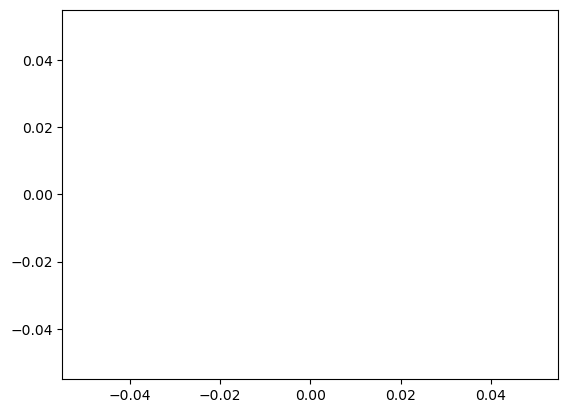

In [16]:
print(np.shape(salt_array))
plt.plot(temp_array[:,38])

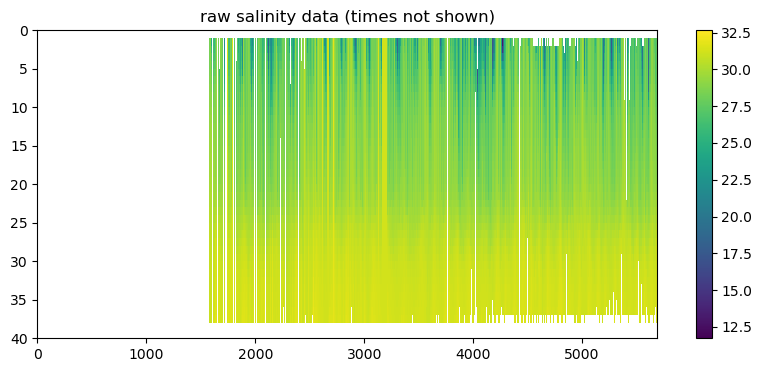

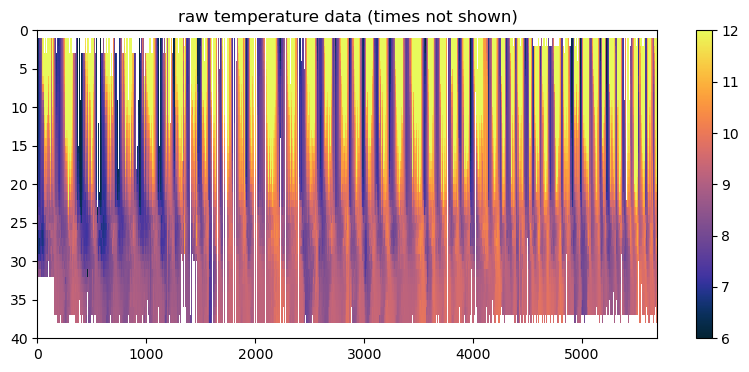

In [17]:
fig, axs = plt.subplots(figsize = (10,4))
w = plt.pcolormesh(np.transpose(salt_array))
axs.set_title('raw salinity data (times not shown)')
plt.colorbar(w, ax = axs)
axs.invert_yaxis()

fig, axs = plt.subplots(figsize = (10,4))
w = plt.pcolormesh(np.transpose(temp_array), vmin = 6, vmax = 12, cmap = cm.cm.thermal)
axs.set_title('raw temperature data (times not shown)')
plt.colorbar(w, ax = axs)
axs.invert_yaxis()

In [18]:

dates_obs = pd.DatetimeIndex(time_array)
obs_yrs = dates_obs.year; obs_months = dates_obs.month; obs_days = dates_obs.day

# print(dates[0])
# print(dates[-1])
dates_all = pd.date_range(start='1979-01-01', end= '2018-12-31', freq='D')

dates_yrs = dates_all.year; dates_months = dates_all.month; dates_days = dates_all.day

print(len(dates_all))
salt_ts = np.zeros([len(dates_all), 40]); salt_ts[:] = np.nan
temp_ts = np.zeros([len(dates_all), 40]); temp_ts[:] = np.nan

### retreive all measurements for a given day. they are given in size [1, x, 40] 
#so you need to take 0 in the first dimension
#not doing so was the error 

for i in range(0, len(dates_all)):
    find_obs = np.where((obs_yrs == dates_yrs[i]) & (obs_months == dates_months[i]) & (obs_days == dates_days[i]))
    if (len(dates_obs[find_obs])>0):
        available_salt = salt_array[find_obs,:]
        available_salt_toav = available_salt[0,:,:]
        salt_ts[i,:] = np.nanmean(available_salt_toav, axis = 0)
        available_temp = temp_array[find_obs,:]
        available_temp_toav = available_temp[0,:,:]
        temp_ts[i,:] = np.nanmean(available_temp_toav, axis = 0)

14610


C:\Users\Greig\AppData\Local\Temp\ipykernel_3024\3885849589.py:23: RuntimeWarning: Mean of empty slice
  salt_ts[i,:] = np.nanmean(available_salt_toav, axis = 0)
C:\Users\Greig\AppData\Local\Temp\ipykernel_3024\3885849589.py:26: RuntimeWarning: Mean of empty slice
  temp_ts[i,:] = np.nanmean(available_temp_toav, axis = 0)


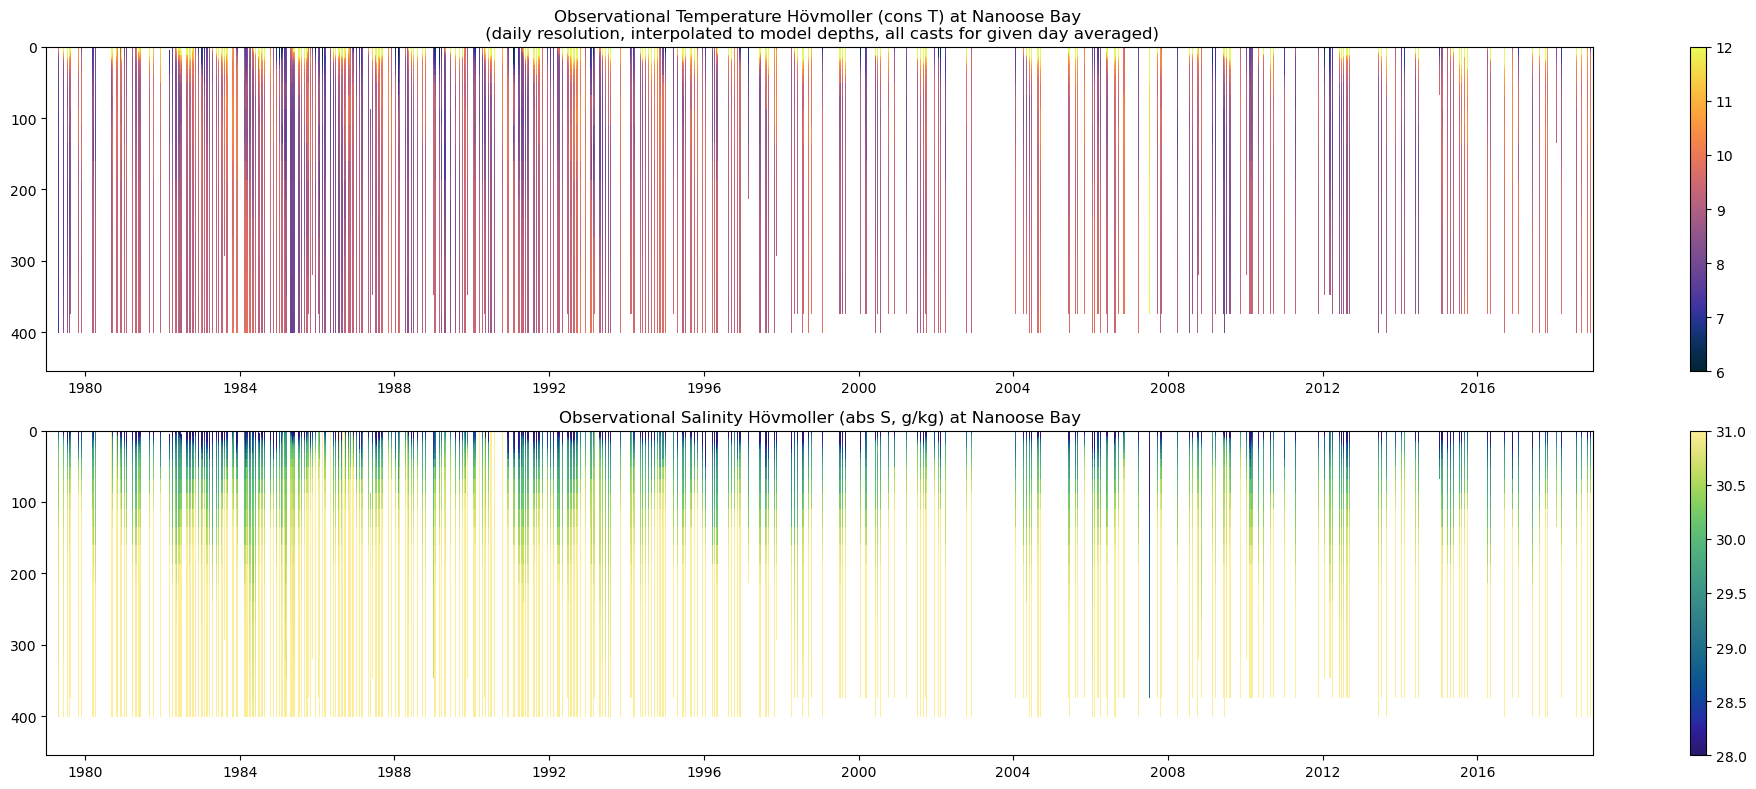

In [19]:

fig, axs = plt.subplots(2, 1, figsize = (20,8))
axs = axs.ravel()
temp_ts[temp_ts <-900] = np.nan
w = axs[0].pcolormesh(dates_all, modd_um, np.transpose(temp_ts), vmin=6, vmax=12, cmap = cm.cm.thermal)
plt.colorbar(w, ax = axs[0])
axs[0].invert_yaxis()

salt_ts[salt_ts <-900] = np.nan
w = axs[1].pcolormesh(dates_all, modd_um, np.transpose(salt_ts), vmin=28, vmax=31, cmap = cm.cm.haline)
plt.colorbar(w, ax = axs[1])
axs[1].invert_yaxis()
axs[0].set_title('Observational Temperature Hövmoller (cons T) at Nanoose Bay \n (daily resolution, interpolated to model depths, all casts for given day averaged)')
axs[1].set_title('Observational Salinity Hövmoller (abs S, g/kg) at Nanoose Bay')

plt.tight_layout()



    set up bimonthly time periods (day <= 15 in a given month is the first time-period of that month)



In [20]:


tslen = (np.shape(salt_ts)[0])

def the_timepd(date):
    tpd = -99
    if ((date.month == 1) & (date.day <= 15)): tpd = 1
    if ((date.month == 1) & (date.day > 15)): tpd = 2   
    if ((date.month == 2) & (date.day <= 15)): tpd = 3
    if ((date.month == 2) & (date.day > 15)): tpd = 4
    if ((date.month == 3) & (date.day <= 15)): tpd = 5
    if ((date.month == 3) & (date.day > 15)): tpd = 6
    if ((date.month == 4) & (date.day <= 15)): tpd = 7
    if ((date.month == 4) & (date.day > 15)): tpd = 8   
    if ((date.month == 5) & (date.day <= 15)): tpd = 9
    if ((date.month == 5) & (date.day > 15)): tpd = 10
    if ((date.month == 6) & (date.day <= 15)): tpd = 11
    if ((date.month == 6) & (date.day > 15)): tpd = 12
    if ((date.month == 7) & (date.day <= 15)): tpd = 12+ 1
    if ((date.month == 7) & (date.day > 15)): tpd = 12+ 2   
    if ((date.month == 8) & (date.day <= 15)): tpd = 12+ 3
    if ((date.month == 8) & (date.day > 15)): tpd = 12+ 4
    if ((date.month == 9) & (date.day <= 15)): tpd = 12+ 5
    if ((date.month == 9) & (date.day > 15)): tpd = 12+ 6
    if ((date.month == 10) & (date.day <= 15)): tpd = 12+ 7
    if ((date.month == 10) & (date.day > 15)): tpd = 12+ 8   
    if ((date.month == 11) & (date.day <= 15)): tpd = 12+ 9
    if ((date.month == 11) & (date.day > 15)): tpd = 12+ 10
    if ((date.month == 12) & (date.day <= 15)): tpd = 12+ 11
    if ((date.month == 12) & (date.day > 15)): tpd = 12+ 12    
    
    return tpd

timeperiod = np.zeros(tslen).astype(int)
for i in range(0,len(timeperiod)):
    timeperiod[i] = int(the_timepd(dates_all[i]))

format this interpolated-to-model-depths time-series (nans where no data) as an xarray object, save as netcdf

In [22]:
savenam = 'ctd_ts_timeseries.nc'
data_vars = {
    'salinity':(['time_counter', 'deptht'], salt_ts,
    {'units': 'psu',
    'long_name':'practical salinity'}),
    'temperature':(['time_counter', 'deptht'], temp_ts,
    {'units': 'deg C',
    'long_name':'in situ temperature'}),
    'timeperiod':(['time_counter'], timeperiod,
    {'units': '1-24, first jalf of jan is 1',
    'long_name':''}),             
    }

# define coordinates
coords = {'time_counter': (['time_counter'], dates_all),
    'deptht': (['deptht'], modd_um)}
# define global attributes
attrs = {'made in':'NanooseObs/checkSampleData.ipynb',
'desc': 'yearly medusa files, saving only variables of interest'
}
ds = xr.Dataset(data_vars=data_vars,
coords=coords,
attrs=attrs)
ds.to_netcdf(savenam)

Text(0.5, 0.98, 'observational climatology of T and S from the Nanoose dataset \n biweekly time-periods')

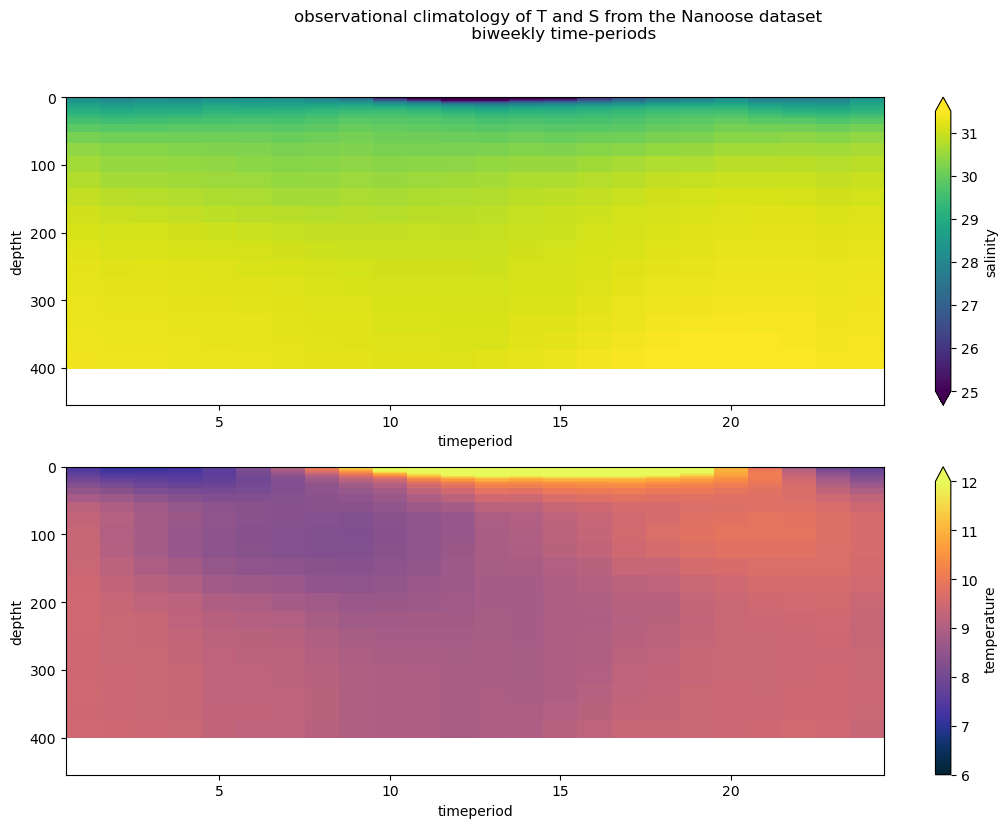

In [23]:


q = ds.salinity.groupby(ds.timeperiod).mean().T

fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

salt_clim = ds.salinity.groupby(ds.timeperiod).mean().T
xr.plot.pcolormesh(salt_clim, ax = axs[0], vmin = 25, vmax = 31.5)

temp_clim = ds.temperature.groupby(ds.timeperiod).mean().T
xr.plot.pcolormesh(temp_clim, ax = axs[1], cmap = cm.cm.thermal, vmin = 6, vmax = 12)

axs[0].invert_yaxis()
axs[1].invert_yaxis()


fig.suptitle('observational climatology of T and S from the Nanoose dataset \n biweekly time-periods')





    we now need to resample our time-series such that there are 24 time-periods per year (for the purposes of graphing, as well as finding any trends)
    to make a tidy xarray object, i assign the dates manually, 2 nominal "days" per month, Jan 1- Jan 15 is Jan 7, Jan 16- Jan 31 is Jan 23, etc)



In [24]:
tdt = np.array(['1979-01-07', '1979-01-23','1979-02-07', '1979-02-23',
'1979-03-07', '1979-03-23','1979-04-07', '1979-04-23',
'1979-05-07', '1979-05-23','1979-06-07', '1979-06-23',
'1979-07-07', '1979-07-23','1979-08-07', '1979-08-23',
'1979-09-07', '1979-09-23','1979-10-07', '1979-10-23',
'1979-11-07', '1979-11-23','1979-12-07', '1979-12-23',
'1980-01-07', '1980-01-23','1980-02-07', '1980-02-23',
'1980-03-07', '1980-03-23','1980-04-07', '1980-04-23',
'1980-05-07', '1980-05-23','1980-06-07', '1980-06-23',
'1980-07-07', '1980-07-23','1980-08-07', '1980-08-23',
'1980-09-07', '1980-09-23','1980-10-07', '1980-10-23',
'1980-11-07', '1980-11-23','1980-12-07', '1980-12-23',
'1981-01-07', '1981-01-23','1981-02-07', '1981-02-23',
'1981-03-07', '1981-03-23','1981-04-07', '1981-04-23',
'1981-05-07', '1981-05-23','1981-06-07', '1981-06-23',
'1981-07-07', '1981-07-23','1981-08-07', '1981-08-23',
'1981-09-07', '1981-09-23','1981-10-07', '1981-10-23',
'1981-11-07', '1981-11-23','1981-12-07', '1981-12-23',
'1982-01-07', '1982-01-23','1982-02-07', '1982-02-23',
'1982-03-07', '1982-03-23','1982-04-07', '1982-04-23',
'1982-05-07', '1982-05-23','1982-06-07', '1982-06-23',
'1982-07-07', '1982-07-23','1982-08-07', '1982-08-23',
'1982-09-07', '1982-09-23','1982-10-07', '1982-10-23',
'1982-11-07', '1982-11-23','1982-12-07', '1982-12-23',
'1983-01-07', '1983-01-23','1983-02-07', '1983-02-23',
'1983-03-07', '1983-03-23','1983-04-07', '1983-04-23',
'1983-05-07', '1983-05-23','1983-06-07', '1983-06-23',
'1983-07-07', '1983-07-23','1983-08-07', '1983-08-23',
'1983-09-07', '1983-09-23','1983-10-07', '1983-10-23',
'1983-11-07', '1983-11-23','1983-12-07', '1983-12-23',
'1984-01-07', '1984-01-23','1984-02-07', '1984-02-23',
'1984-03-07', '1984-03-23','1984-04-07', '1984-04-23',
'1984-05-07', '1984-05-23','1984-06-07', '1984-06-23',
'1984-07-07', '1984-07-23','1984-08-07', '1984-08-23',
'1984-09-07', '1984-09-23','1984-10-07', '1984-10-23',
'1984-11-07', '1984-11-23','1984-12-07', '1984-12-23',
'1985-01-07', '1985-01-23','1985-02-07', '1985-02-23',
'1985-03-07', '1985-03-23','1985-04-07', '1985-04-23',
'1985-05-07', '1985-05-23','1985-06-07', '1985-06-23',
'1985-07-07', '1985-07-23','1985-08-07', '1985-08-23',
'1985-09-07', '1985-09-23','1985-10-07', '1985-10-23',
'1985-11-07', '1985-11-23','1985-12-07', '1985-12-23',
'1986-01-07', '1986-01-23','1986-02-07', '1986-02-23',
'1986-03-07', '1986-03-23','1986-04-07', '1986-04-23',
'1986-05-07', '1986-05-23','1986-06-07', '1986-06-23',
'1986-07-07', '1986-07-23','1986-08-07', '1986-08-23',
'1986-09-07', '1986-09-23','1986-10-07', '1986-10-23',
'1986-11-07', '1986-11-23','1986-12-07', '1986-12-23',
'1987-01-07', '1987-01-23','1987-02-07', '1987-02-23',
'1987-03-07', '1987-03-23','1987-04-07', '1987-04-23',
'1987-05-07', '1987-05-23','1987-06-07', '1987-06-23',
'1987-07-07', '1987-07-23','1987-08-07', '1987-08-23',
'1987-09-07', '1987-09-23','1987-10-07', '1987-10-23',
'1987-11-07', '1987-11-23','1987-12-07', '1987-12-23',
'1988-01-07', '1988-01-23','1988-02-07', '1988-02-23',
'1988-03-07', '1988-03-23','1988-04-07', '1988-04-23',
'1988-05-07', '1988-05-23','1988-06-07', '1988-06-23',
'1988-07-07', '1988-07-23','1988-08-07', '1988-08-23',
'1988-09-07', '1988-09-23','1988-10-07', '1988-10-23',
'1988-11-07', '1988-11-23','1988-12-07', '1988-12-23',
'1989-01-07', '1989-01-23','1989-02-07', '1989-02-23',
'1989-03-07', '1989-03-23','1989-04-07', '1989-04-23',
'1989-05-07', '1989-05-23','1989-06-07', '1989-06-23',
'1989-07-07', '1989-07-23','1989-08-07', '1989-08-23',
'1989-09-07', '1989-09-23','1989-10-07', '1989-10-23',
'1989-11-07', '1989-11-23','1989-12-07', '1989-12-23',
'1990-01-07', '1990-01-23','1990-02-07', '1990-02-23',
'1990-03-07', '1990-03-23','1990-04-07', '1990-04-23',
'1990-05-07', '1990-05-23','1990-06-07', '1990-06-23',
'1990-07-07', '1990-07-23','1990-08-07', '1990-08-23',
'1990-09-07', '1990-09-23','1990-10-07', '1990-10-23',
'1990-11-07', '1990-11-23','1990-12-07', '1990-12-23',
'1991-01-07', '1991-01-23','1991-02-07', '1991-02-23',
'1991-03-07', '1991-03-23','1991-04-07', '1991-04-23',
'1991-05-07', '1991-05-23','1991-06-07', '1991-06-23',
'1991-07-07', '1991-07-23','1991-08-07', '1991-08-23',
'1991-09-07', '1991-09-23','1991-10-07', '1991-10-23',
'1991-11-07', '1991-11-23','1991-12-07', '1991-12-23',
'1992-01-07', '1992-01-23','1992-02-07', '1992-02-23',
'1992-03-07', '1992-03-23','1992-04-07', '1992-04-23',
'1992-05-07', '1992-05-23','1992-06-07', '1992-06-23',
'1992-07-07', '1992-07-23','1992-08-07', '1992-08-23',
'1992-09-07', '1992-09-23','1992-10-07', '1992-10-23',
'1992-11-07', '1992-11-23','1992-12-07', '1992-12-23',
'1993-01-07', '1993-01-23','1993-02-07', '1993-02-23',
'1993-03-07', '1993-03-23','1993-04-07', '1993-04-23',
'1993-05-07', '1993-05-23','1993-06-07', '1993-06-23',
'1993-07-07', '1993-07-23','1993-08-07', '1993-08-23',
'1993-09-07', '1993-09-23','1993-10-07', '1993-10-23',
'1993-11-07', '1993-11-23','1993-12-07', '1993-12-23',
'1994-01-07', '1994-01-23','1994-02-07', '1994-02-23',
'1994-03-07', '1994-03-23','1994-04-07', '1994-04-23',
'1994-05-07', '1994-05-23','1994-06-07', '1994-06-23',
'1994-07-07', '1994-07-23','1994-08-07', '1994-08-23',
'1994-09-07', '1994-09-23','1994-10-07', '1994-10-23',
'1994-11-07', '1994-11-23','1994-12-07', '1994-12-23',
'1995-01-07', '1995-01-23','1995-02-07', '1995-02-23',
'1995-03-07', '1995-03-23','1995-04-07', '1995-04-23',
'1995-05-07', '1995-05-23','1995-06-07', '1995-06-23',
'1995-07-07', '1995-07-23','1995-08-07', '1995-08-23',
'1995-09-07', '1995-09-23','1995-10-07', '1995-10-23',
'1995-11-07', '1995-11-23','1995-12-07', '1995-12-23',
'1996-01-07', '1996-01-23','1996-02-07', '1996-02-23',
'1996-03-07', '1996-03-23','1996-04-07', '1996-04-23',
'1996-05-07', '1996-05-23','1996-06-07', '1996-06-23',
'1996-07-07', '1996-07-23','1996-08-07', '1996-08-23',
'1996-09-07', '1996-09-23','1996-10-07', '1996-10-23',
'1996-11-07', '1996-11-23','1996-12-07', '1996-12-23',
'1997-01-07', '1997-01-23','1997-02-07', '1997-02-23',
'1997-03-07', '1997-03-23','1997-04-07', '1997-04-23',
'1997-05-07', '1997-05-23','1997-06-07', '1997-06-23',
'1997-07-07', '1997-07-23','1997-08-07', '1997-08-23',
'1997-09-07', '1997-09-23','1997-10-07', '1997-10-23',
'1997-11-07', '1997-11-23','1997-12-07', '1997-12-23',
'1998-01-07', '1998-01-23','1998-02-07', '1998-02-23',
'1998-03-07', '1998-03-23','1998-04-07', '1998-04-23',
'1998-05-07', '1998-05-23','1998-06-07', '1998-06-23',
'1998-07-07', '1998-07-23','1998-08-07', '1998-08-23',
'1998-09-07', '1998-09-23','1998-10-07', '1998-10-23',
'1998-11-07', '1998-11-23','1998-12-07', '1998-12-23',
'1999-01-07', '1999-01-23','1999-02-07', '1999-02-23',
'1999-03-07', '1999-03-23','1999-04-07', '1999-04-23',
'1999-05-07', '1999-05-23','1999-06-07', '1999-06-23',
'1999-07-07', '1999-07-23','1999-08-07', '1999-08-23',
'1999-09-07', '1999-09-23','1999-10-07', '1999-10-23',
'1999-11-07', '1999-11-23','1999-12-07', '1999-12-23',
'2000-01-07', '2000-01-23','2000-02-07', '2000-02-23',
'2000-03-07', '2000-03-23','2000-04-07', '2000-04-23',
'2000-05-07', '2000-05-23','2000-06-07', '2000-06-23',
'2000-07-07', '2000-07-23','2000-08-07', '2000-08-23',
'2000-09-07', '2000-09-23','2000-10-07', '2000-10-23',
'2000-11-07', '2000-11-23','2000-12-07', '2000-12-23',
'2001-01-07', '2001-01-23','2001-02-07', '2001-02-23',
'2001-03-07', '2001-03-23','2001-04-07', '2001-04-23',
'2001-05-07', '2001-05-23','2001-06-07', '2001-06-23',
'2001-07-07', '2001-07-23','2001-08-07', '2001-08-23',
'2001-09-07', '2001-09-23','2001-10-07', '2001-10-23',
'2001-11-07', '2001-11-23','2001-12-07', '2001-12-23',
'2002-01-07', '2002-01-23','2002-02-07', '2002-02-23',
'2002-03-07', '2002-03-23','2002-04-07', '2002-04-23',
'2002-05-07', '2002-05-23','2002-06-07', '2002-06-23',
'2002-07-07', '2002-07-23','2002-08-07', '2002-08-23',
'2002-09-07', '2002-09-23','2002-10-07', '2002-10-23',
'2002-11-07', '2002-11-23','2002-12-07', '2002-12-23',
'2003-01-07', '2003-01-23','2003-02-07', '2003-02-23',
'2003-03-07', '2003-03-23','2003-04-07', '2003-04-23',
'2003-05-07', '2003-05-23','2003-06-07', '2003-06-23',
'2003-07-07', '2003-07-23','2003-08-07', '2003-08-23',
'2003-09-07', '2003-09-23','2003-10-07', '2003-10-23',
'2003-11-07', '2003-11-23','2003-12-07', '2003-12-23',
'2004-01-07', '2004-01-23','2004-02-07', '2004-02-23',
'2004-03-07', '2004-03-23','2004-04-07', '2004-04-23',
'2004-05-07', '2004-05-23','2004-06-07', '2004-06-23',
'2004-07-07', '2004-07-23','2004-08-07', '2004-08-23',
'2004-09-07', '2004-09-23','2004-10-07', '2004-10-23',
'2004-11-07', '2004-11-23','2004-12-07', '2004-12-23',
'2005-01-07', '2005-01-23','2005-02-07', '2005-02-23',
'2005-03-07', '2005-03-23','2005-04-07', '2005-04-23',
'2005-05-07', '2005-05-23','2005-06-07', '2005-06-23',
'2005-07-07', '2005-07-23','2005-08-07', '2005-08-23',
'2005-09-07', '2005-09-23','2005-10-07', '2005-10-23',
'2005-11-07', '2005-11-23','2005-12-07', '2005-12-23',
'2006-01-07', '2006-01-23','2006-02-07', '2006-02-23',
'2006-03-07', '2006-03-23','2006-04-07', '2006-04-23',
'2006-05-07', '2006-05-23','2006-06-07', '2006-06-23',
'2006-07-07', '2006-07-23','2006-08-07', '2006-08-23',
'2006-09-07', '2006-09-23','2006-10-07', '2006-10-23',
'2006-11-07', '2006-11-23','2006-12-07', '2006-12-23',
'2007-01-07', '2007-01-23','2007-02-07', '2007-02-23',
'2007-03-07', '2007-03-23','2007-04-07', '2007-04-23',
'2007-05-07', '2007-05-23','2007-06-07', '2007-06-23',
'2007-07-07', '2007-07-23','2007-08-07', '2007-08-23',
'2007-09-07', '2007-09-23','2007-10-07', '2007-10-23',
'2007-11-07', '2007-11-23','2007-12-07', '2007-12-23',
'2008-01-07', '2008-01-23','2008-02-07', '2008-02-23',
'2008-03-07', '2008-03-23','2008-04-07', '2008-04-23',
'2008-05-07', '2008-05-23','2008-06-07', '2008-06-23',
'2008-07-07', '2008-07-23','2008-08-07', '2008-08-23',
'2008-09-07', '2008-09-23','2008-10-07', '2008-10-23',
'2008-11-07', '2008-11-23','2008-12-07', '2008-12-23',
'2009-01-07', '2009-01-23','2009-02-07', '2009-02-23',
'2009-03-07', '2009-03-23','2009-04-07', '2009-04-23',
'2009-05-07', '2009-05-23','2009-06-07', '2009-06-23',
'2009-07-07', '2009-07-23','2009-08-07', '2009-08-23',
'2009-09-07', '2009-09-23','2009-10-07', '2009-10-23',
'2009-11-07', '2009-11-23','2009-12-07', '2009-12-23',
'2010-01-07', '2010-01-23','2010-02-07', '2010-02-23',
'2010-03-07', '2010-03-23','2010-04-07', '2010-04-23',
'2010-05-07', '2010-05-23','2010-06-07', '2010-06-23',
'2010-07-07', '2010-07-23','2010-08-07', '2010-08-23',
'2010-09-07', '2010-09-23','2010-10-07', '2010-10-23',
'2010-11-07', '2010-11-23','2010-12-07', '2010-12-23',
'2011-01-07', '2011-01-23','2011-02-07', '2011-02-23',
'2011-03-07', '2011-03-23','2011-04-07', '2011-04-23',
'2011-05-07', '2011-05-23','2011-06-07', '2011-06-23',
'2011-07-07', '2011-07-23','2011-08-07', '2011-08-23',
'2011-09-07', '2011-09-23','2011-10-07', '2011-10-23',
'2011-11-07', '2011-11-23','2011-12-07', '2011-12-23',
'2012-01-07', '2012-01-23','2012-02-07', '2012-02-23',
'2012-03-07', '2012-03-23','2012-04-07', '2012-04-23',
'2012-05-07', '2012-05-23','2012-06-07', '2012-06-23',
'2012-07-07', '2012-07-23','2012-08-07', '2012-08-23',
'2012-09-07', '2012-09-23','2012-10-07', '2012-10-23',
'2012-11-07', '2012-11-23','2012-12-07', '2012-12-23',
'2013-01-07', '2013-01-23','2013-02-07', '2013-02-23',
'2013-03-07', '2013-03-23','2013-04-07', '2013-04-23',
'2013-05-07', '2013-05-23','2013-06-07', '2013-06-23',
'2013-07-07', '2013-07-23','2013-08-07', '2013-08-23',
'2013-09-07', '2013-09-23','2013-10-07', '2013-10-23',
'2013-11-07', '2013-11-23','2013-12-07', '2013-12-23',
'2014-01-07', '2014-01-23','2014-02-07', '2014-02-23',
'2014-03-07', '2014-03-23','2014-04-07', '2014-04-23',
'2014-05-07', '2014-05-23','2014-06-07', '2014-06-23',
'2014-07-07', '2014-07-23','2014-08-07', '2014-08-23',
'2014-09-07', '2014-09-23','2014-10-07', '2014-10-23',
'2014-11-07', '2014-11-23','2014-12-07', '2014-12-23',
'2015-01-07', '2015-01-23','2015-02-07', '2015-02-23',
'2015-03-07', '2015-03-23','2015-04-07', '2015-04-23',
'2015-05-07', '2015-05-23','2015-06-07', '2015-06-23',
'2015-07-07', '2015-07-23','2015-08-07', '2015-08-23',
'2015-09-07', '2015-09-23','2015-10-07', '2015-10-23',
'2015-11-07', '2015-11-23','2015-12-07', '2015-12-23',
'2016-01-07', '2016-01-23','2016-02-07', '2016-02-23',
'2016-03-07', '2016-03-23','2016-04-07', '2016-04-23',
'2016-05-07', '2016-05-23','2016-06-07', '2016-06-23',
'2016-07-07', '2016-07-23','2016-08-07', '2016-08-23',
'2016-09-07', '2016-09-23','2016-10-07', '2016-10-23',
'2016-11-07', '2016-11-23','2016-12-07', '2016-12-23',
'2017-01-07', '2017-01-23','2017-02-07', '2017-02-23',
'2017-03-07', '2017-03-23','2017-04-07', '2017-04-23',
'2017-05-07', '2017-05-23','2017-06-07', '2017-06-23',
'2017-07-07', '2017-07-23','2017-08-07', '2017-08-23',
'2017-09-07', '2017-09-23','2017-10-07', '2017-10-23',
'2017-11-07', '2017-11-23','2017-12-07', '2017-12-23',
'2018-01-07', '2018-01-23','2018-02-07', '2018-02-23',
'2018-03-07', '2018-03-23','2018-04-07', '2018-04-23',
'2018-05-07', '2018-05-23','2018-06-07', '2018-06-23',
'2018-07-07', '2018-07-23','2018-08-07', '2018-08-23',
'2018-09-07', '2018-09-23','2018-10-07', '2018-10-23',
'2018-11-07', '2018-11-23','2018-12-07', '2018-12-23',], dtype='datetime64')

In [25]:
make_bimonthly = True #don't run this analysis if you don't need to
if make_bimonthly:
    tperiod = ds.timeperiod.values
    timestamp = ds.time_counter.values
    dates_obs = pd.DatetimeIndex(timestamp)
    obs_yrs = np.array(dates_obs.year)

    salt = ds.salinity.values
    temp = ds.temperature.values

    salt_bimonth = np.zeros([960,40]); salt_bimonth[:] = np.nan
    temp_bimonth = np.zeros([960,40]); temp_bimonth[:] = np.nan
    this_timeperiod = np.zeros([960])

    ind = 0
    for yr in range(1979,2019):
        for tp in range(1,25):
            filt = ((obs_yrs == yr) & (tperiod == tp))
            salt_bimonth[ind,:] = np.nanmean((salt[filt,:]), axis = 0)
            temp_bimonth[ind,:] = np.nanmean((temp[filt,:]), axis = 0)
            this_timeperiod[ind] = tp
            ind = ind+1


    savenam = 'ctd_ts_timeseries_bimonthly.nc'
    data_vars = {
        'salinity':(['time_counter', 'deptht'], salt_bimonth,
        {'units': 'psu',
        'long_name':'practical salinity'}),
        'temperature':(['time_counter', 'deptht'], temp_bimonth,
        {'units': 'deg C',
        'long_name':'in situ temperature'}),
        'timeperiod':(['time_counter'], this_timeperiod,
        {'units': '1-24, first jalf of jan is 1',
        'long_name':''}),             
        }

    # define coordinates
    coords = {'time_counter': (['time_counter'], tdt),
        'deptht': (['deptht'], modd_um)}
    # define global attributes
    attrs = {'made in':'NanooseObs/checkSampleData.ipynb',
    'desc': 'yearly medusa files, saving only variables of interest'
    }
    ds2 = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds2.to_netcdf(savenam)

C:\Users\Greig\AppData\Local\Temp\ipykernel_3024\2698102523.py:19: RuntimeWarning: Mean of empty slice
  salt_bimonth[ind,:] = np.nanmean((salt[filt,:]), axis = 0)
C:\Users\Greig\AppData\Local\Temp\ipykernel_3024\2698102523.py:20: RuntimeWarning: Mean of empty slice
  temp_bimonth[ind,:] = np.nanmean((temp[filt,:]), axis = 0)


plot our new timeseries

Text(0.5, 0.98, 'observational timeseries, grouped into bimonthly (~15day) windows')

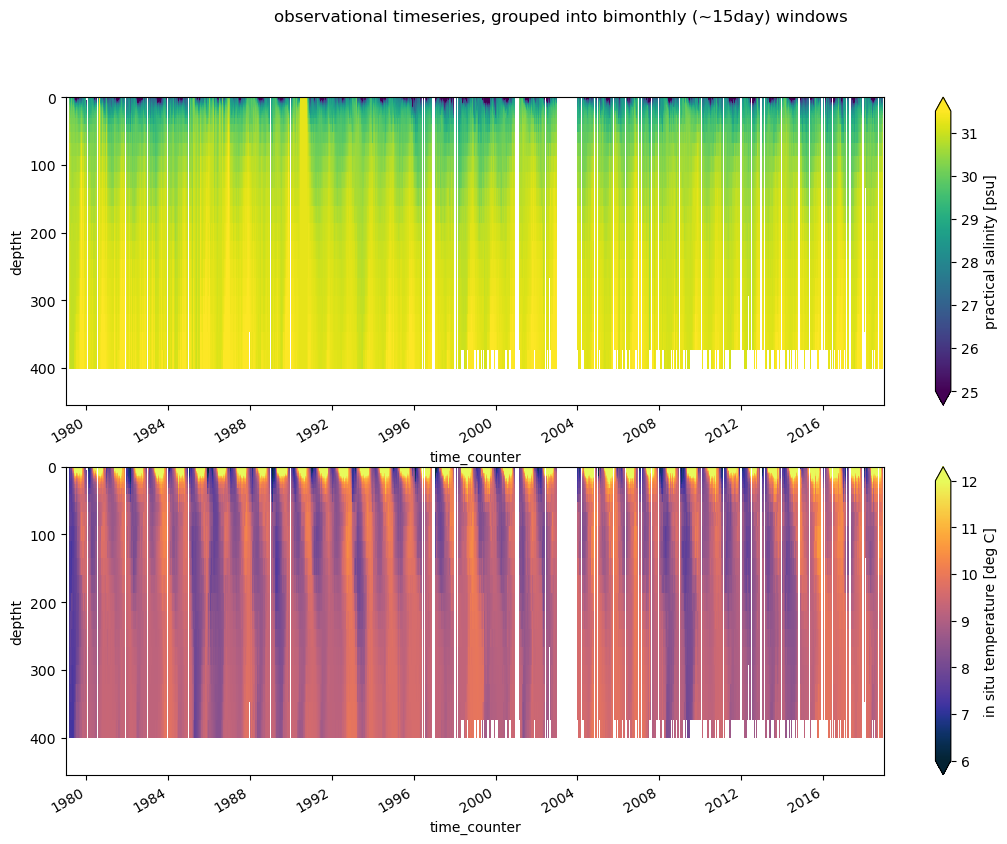

In [28]:


fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

salt_bm = ds2.salinity.T
xr.plot.pcolormesh(salt_bm, ax = axs[0], vmin = 25, vmax = 31.5)

temp_bm = ds2.temperature.T
xr.plot.pcolormesh(temp_bm, ax = axs[1], cmap = cm.cm.thermal, vmin = 6, vmax = 12)

axs[0].invert_yaxis()
axs[1].invert_yaxis()

plt.suptitle('observational timeseries, grouped into bimonthly (~15day) windows')

group by the 24 time periods and get a climatology

Text(0.5, 0.98, 'observational climatology of T and S from the Nanoose dataset \n biweekly time-periods')

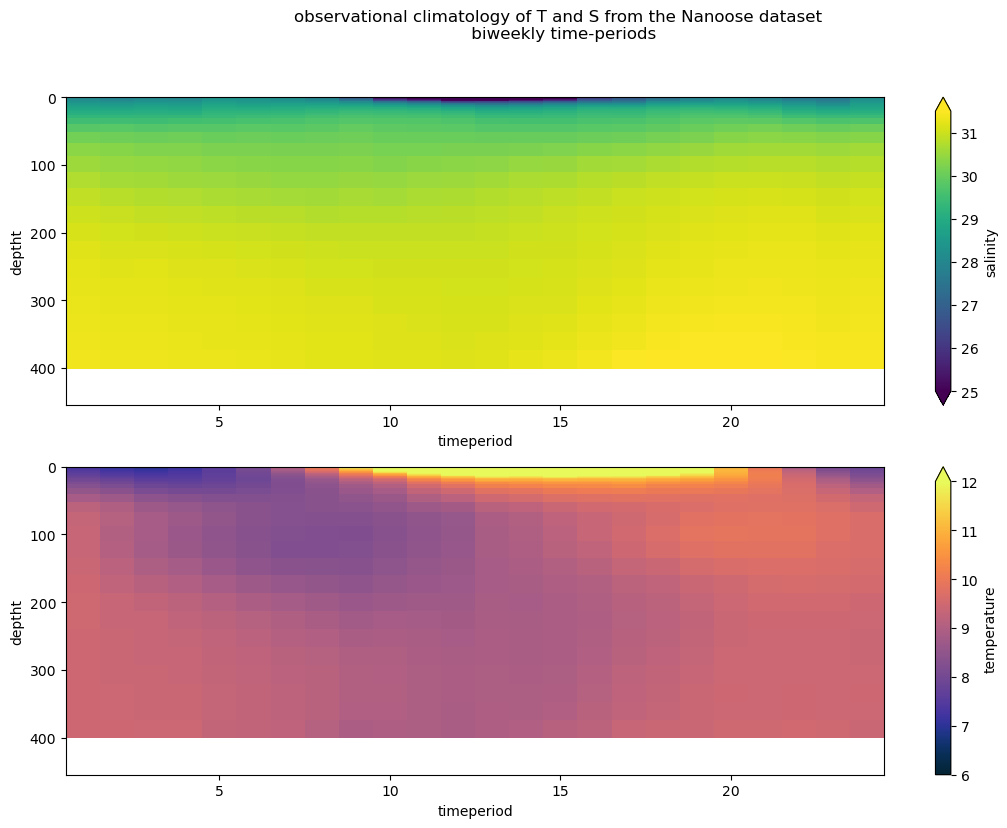

In [29]:


q = ds2.salinity.groupby(ds2.timeperiod).mean().T

fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

salt_clim = ds2.salinity.groupby(ds2.timeperiod).mean().T
xr.plot.pcolormesh(salt_clim, ax = axs[0], vmin = 25, vmax = 31.5)

temp_clim = ds2.temperature.groupby(ds2.timeperiod).mean().T
xr.plot.pcolormesh(temp_clim, ax = axs[1], cmap = cm.cm.thermal, vmin = 6, vmax = 12)

axs[0].invert_yaxis()
axs[1].invert_yaxis()

fig.suptitle('observational climatology of T and S from the Nanoose dataset \n biweekly time-periods')



detrend (ie, for each time series point, subtract the climatology and visualize the departures

In [30]:
saltts_minusclim = salt_bm.groupby(ds2.timeperiod)-salt_clim
tempts_minusclim = temp_bm.groupby(ds2.timeperiod)-temp_clim

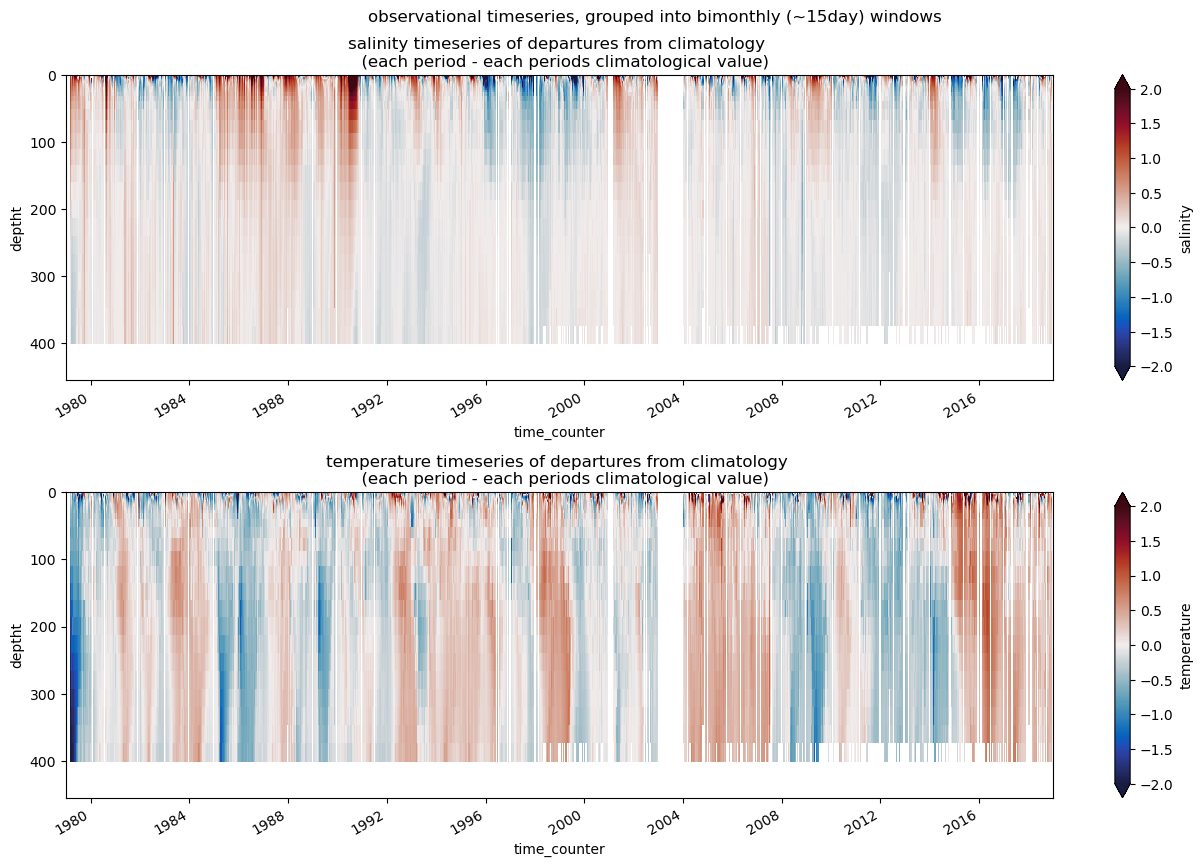

In [31]:


fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

xr.plot.pcolormesh(saltts_minusclim, ax = axs[0], cmap = cm.cm.balance, vmin = -2, vmax = 2)

xr.plot.pcolormesh(tempts_minusclim, ax = axs[1], cmap = cm.cm.balance, vmin = -2, vmax = 2)

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[0].set_title('salinity timeseries of departures from climatology \n  (each period - each periods climatological value)')
axs[1].set_title('temperature timeseries of departures from climatology \n  (each period - each periods climatological value)')

plt.suptitle('observational timeseries, grouped into bimonthly (~15day) windows')
plt.tight_layout()

visualize the timeseries o

Text(0.5, 0.98, 'Nanoose Bay obs. temperatures, top 10 m of watercolumn, bimonthly sampled  \n (climatological seasonal cycle removed)')

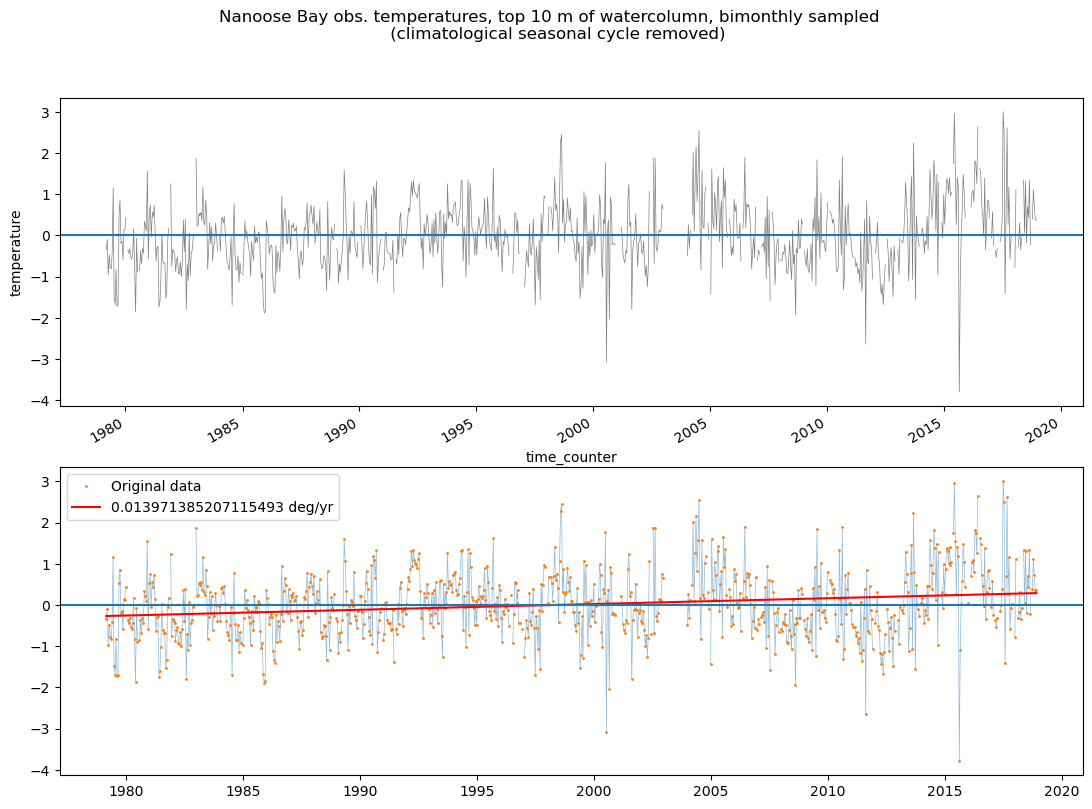

In [32]:
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

top10mtemp = tempts_minusclim.isel(deptht = tempts_minusclim.deptht <10.5).mean(dim = 'deptht')

top10mtemp.plot(ax = axs[0], color = 'k', linewidth = 0.5, alpha = 0.5)
axs[0].axhline(y=0)


## get it from datetimes to numbers to find trend in a per/year thing
tyr = np.arange(1979,2019,(1/24))
axs[1].plot(tyr,top10mtemp.values,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(top10mtemp.values)]
y = top10mtemp.values[~np.isnan(top10mtemp.values)]
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
axs[1].plot(x, y, '.', label='Original data', markersize=2)
axs[1].plot(x, m*x + c, 'r', label=f'{m} deg/yr')
axs[1].legend(loc = 'best')
axs[1].axhline(y=0)

plt.suptitle('Nanoose Bay obs. temperatures, top 10 m of watercolumn, bimonthly sampled  \n (climatological seasonal cycle removed)')

added by Greig 2023-03

Text(0.5, 0.98, 'Nanoose Bay obs. temperatures, top 400 m of watercolumn, bimonthly sampled  \n (climatological seasonal cycle removed)')

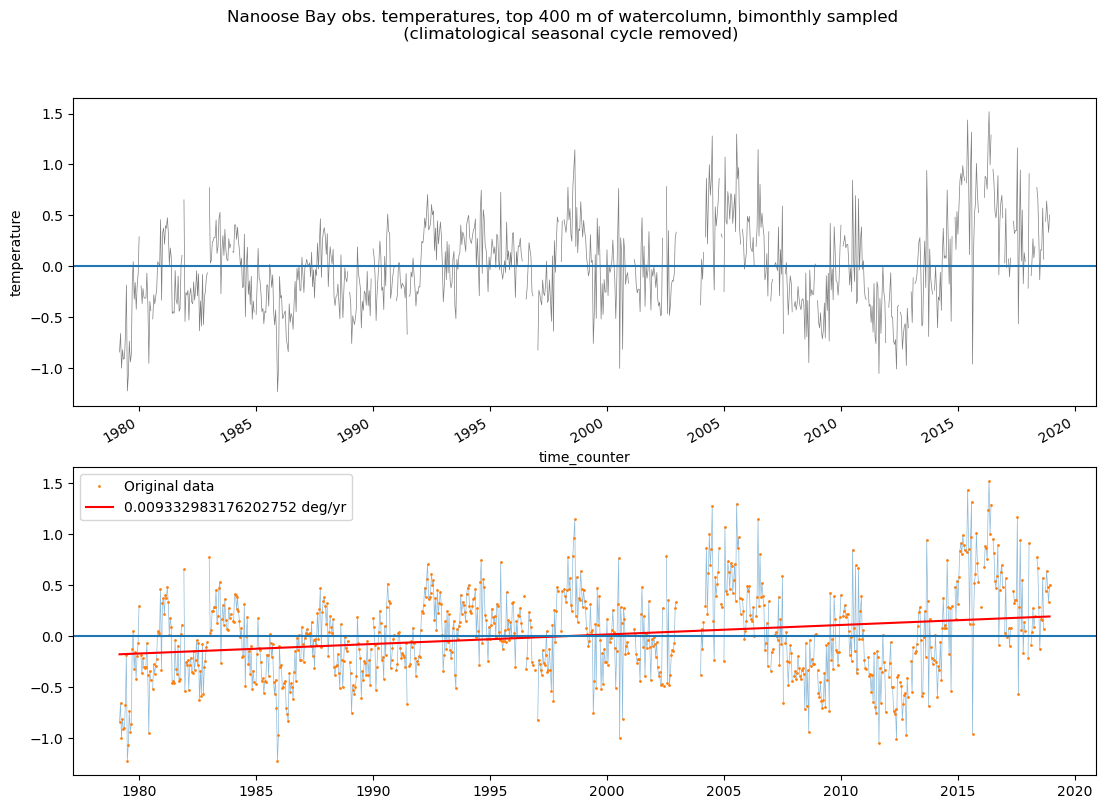

In [33]:
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

top400mtemp = tempts_minusclim.isel(deptht = tempts_minusclim.deptht <400).mean(dim = 'deptht')

top400mtemp.plot(ax = axs[0], color = 'k', linewidth = 0.5, alpha = 0.5)
axs[0].axhline(y=0)


## get it from datetimes to numbers to find trend in a per/year thing
tyr = np.arange(1979,2019,(1/24))
axs[1].plot(tyr,top400mtemp.values,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(top400mtemp.values)]
y = top400mtemp.values[~np.isnan(top400mtemp.values)]
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
axs[1].plot(x, y, '.', label='Original data', markersize=2)
axs[1].plot(x, m*x + c, 'r', label=f'{m} deg/yr')
axs[1].legend(loc = 'best')
axs[1].axhline(y=0)

plt.suptitle('Nanoose Bay obs. temperatures, top 400 m of watercolumn, bimonthly sampled  \n (climatological seasonal cycle removed)')

In [34]:
dates_obs = pd.DatetimeIndex(time_array)
obs_yrs = dates_obs.year; obs_months = dates_obs.month; obs_days = dates_obs.day

# print(dates[0])
# print(dates[-1])
dates_all = pd.date_range(start='1970-01-01', end= '2018-12-31', freq='D')

dates_yrs = dates_all.year; dates_months = dates_all.month; dates_days = dates_all.day

print(len(dates_all))
salt_ts = np.zeros([len(dates_all), 40]); salt_ts[:] = np.nan
temp_ts = np.zeros([len(dates_all), 40]); temp_ts[:] = np.nan

### retreive all measurements for a given day. they are given in size [1, x, 40] 
#so you need to take 0 in the first dimension
#not doing so was the error 

for i in range(0, len(dates_all)):
    find_obs = np.where((obs_yrs == dates_yrs[i]) & (obs_months == dates_months[i]) & (obs_days == dates_days[i]))
    if (len(dates_obs[find_obs])>0):
        available_salt = salt_array[find_obs,:]
        available_salt_toav = available_salt[0,:,:]
        salt_ts[i,:] = np.nanmean(available_salt_toav, axis = 0)
        available_temp = temp_array[find_obs,:]
        available_temp_toav = available_temp[0,:,:]
        temp_ts[i,:] = np.nanmean(available_temp_toav, axis = 0)

17897


C:\Users\Greig\AppData\Local\Temp\ipykernel_3024\3192836882.py:23: RuntimeWarning: Mean of empty slice
  salt_ts[i,:] = np.nanmean(available_salt_toav, axis = 0)
C:\Users\Greig\AppData\Local\Temp\ipykernel_3024\3192836882.py:26: RuntimeWarning: Mean of empty slice
  temp_ts[i,:] = np.nanmean(available_temp_toav, axis = 0)


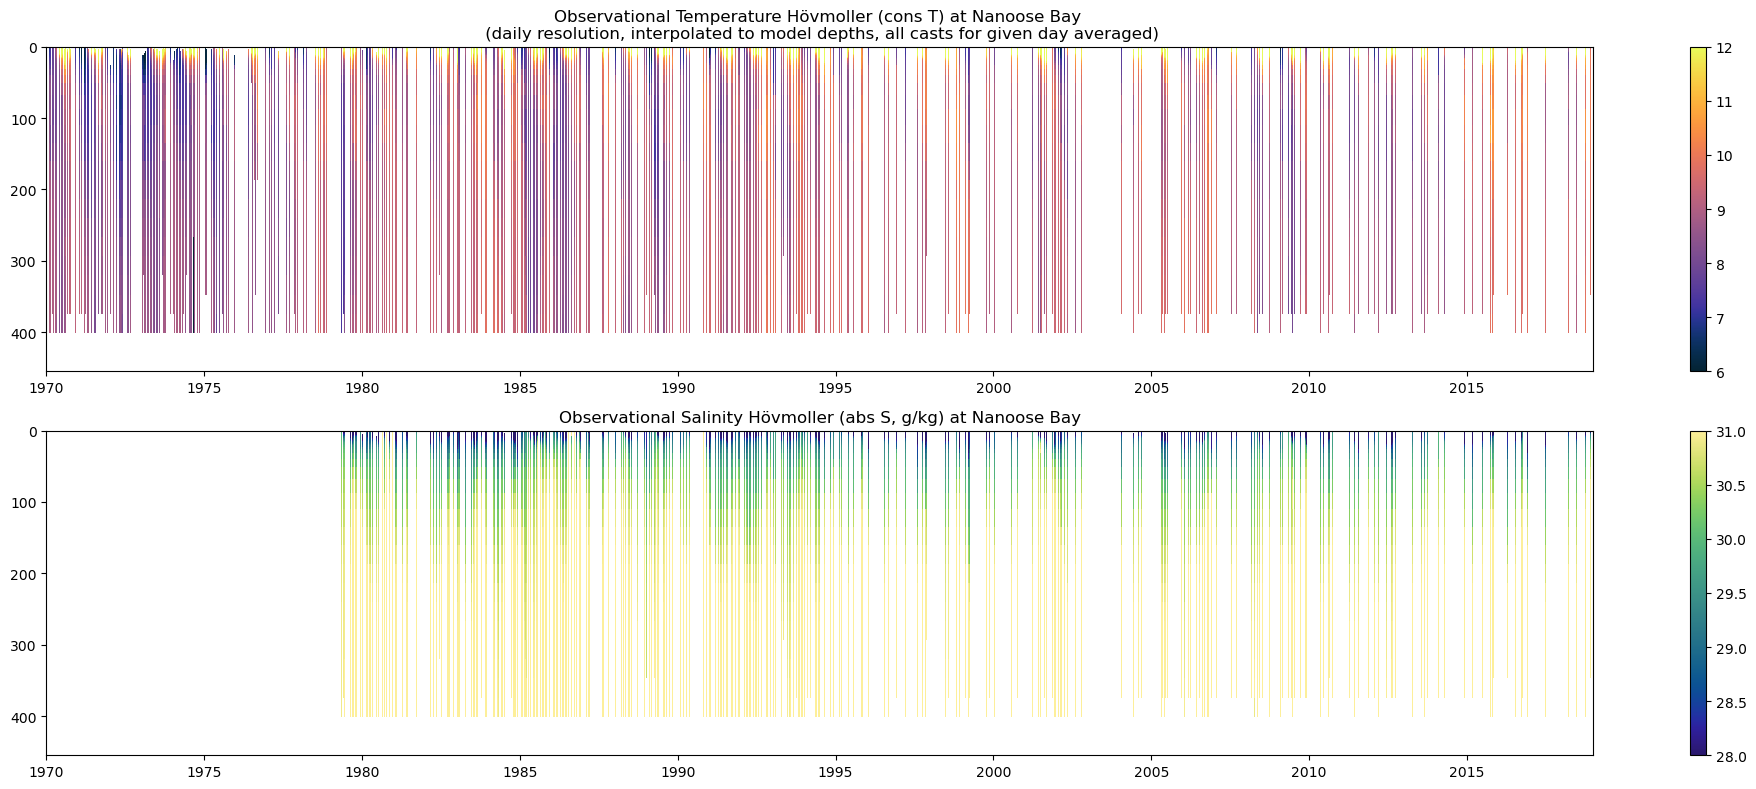

In [35]:
fig, axs = plt.subplots(2, 1, figsize = (20,8))
axs = axs.ravel()
temp_ts[temp_ts <-900] = np.nan
w = axs[0].pcolormesh(dates_all, modd_um, np.transpose(temp_ts), vmin=6, vmax=12, cmap = cm.cm.thermal)
plt.colorbar(w, ax = axs[0])
axs[0].invert_yaxis()

salt_ts[salt_ts <-900] = np.nan
w = axs[1].pcolormesh(dates_all, modd_um, np.transpose(salt_ts), vmin=28, vmax=31, cmap = cm.cm.haline)
plt.colorbar(w, ax = axs[1])
axs[1].invert_yaxis()
axs[0].set_title('Observational Temperature Hövmoller (cons T) at Nanoose Bay \n (daily resolution, interpolated to model depths, all casts for given day averaged)')
axs[1].set_title('Observational Salinity Hövmoller (abs S, g/kg) at Nanoose Bay')

plt.tight_layout()

In [36]:
tslen = (np.shape(temp_ts)[0])

def the_timepd(date):
    tpd = -99
    if ((date.month == 1) & (date.day <= 15)): tpd = 1
    if ((date.month == 1) & (date.day > 15)): tpd = 2   
    if ((date.month == 2) & (date.day <= 15)): tpd = 3
    if ((date.month == 2) & (date.day > 15)): tpd = 4
    if ((date.month == 3) & (date.day <= 15)): tpd = 5
    if ((date.month == 3) & (date.day > 15)): tpd = 6
    if ((date.month == 4) & (date.day <= 15)): tpd = 7
    if ((date.month == 4) & (date.day > 15)): tpd = 8   
    if ((date.month == 5) & (date.day <= 15)): tpd = 9
    if ((date.month == 5) & (date.day > 15)): tpd = 10
    if ((date.month == 6) & (date.day <= 15)): tpd = 11
    if ((date.month == 6) & (date.day > 15)): tpd = 12
    if ((date.month == 7) & (date.day <= 15)): tpd = 12+ 1
    if ((date.month == 7) & (date.day > 15)): tpd = 12+ 2   
    if ((date.month == 8) & (date.day <= 15)): tpd = 12+ 3
    if ((date.month == 8) & (date.day > 15)): tpd = 12+ 4
    if ((date.month == 9) & (date.day <= 15)): tpd = 12+ 5
    if ((date.month == 9) & (date.day > 15)): tpd = 12+ 6
    if ((date.month == 10) & (date.day <= 15)): tpd = 12+ 7
    if ((date.month == 10) & (date.day > 15)): tpd = 12+ 8   
    if ((date.month == 11) & (date.day <= 15)): tpd = 12+ 9
    if ((date.month == 11) & (date.day > 15)): tpd = 12+ 10
    if ((date.month == 12) & (date.day <= 15)): tpd = 12+ 11
    if ((date.month == 12) & (date.day > 15)): tpd = 12+ 12    
    
    return tpd

timeperiod = np.zeros(tslen).astype(int)
for i in range(0,len(timeperiod)):
    timeperiod[i] = int(the_timepd(dates_all[i]))

In [76]:
savenam = 'ctd_ts_timeseries.nc'
data_vars = {
    'salinity':(['time_counter', 'deptht'], salt_ts,
    {'units': 'psu',
    'long_name':'practical salinity'}),
    'temperature':(['time_counter', 'deptht'], temp_ts,
    {'units': 'deg C',
    'long_name':'in situ temperature'}),
    'timeperiod':(['time_counter'], timeperiod,
    {'units': '1-24, first jalf of jan is 1',
    'long_name':''}),             
    }

# define coordinates
coords = {'time_counter': (['time_counter'], dates_all),
    'deptht': (['deptht'], modd_um)}
# define global attributes
attrs = {'made in':'NanooseObs/checkSampleData.ipynb',
'desc': 'yearly medusa files, saving only variables of interest'
}
ds = xr.Dataset(data_vars=data_vars,
coords=coords,
attrs=attrs)
ds.to_netcdf(savenam)

Text(0.5, 0.98, 'observational climatology of T and S from the Nanoose dataset \n biweekly time-periods')

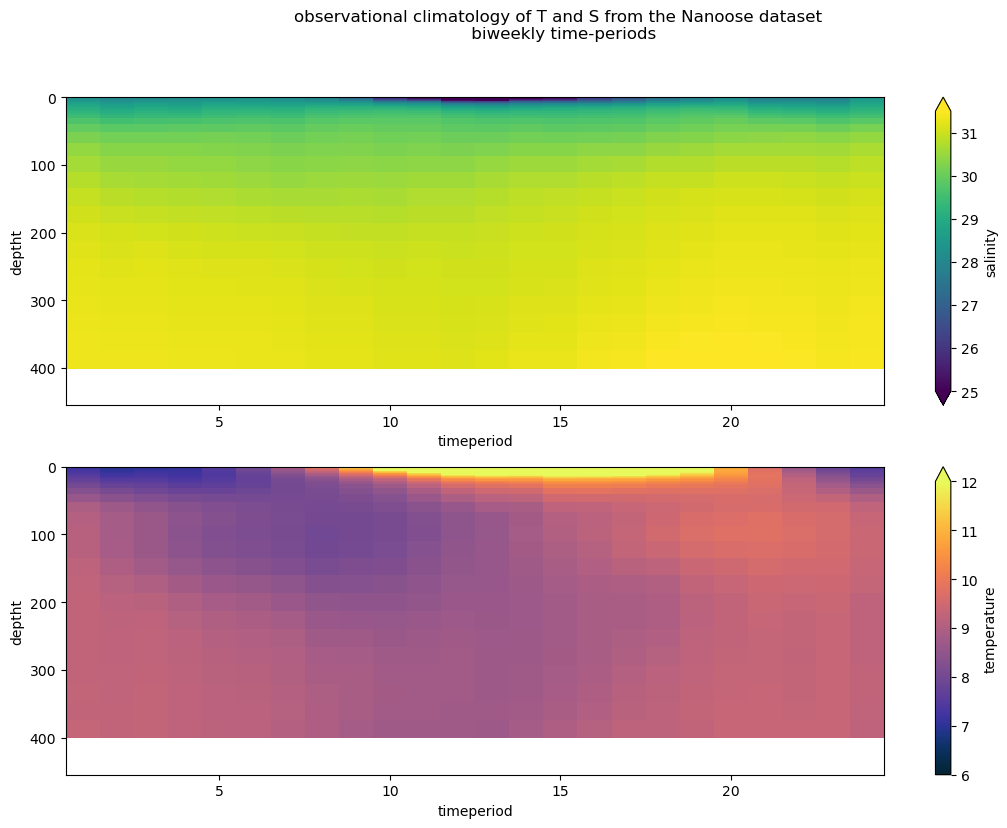

In [77]:
q = ds.salinity.groupby(ds.timeperiod).mean().T

fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

salt_clim = ds.salinity.groupby(ds.timeperiod).mean().T
xr.plot.pcolormesh(salt_clim, ax = axs[0], vmin = 25, vmax = 31.5)

temp_clim = ds.temperature.groupby(ds.timeperiod).mean().T
xr.plot.pcolormesh(temp_clim, ax = axs[1], cmap = cm.cm.thermal, vmin = 6, vmax = 12)

axs[0].invert_yaxis()
axs[1].invert_yaxis()

fig.suptitle('observational climatology of T and S from the Nanoose dataset \n biweekly time-periods')



In [70]:
tdt = np.array(['1970-01-07', '1970-01-23','1970-02-07', '1970-02-23',
'1970-03-07', '1970-03-23','1970-04-07', '1970-04-23',
'1970-05-07', '1970-05-23','1970-06-07', '1970-06-23',
'1970-07-07', '1970-07-23','1970-08-07', '1970-08-23',
'1970-09-07', '1970-09-23','1970-10-07', '1970-10-23',
'1970-11-07', '1970-11-23','1970-12-07', '1970-12-23',
'1971-01-07', '1971-01-23','1971-02-07', '1971-02-23',
'1971-03-07', '1971-03-23','1971-04-07', '1971-04-23',
'1971-05-07', '1971-05-23','1971-06-07', '1971-06-23',
'1971-07-07', '1971-07-23','1971-08-07', '1971-08-23',
'1971-09-07', '1971-09-23','1971-10-07', '1971-10-23',
'1971-11-07', '1971-11-23','1971-12-07', '1971-12-23',
'1972-01-07', '1972-01-23','1972-02-07', '1972-02-23',
'1972-03-07', '1972-03-23','1972-04-07', '1972-04-23',
'1972-05-07', '1972-05-23','1972-06-07', '1972-06-23',
'1972-07-07', '1972-07-23','1972-08-07', '1972-08-23',
'1972-09-07', '1972-09-23','1972-10-07', '1972-10-23',
'1972-11-07', '1972-11-23','1972-12-07', '1972-12-23',
'1973-01-07', '1973-01-23','1973-02-07', '1973-02-23',
'1973-03-07', '1973-03-23','1973-04-07', '1973-04-23',
'1973-05-07', '1973-05-23','1973-06-07', '1973-06-23',
'1973-07-07', '1973-07-23','1973-08-07', '1973-08-23',
'1973-09-07', '1973-09-23','1973-10-07', '1973-10-23',
'1973-11-07', '1973-11-23','1973-12-07', '1973-12-23',
'1974-01-07', '1974-01-23','1974-02-07', '1974-02-23',
'1974-03-07', '1974-03-23','1974-04-07', '1974-04-23',
'1974-05-07', '1974-05-23','1974-06-07', '1974-06-23',
'1974-07-07', '1974-07-23','1974-08-07', '1974-08-23',
'1974-09-07', '1974-09-23','1974-10-07', '1974-10-23',
'1974-11-07', '1974-11-23','1974-12-07', '1974-12-23',
'1975-01-07', '1975-01-23','1975-02-07', '1975-02-23',
'1975-03-07', '1975-03-23','1975-04-07', '1975-04-23',
'1975-05-07', '1975-05-23','1975-06-07', '1975-06-23',
'1975-07-07', '1975-07-23','1975-08-07', '1975-08-23',
'1975-09-07', '1975-09-23','1975-10-07', '1975-10-23',
'1975-11-07', '1975-11-23','1975-12-07', '1975-12-23',
'1976-01-07', '1976-01-23','1976-02-07', '1976-02-23',
'1976-03-07', '1976-03-23','1976-04-07', '1976-04-23',
'1976-05-07', '1976-05-23','1976-06-07', '1976-06-23',
'1976-07-07', '1976-07-23','1976-08-07', '1976-08-23',
'1976-09-07', '1976-09-23','1976-10-07', '1976-10-23',
'1976-11-07', '1976-11-23','1976-12-07', '1976-12-23',
'1977-01-07', '1977-01-23','1977-02-07', '1977-02-23',
'1977-03-07', '1977-03-23','1977-04-07', '1977-04-23',
'1977-05-07', '1977-05-23','1977-06-07', '1977-06-23',
'1977-07-07', '1977-07-23','1977-08-07', '1977-08-23',
'1977-09-07', '1977-09-23','1977-10-07', '1977-10-23',
'1977-11-07', '1977-11-23','1977-12-07', '1977-12-23',
'1978-01-07', '1978-01-23','1978-02-07', '1978-02-23',
'1978-03-07', '1978-03-23','1978-04-07', '1978-04-23',
'1978-05-07', '1978-05-23','1978-06-07', '1978-06-23',
'1978-07-07', '1978-07-23','1978-08-07', '1978-08-23',
'1978-09-07', '1978-09-23','1978-10-07', '1978-10-23',
'1978-11-07', '1978-11-23','1978-12-07', '1978-12-23',
'1979-01-07', '1979-01-23','1979-02-07', '1979-02-23',
'1979-03-07', '1979-03-23','1979-04-07', '1979-04-23',
'1979-05-07', '1979-05-23','1979-06-07', '1979-06-23',
'1979-07-07', '1979-07-23','1979-08-07', '1979-08-23',
'1979-09-07', '1979-09-23','1979-10-07', '1979-10-23',
'1979-11-07', '1979-11-23','1979-12-07', '1979-12-23',
'1980-01-07', '1980-01-23','1980-02-07', '1980-02-23',
'1980-03-07', '1980-03-23','1980-04-07', '1980-04-23',
'1980-05-07', '1980-05-23','1980-06-07', '1980-06-23',
'1980-07-07', '1980-07-23','1980-08-07', '1980-08-23',
'1980-09-07', '1980-09-23','1980-10-07', '1980-10-23',
'1980-11-07', '1980-11-23','1980-12-07', '1980-12-23',
'1981-01-07', '1981-01-23','1981-02-07', '1981-02-23',
'1981-03-07', '1981-03-23','1981-04-07', '1981-04-23',
'1981-05-07', '1981-05-23','1981-06-07', '1981-06-23',
'1981-07-07', '1981-07-23','1981-08-07', '1981-08-23',
'1981-09-07', '1981-09-23','1981-10-07', '1981-10-23',
'1981-11-07', '1981-11-23','1981-12-07', '1981-12-23',
'1982-01-07', '1982-01-23','1982-02-07', '1982-02-23',
'1982-03-07', '1982-03-23','1982-04-07', '1982-04-23',
'1982-05-07', '1982-05-23','1982-06-07', '1982-06-23',
'1982-07-07', '1982-07-23','1982-08-07', '1982-08-23',
'1982-09-07', '1982-09-23','1982-10-07', '1982-10-23',
'1982-11-07', '1982-11-23','1982-12-07', '1982-12-23',
'1983-01-07', '1983-01-23','1983-02-07', '1983-02-23',
'1983-03-07', '1983-03-23','1983-04-07', '1983-04-23',
'1983-05-07', '1983-05-23','1983-06-07', '1983-06-23',
'1983-07-07', '1983-07-23','1983-08-07', '1983-08-23',
'1983-09-07', '1983-09-23','1983-10-07', '1983-10-23',
'1983-11-07', '1983-11-23','1983-12-07', '1983-12-23',
'1984-01-07', '1984-01-23','1984-02-07', '1984-02-23',
'1984-03-07', '1984-03-23','1984-04-07', '1984-04-23',
'1984-05-07', '1984-05-23','1984-06-07', '1984-06-23',
'1984-07-07', '1984-07-23','1984-08-07', '1984-08-23',
'1984-09-07', '1984-09-23','1984-10-07', '1984-10-23',
'1984-11-07', '1984-11-23','1984-12-07', '1984-12-23',
'1985-01-07', '1985-01-23','1985-02-07', '1985-02-23',
'1985-03-07', '1985-03-23','1985-04-07', '1985-04-23',
'1985-05-07', '1985-05-23','1985-06-07', '1985-06-23',
'1985-07-07', '1985-07-23','1985-08-07', '1985-08-23',
'1985-09-07', '1985-09-23','1985-10-07', '1985-10-23',
'1985-11-07', '1985-11-23','1985-12-07', '1985-12-23',
'1986-01-07', '1986-01-23','1986-02-07', '1986-02-23',
'1986-03-07', '1986-03-23','1986-04-07', '1986-04-23',
'1986-05-07', '1986-05-23','1986-06-07', '1986-06-23',
'1986-07-07', '1986-07-23','1986-08-07', '1986-08-23',
'1986-09-07', '1986-09-23','1986-10-07', '1986-10-23',
'1986-11-07', '1986-11-23','1986-12-07', '1986-12-23',
'1987-01-07', '1987-01-23','1987-02-07', '1987-02-23',
'1987-03-07', '1987-03-23','1987-04-07', '1987-04-23',
'1987-05-07', '1987-05-23','1987-06-07', '1987-06-23',
'1987-07-07', '1987-07-23','1987-08-07', '1987-08-23',
'1987-09-07', '1987-09-23','1987-10-07', '1987-10-23',
'1987-11-07', '1987-11-23','1987-12-07', '1987-12-23',
'1988-01-07', '1988-01-23','1988-02-07', '1988-02-23',
'1988-03-07', '1988-03-23','1988-04-07', '1988-04-23',
'1988-05-07', '1988-05-23','1988-06-07', '1988-06-23',
'1988-07-07', '1988-07-23','1988-08-07', '1988-08-23',
'1988-09-07', '1988-09-23','1988-10-07', '1988-10-23',
'1988-11-07', '1988-11-23','1988-12-07', '1988-12-23',
'1989-01-07', '1989-01-23','1989-02-07', '1989-02-23',
'1989-03-07', '1989-03-23','1989-04-07', '1989-04-23',
'1989-05-07', '1989-05-23','1989-06-07', '1989-06-23',
'1989-07-07', '1989-07-23','1989-08-07', '1989-08-23',
'1989-09-07', '1989-09-23','1989-10-07', '1989-10-23',
'1989-11-07', '1989-11-23','1989-12-07', '1989-12-23',
'1990-01-07', '1990-01-23','1990-02-07', '1990-02-23',
'1990-03-07', '1990-03-23','1990-04-07', '1990-04-23',
'1990-05-07', '1990-05-23','1990-06-07', '1990-06-23',
'1990-07-07', '1990-07-23','1990-08-07', '1990-08-23',
'1990-09-07', '1990-09-23','1990-10-07', '1990-10-23',
'1990-11-07', '1990-11-23','1990-12-07', '1990-12-23',
'1991-01-07', '1991-01-23','1991-02-07', '1991-02-23',
'1991-03-07', '1991-03-23','1991-04-07', '1991-04-23',
'1991-05-07', '1991-05-23','1991-06-07', '1991-06-23',
'1991-07-07', '1991-07-23','1991-08-07', '1991-08-23',
'1991-09-07', '1991-09-23','1991-10-07', '1991-10-23',
'1991-11-07', '1991-11-23','1991-12-07', '1991-12-23',
'1992-01-07', '1992-01-23','1992-02-07', '1992-02-23',
'1992-03-07', '1992-03-23','1992-04-07', '1992-04-23',
'1992-05-07', '1992-05-23','1992-06-07', '1992-06-23',
'1992-07-07', '1992-07-23','1992-08-07', '1992-08-23',
'1992-09-07', '1992-09-23','1992-10-07', '1992-10-23',
'1992-11-07', '1992-11-23','1992-12-07', '1992-12-23',
'1993-01-07', '1993-01-23','1993-02-07', '1993-02-23',
'1993-03-07', '1993-03-23','1993-04-07', '1993-04-23',
'1993-05-07', '1993-05-23','1993-06-07', '1993-06-23',
'1993-07-07', '1993-07-23','1993-08-07', '1993-08-23',
'1993-09-07', '1993-09-23','1993-10-07', '1993-10-23',
'1993-11-07', '1993-11-23','1993-12-07', '1993-12-23',
'1994-01-07', '1994-01-23','1994-02-07', '1994-02-23',
'1994-03-07', '1994-03-23','1994-04-07', '1994-04-23',
'1994-05-07', '1994-05-23','1994-06-07', '1994-06-23',
'1994-07-07', '1994-07-23','1994-08-07', '1994-08-23',
'1994-09-07', '1994-09-23','1994-10-07', '1994-10-23',
'1994-11-07', '1994-11-23','1994-12-07', '1994-12-23',
'1995-01-07', '1995-01-23','1995-02-07', '1995-02-23',
'1995-03-07', '1995-03-23','1995-04-07', '1995-04-23',
'1995-05-07', '1995-05-23','1995-06-07', '1995-06-23',
'1995-07-07', '1995-07-23','1995-08-07', '1995-08-23',
'1995-09-07', '1995-09-23','1995-10-07', '1995-10-23',
'1995-11-07', '1995-11-23','1995-12-07', '1995-12-23',
'1996-01-07', '1996-01-23','1996-02-07', '1996-02-23',
'1996-03-07', '1996-03-23','1996-04-07', '1996-04-23',
'1996-05-07', '1996-05-23','1996-06-07', '1996-06-23',
'1996-07-07', '1996-07-23','1996-08-07', '1996-08-23',
'1996-09-07', '1996-09-23','1996-10-07', '1996-10-23',
'1996-11-07', '1996-11-23','1996-12-07', '1996-12-23',
'1997-01-07', '1997-01-23','1997-02-07', '1997-02-23',
'1997-03-07', '1997-03-23','1997-04-07', '1997-04-23',
'1997-05-07', '1997-05-23','1997-06-07', '1997-06-23',
'1997-07-07', '1997-07-23','1997-08-07', '1997-08-23',
'1997-09-07', '1997-09-23','1997-10-07', '1997-10-23',
'1997-11-07', '1997-11-23','1997-12-07', '1997-12-23',
'1998-01-07', '1998-01-23','1998-02-07', '1998-02-23',
'1998-03-07', '1998-03-23','1998-04-07', '1998-04-23',
'1998-05-07', '1998-05-23','1998-06-07', '1998-06-23',
'1998-07-07', '1998-07-23','1998-08-07', '1998-08-23',
'1998-09-07', '1998-09-23','1998-10-07', '1998-10-23',
'1998-11-07', '1998-11-23','1998-12-07', '1998-12-23',
'1999-01-07', '1999-01-23','1999-02-07', '1999-02-23',
'1999-03-07', '1999-03-23','1999-04-07', '1999-04-23',
'1999-05-07', '1999-05-23','1999-06-07', '1999-06-23',
'1999-07-07', '1999-07-23','1999-08-07', '1999-08-23',
'1999-09-07', '1999-09-23','1999-10-07', '1999-10-23',
'1999-11-07', '1999-11-23','1999-12-07', '1999-12-23',
'2000-01-07', '2000-01-23','2000-02-07', '2000-02-23',
'2000-03-07', '2000-03-23','2000-04-07', '2000-04-23',
'2000-05-07', '2000-05-23','2000-06-07', '2000-06-23',
'2000-07-07', '2000-07-23','2000-08-07', '2000-08-23',
'2000-09-07', '2000-09-23','2000-10-07', '2000-10-23',
'2000-11-07', '2000-11-23','2000-12-07', '2000-12-23',
'2001-01-07', '2001-01-23','2001-02-07', '2001-02-23',
'2001-03-07', '2001-03-23','2001-04-07', '2001-04-23',
'2001-05-07', '2001-05-23','2001-06-07', '2001-06-23',
'2001-07-07', '2001-07-23','2001-08-07', '2001-08-23',
'2001-09-07', '2001-09-23','2001-10-07', '2001-10-23',
'2001-11-07', '2001-11-23','2001-12-07', '2001-12-23',
'2002-01-07', '2002-01-23','2002-02-07', '2002-02-23',
'2002-03-07', '2002-03-23','2002-04-07', '2002-04-23',
'2002-05-07', '2002-05-23','2002-06-07', '2002-06-23',
'2002-07-07', '2002-07-23','2002-08-07', '2002-08-23',
'2002-09-07', '2002-09-23','2002-10-07', '2002-10-23',
'2002-11-07', '2002-11-23','2002-12-07', '2002-12-23',
'2003-01-07', '2003-01-23','2003-02-07', '2003-02-23',
'2003-03-07', '2003-03-23','2003-04-07', '2003-04-23',
'2003-05-07', '2003-05-23','2003-06-07', '2003-06-23',
'2003-07-07', '2003-07-23','2003-08-07', '2003-08-23',
'2003-09-07', '2003-09-23','2003-10-07', '2003-10-23',
'2003-11-07', '2003-11-23','2003-12-07', '2003-12-23',
'2004-01-07', '2004-01-23','2004-02-07', '2004-02-23',
'2004-03-07', '2004-03-23','2004-04-07', '2004-04-23',
'2004-05-07', '2004-05-23','2004-06-07', '2004-06-23',
'2004-07-07', '2004-07-23','2004-08-07', '2004-08-23',
'2004-09-07', '2004-09-23','2004-10-07', '2004-10-23',
'2004-11-07', '2004-11-23','2004-12-07', '2004-12-23',
'2005-01-07', '2005-01-23','2005-02-07', '2005-02-23',
'2005-03-07', '2005-03-23','2005-04-07', '2005-04-23',
'2005-05-07', '2005-05-23','2005-06-07', '2005-06-23',
'2005-07-07', '2005-07-23','2005-08-07', '2005-08-23',
'2005-09-07', '2005-09-23','2005-10-07', '2005-10-23',
'2005-11-07', '2005-11-23','2005-12-07', '2005-12-23',
'2006-01-07', '2006-01-23','2006-02-07', '2006-02-23',
'2006-03-07', '2006-03-23','2006-04-07', '2006-04-23',
'2006-05-07', '2006-05-23','2006-06-07', '2006-06-23',
'2006-07-07', '2006-07-23','2006-08-07', '2006-08-23',
'2006-09-07', '2006-09-23','2006-10-07', '2006-10-23',
'2006-11-07', '2006-11-23','2006-12-07', '2006-12-23',
'2007-01-07', '2007-01-23','2007-02-07', '2007-02-23',
'2007-03-07', '2007-03-23','2007-04-07', '2007-04-23',
'2007-05-07', '2007-05-23','2007-06-07', '2007-06-23',
'2007-07-07', '2007-07-23','2007-08-07', '2007-08-23',
'2007-09-07', '2007-09-23','2007-10-07', '2007-10-23',
'2007-11-07', '2007-11-23','2007-12-07', '2007-12-23',
'2008-01-07', '2008-01-23','2008-02-07', '2008-02-23',
'2008-03-07', '2008-03-23','2008-04-07', '2008-04-23',
'2008-05-07', '2008-05-23','2008-06-07', '2008-06-23',
'2008-07-07', '2008-07-23','2008-08-07', '2008-08-23',
'2008-09-07', '2008-09-23','2008-10-07', '2008-10-23',
'2008-11-07', '2008-11-23','2008-12-07', '2008-12-23',
'2009-01-07', '2009-01-23','2009-02-07', '2009-02-23',
'2009-03-07', '2009-03-23','2009-04-07', '2009-04-23',
'2009-05-07', '2009-05-23','2009-06-07', '2009-06-23',
'2009-07-07', '2009-07-23','2009-08-07', '2009-08-23',
'2009-09-07', '2009-09-23','2009-10-07', '2009-10-23',
'2009-11-07', '2009-11-23','2009-12-07', '2009-12-23',
'2010-01-07', '2010-01-23','2010-02-07', '2010-02-23',
'2010-03-07', '2010-03-23','2010-04-07', '2010-04-23',
'2010-05-07', '2010-05-23','2010-06-07', '2010-06-23',
'2010-07-07', '2010-07-23','2010-08-07', '2010-08-23',
'2010-09-07', '2010-09-23','2010-10-07', '2010-10-23',
'2010-11-07', '2010-11-23','2010-12-07', '2010-12-23',
'2011-01-07', '2011-01-23','2011-02-07', '2011-02-23',
'2011-03-07', '2011-03-23','2011-04-07', '2011-04-23',
'2011-05-07', '2011-05-23','2011-06-07', '2011-06-23',
'2011-07-07', '2011-07-23','2011-08-07', '2011-08-23',
'2011-09-07', '2011-09-23','2011-10-07', '2011-10-23',
'2011-11-07', '2011-11-23','2011-12-07', '2011-12-23',
'2012-01-07', '2012-01-23','2012-02-07', '2012-02-23',
'2012-03-07', '2012-03-23','2012-04-07', '2012-04-23',
'2012-05-07', '2012-05-23','2012-06-07', '2012-06-23',
'2012-07-07', '2012-07-23','2012-08-07', '2012-08-23',
'2012-09-07', '2012-09-23','2012-10-07', '2012-10-23',
'2012-11-07', '2012-11-23','2012-12-07', '2012-12-23',
'2013-01-07', '2013-01-23','2013-02-07', '2013-02-23',
'2013-03-07', '2013-03-23','2013-04-07', '2013-04-23',
'2013-05-07', '2013-05-23','2013-06-07', '2013-06-23',
'2013-07-07', '2013-07-23','2013-08-07', '2013-08-23',
'2013-09-07', '2013-09-23','2013-10-07', '2013-10-23',
'2013-11-07', '2013-11-23','2013-12-07', '2013-12-23',
'2014-01-07', '2014-01-23','2014-02-07', '2014-02-23',
'2014-03-07', '2014-03-23','2014-04-07', '2014-04-23',
'2014-05-07', '2014-05-23','2014-06-07', '2014-06-23',
'2014-07-07', '2014-07-23','2014-08-07', '2014-08-23',
'2014-09-07', '2014-09-23','2014-10-07', '2014-10-23',
'2014-11-07', '2014-11-23','2014-12-07', '2014-12-23',
'2015-01-07', '2015-01-23','2015-02-07', '2015-02-23',
'2015-03-07', '2015-03-23','2015-04-07', '2015-04-23',
'2015-05-07', '2015-05-23','2015-06-07', '2015-06-23',
'2015-07-07', '2015-07-23','2015-08-07', '2015-08-23',
'2015-09-07', '2015-09-23','2015-10-07', '2015-10-23',
'2015-11-07', '2015-11-23','2015-12-07', '2015-12-23',
'2016-01-07', '2016-01-23','2016-02-07', '2016-02-23',
'2016-03-07', '2016-03-23','2016-04-07', '2016-04-23',
'2016-05-07', '2016-05-23','2016-06-07', '2016-06-23',
'2016-07-07', '2016-07-23','2016-08-07', '2016-08-23',
'2016-09-07', '2016-09-23','2016-10-07', '2016-10-23',
'2016-11-07', '2016-11-23','2016-12-07', '2016-12-23',
'2017-01-07', '2017-01-23','2017-02-07', '2017-02-23',
'2017-03-07', '2017-03-23','2017-04-07', '2017-04-23',
'2017-05-07', '2017-05-23','2017-06-07', '2017-06-23',
'2017-07-07', '2017-07-23','2017-08-07', '2017-08-23',
'2017-09-07', '2017-09-23','2017-10-07', '2017-10-23',
'2017-11-07', '2017-11-23','2017-12-07', '2017-12-23',
'2018-01-07', '2018-01-23','2018-02-07', '2018-02-23',
'2018-03-07', '2018-03-23','2018-04-07', '2018-04-23',
'2018-05-07', '2018-05-23','2018-06-07', '2018-06-23',
'2018-07-07', '2018-07-23','2018-08-07', '2018-08-23',
'2018-09-07', '2018-09-23','2018-10-07', '2018-10-23',
'2018-11-07', '2018-11-23','2018-12-07', '2018-12-23',], dtype='datetime64')

In [ ]:
tdt.shape

In [71]:
make_bimonthly = True #don't run this analysis if you don't need to
if make_bimonthly:
    tperiod = ds.timeperiod.values
    timestamp = ds.time_counter.values
    dates_obs = pd.DatetimeIndex(timestamp)
    obs_yrs = np.array(dates_obs.year)

    salt = ds.salinity.values
    temp = ds.temperature.values

    salt_bimonth = np.zeros([1176,40]); salt_bimonth[:] = np.nan
    temp_bimonth = np.zeros([1176,40]); temp_bimonth[:] = np.nan
    this_timeperiod = np.zeros([1176])

    ind = 0
    for yr in range(1970,2019):
        for tp in range(1,25):
            filt = ((obs_yrs == yr) & (tperiod == tp))
            salt_bimonth[ind,:] = np.nanmean((salt[filt,:]), axis = 0)
            temp_bimonth[ind,:] = np.nanmean((temp[filt,:]), axis = 0)
            this_timeperiod[ind] = tp
            ind = ind+1


    savenam = 'ctd_ts_timeseries_bimonthly.nc'
    data_vars = {
        'salinity':(['time_counter', 'deptht'], salt_bimonth,
        {'units': 'psu',
        'long_name':'practical salinity'}),
        'temperature':(['time_counter', 'deptht'], temp_bimonth,
        {'units': 'deg C',
        'long_name':'in situ temperature'}),
        'timeperiod':(['time_counter'], this_timeperiod,
        {'units': '1-24, first jalf of jan is 1',
        'long_name':''}),             
        }

    # define coordinates
    coords = {'time_counter': (['time_counter'], tdt),
        'deptht': (['deptht'], modd_um)}
    # define global attributes
    attrs = {'made in':'NanooseObs/checkSampleData.ipynb',
    'desc': 'yearly medusa files, saving only variables of interest'
    }
    ds2 = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds2.to_netcdf(savenam)

C:\Users\Greig\AppData\Local\Temp\ipykernel_3024\455508096.py:19: RuntimeWarning: Mean of empty slice
  salt_bimonth[ind,:] = np.nanmean((salt[filt,:]), axis = 0)
C:\Users\Greig\AppData\Local\Temp\ipykernel_3024\455508096.py:20: RuntimeWarning: Mean of empty slice
  temp_bimonth[ind,:] = np.nanmean((temp[filt,:]), axis = 0)


Text(0.5, 0.98, 'observational timeseries, grouped into bimonthly (~15day) windows')

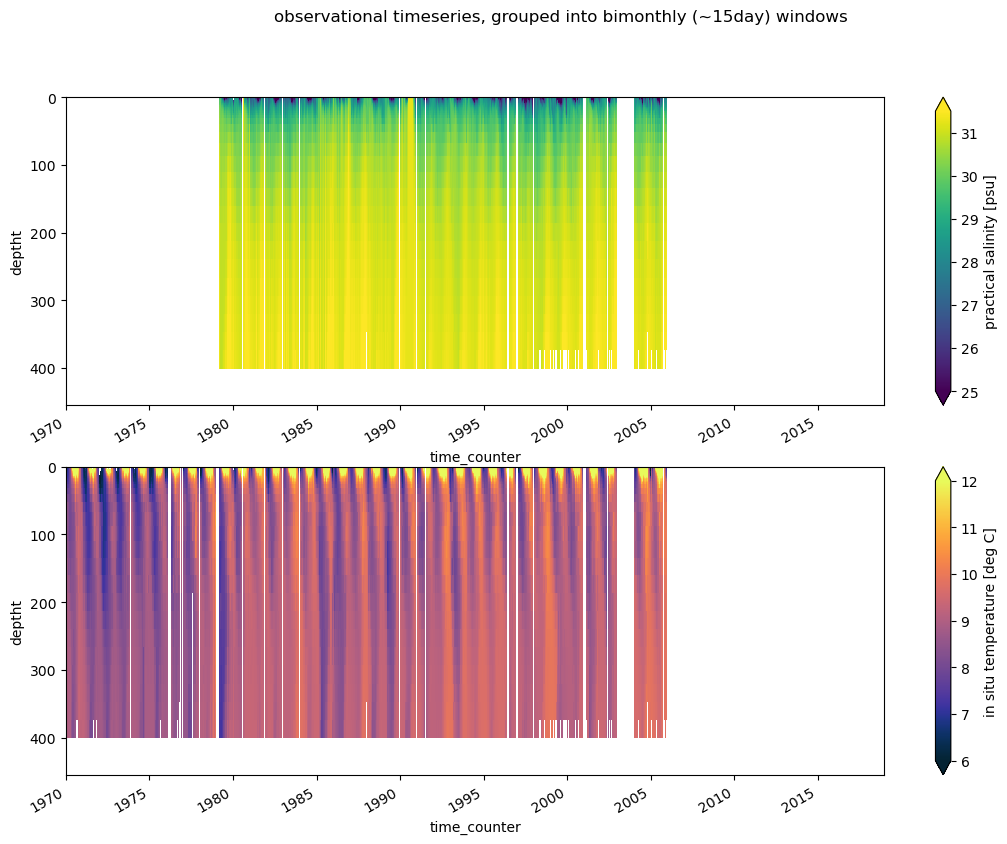

In [72]:
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

salt_bm = ds2.salinity.T
xr.plot.pcolormesh(salt_bm, ax = axs[0], vmin = 25, vmax = 31.5)

temp_bm = ds2.temperature.T
xr.plot.pcolormesh(temp_bm, ax = axs[1], cmap = cm.cm.thermal, vmin = 6, vmax = 12)

axs[0].invert_yaxis()
axs[1].invert_yaxis()

plt.suptitle('observational timeseries, grouped into bimonthly (~15day) windows')

Text(0.5, 0.98, 'observational climatology of T and S from the Nanoose dataset \n biweekly time-periods')

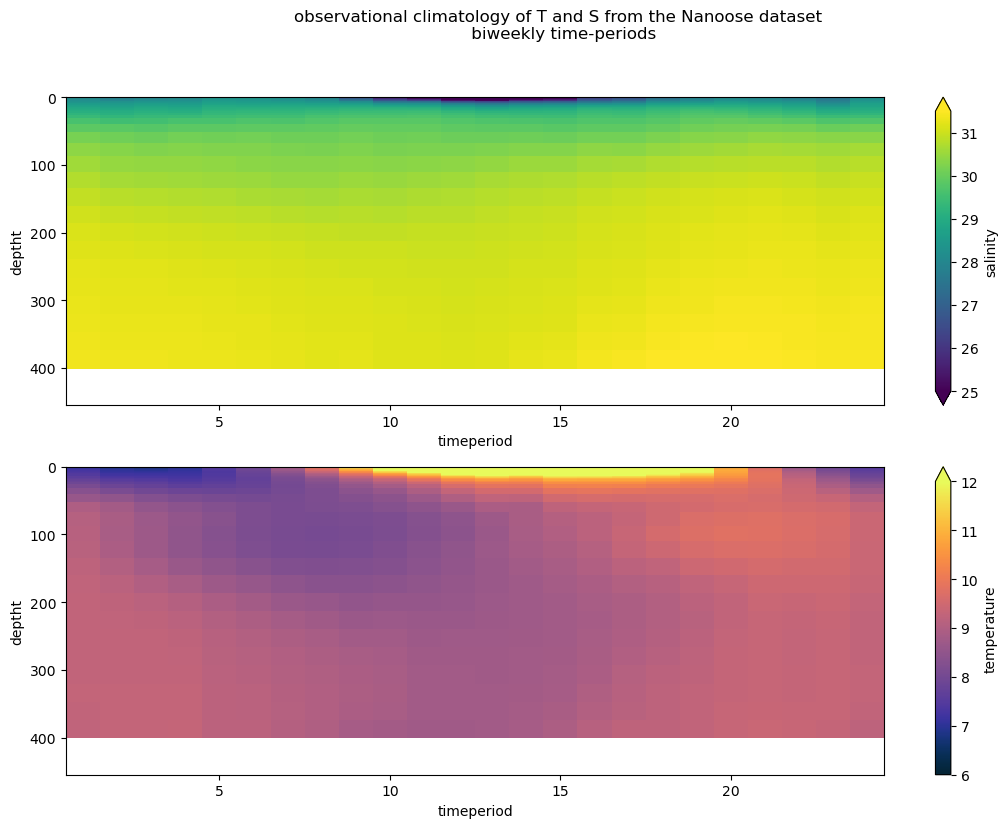

In [73]:
q = ds2.salinity.groupby(ds2.timeperiod).mean().T

fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

salt_clim = ds2.salinity.groupby(ds2.timeperiod).mean().T
xr.plot.pcolormesh(salt_clim, ax = axs[0], vmin = 25, vmax = 31.5)

temp_clim = ds2.temperature.groupby(ds2.timeperiod).mean().T
xr.plot.pcolormesh(temp_clim, ax = axs[1], cmap = cm.cm.thermal, vmin = 6, vmax = 12)

axs[0].invert_yaxis()
axs[1].invert_yaxis()

fig.suptitle('observational climatology of T and S from the Nanoose dataset \n biweekly time-periods')

In [74]:
saltts_minusclim = salt_bm.groupby(ds2.timeperiod)-salt_clim
tempts_minusclim = temp_bm.groupby(ds2.timeperiod)-temp_clim

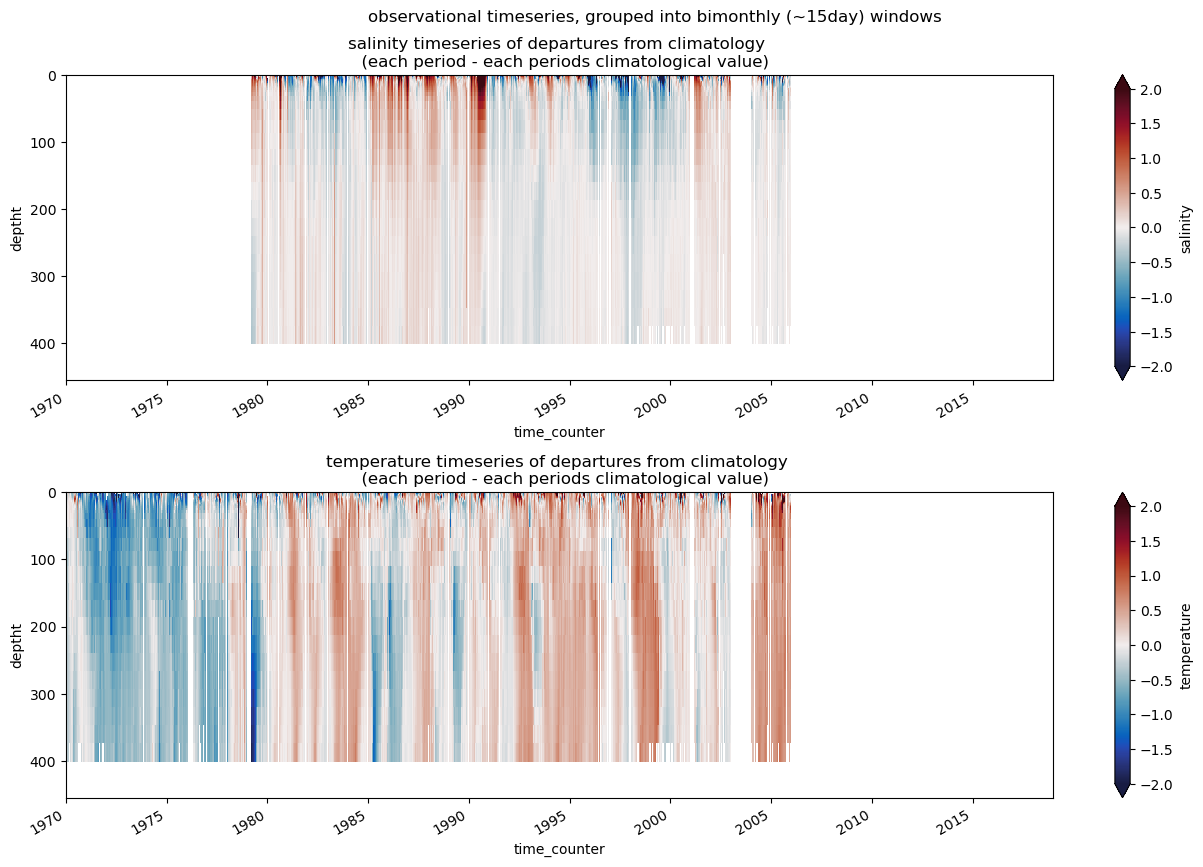

In [75]:
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

xr.plot.pcolormesh(saltts_minusclim, ax = axs[0], cmap = cm.cm.balance, vmin = -2, vmax = 2)

xr.plot.pcolormesh(tempts_minusclim, ax = axs[1], cmap = cm.cm.balance, vmin = -2, vmax = 2)

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[0].set_title('salinity timeseries of departures from climatology \n  (each period - each periods climatological value)')
axs[1].set_title('temperature timeseries of departures from climatology \n  (each period - each periods climatological value)')

plt.suptitle('observational timeseries, grouped into bimonthly (~15day) windows')
plt.tight_layout()

ValueError: x and y must have same first dimension, but have shapes (1176,) and (960,)

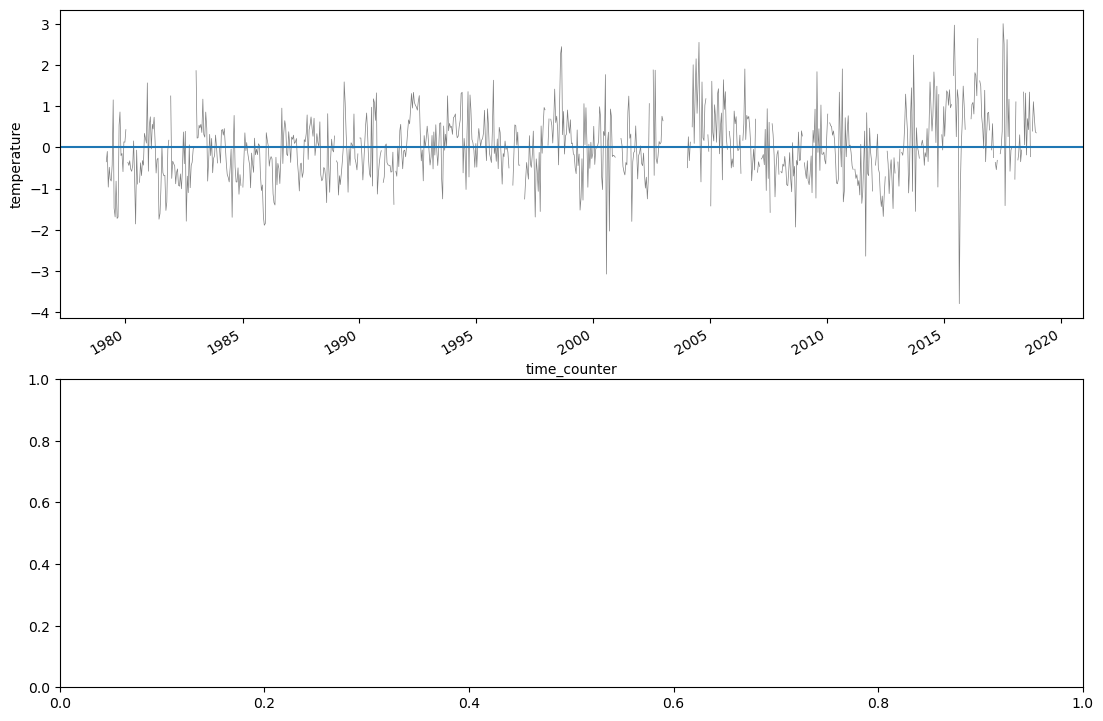

In [45]:
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

top10mtemp = tempts_minusclim.isel(deptht = tempts_minusclim.deptht <10.5).mean(dim = 'deptht')

top10mtemp.plot(ax = axs[0], color = 'k', linewidth = 0.5, alpha = 0.5)
axs[0].axhline(y=0)


## get it from datetimes to numbers to find trend in a per/year thing
tyr = np.arange(1970,2019,(1/24))
axs[1].plot(tyr,top10mtemp.values,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(top10mtemp.values)]
y = top10mtemp.values[~np.isnan(top10mtemp.values)]

A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
axs[1].plot(x, y, '.', label='Original data', markersize=2)
axs[1].plot(x, m*x + c, 'r', label=f'{m} deg/yr')
axs[1].legend(loc = 'best')
axs[1].axhline(y=0)

plt.suptitle('Nanoose Bay obs. temperatures, top 10 m of watercolumn, bimonthly sampled  \n (climatological seasonal cycle removed)')

ValueError: x and y must have same first dimension, but have shapes (1176,) and (960,)

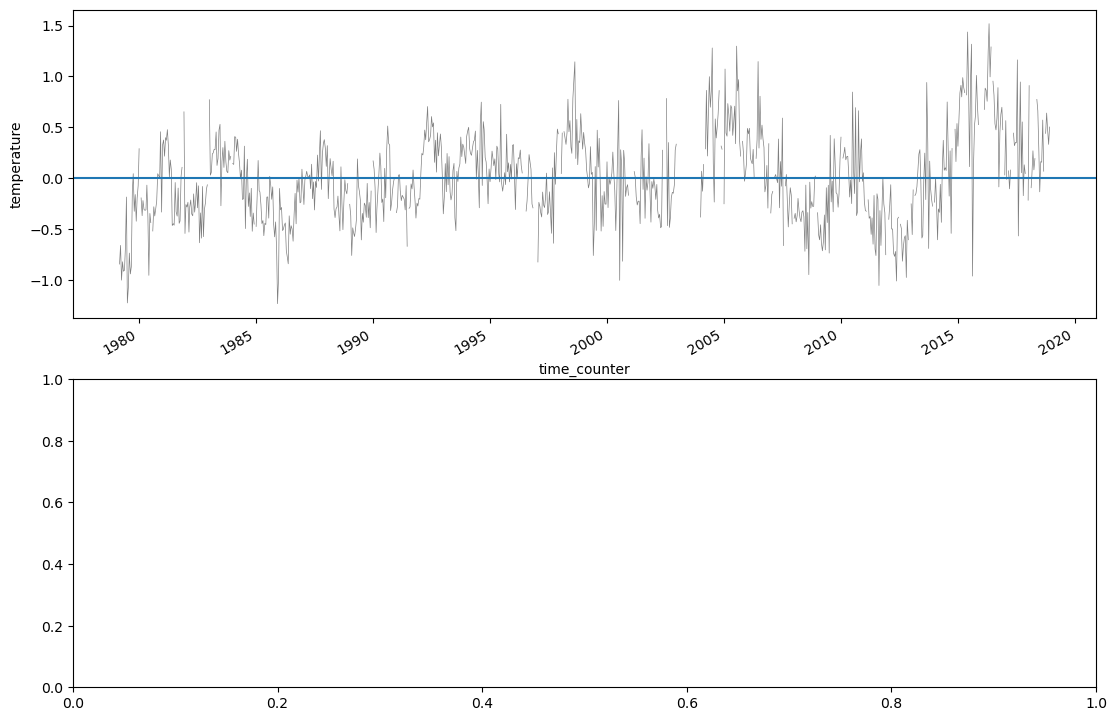

In [46]:
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

top400mtemp = tempts_minusclim.isel(deptht = tempts_minusclim.deptht <400).mean(dim = 'deptht')

top400mtemp.plot(ax = axs[0], color = 'k', linewidth = 0.5, alpha = 0.5)
axs[0].axhline(y=0)


## get it from datetimes to numbers to find trend in a per/year thing
tyr = np.arange(1970,2019,(1/24))
axs[1].plot(tyr,top400mtemp.values,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(top400mtemp.values)]
y = top400mtemp.values[~np.isnan(top400mtemp.values)]
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
axs[1].plot(x, y, '.', label='Original data', markersize=2)
axs[1].plot(x, m*x + c, 'r', label=f'{m} deg/yr')
axs[1].legend(loc = 'best')
axs[1].axhline(y=0)

plt.suptitle('Nanoose Bay obs. temperatures, top 400 m of watercolumn, bimonthly sampled  \n (climatological seasonal cycle removed)')

ValueError: x and y must have same first dimension, but have shapes (1176,) and (864,)

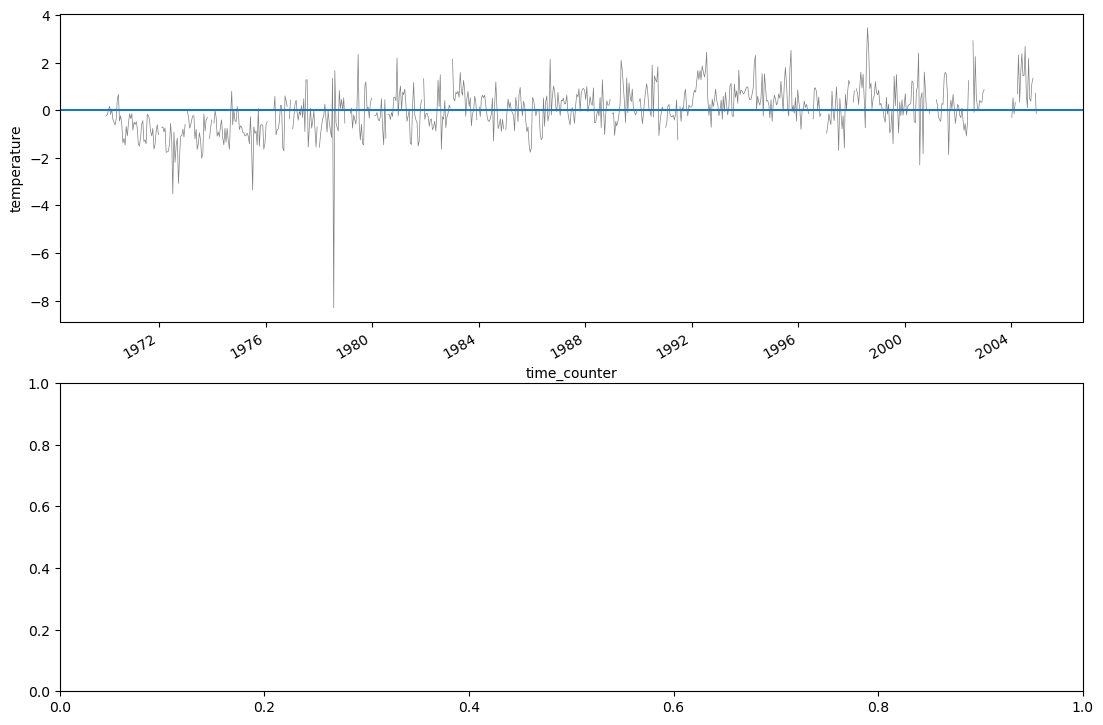

In [69]:
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

onelevel4pt5mtemp = tempts_minusclim.isel(deptht = ((tempts_minusclim.deptht > 4.500070) & (tempts_minusclim.deptht < 4.500072))).mean(dim = 'deptht')

onelevel4pt5mtemp.plot(ax = axs[0], color = 'k', linewidth = 0.5, alpha = 0.5)
axs[0].axhline(y=0)


## get it from datetimes to numbers to find trend in a per/year thing
tyr = np.arange(1970,2019,(1/24))
axs[1].plot(tyr,onelevel4pt5mtemp.values,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(onelevel4pt5mtemp.values)]
y = onelevel4pt5mtemp.values[~np.isnan(onelevel4pt5mtemp.values)]
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
axs[1].plot(x, y, '.', label='Original data', markersize=2)
axs[1].plot(x, m*x + c, 'r', label=f'{m} deg/yr')
axs[1].legend(loc = 'best')
axs[1].axhline(y=0)

plt.suptitle('Nanoose Bay obs. temperatures, at 4.5 m of watercolumn, bimonthly sampled  \n (climatological seasonal cycle removed)')

<xarray.DataArray 'deptht' ()>
array(4.50007057)
Coordinates:
    deptht   float64 4.5

In [80]:
onelevel4pt5mtemp = tempts_minusclim.isel(deptht = ((tempts_minusclim.deptht > 4.500070) & (tempts_minusclim.deptht < 4.500072))).mean(dim = 'deptht')

In [48]:
dates_obs = pd.DatetimeIndex(time_array)
obs_yrs = dates_obs.year; obs_months = dates_obs.month; obs_days = dates_obs.day

# print(dates[0])
# print(dates[-1])
dates_all = pd.date_range(start='1970-01-01', end= '2005-12-31', freq='D')

dates_yrs = dates_all.year; dates_months = dates_all.month; dates_days = dates_all.day

print(len(dates_all))
salt_ts = np.zeros([len(dates_all), 40]); salt_ts[:] = np.nan
temp_ts = np.zeros([len(dates_all), 40]); temp_ts[:] = np.nan

### retreive all measurements for a given day. they are given in size [1, x, 40] 
#so you need to take 0 in the first dimension
#not doing so was the error 

for i in range(0, len(dates_all)):
    find_obs = np.where((obs_yrs == dates_yrs[i]) & (obs_months == dates_months[i]) & (obs_days == dates_days[i]))
    if (len(dates_obs[find_obs])>0):
        available_salt = salt_array[find_obs,:]
        available_salt_toav = available_salt[0,:,:]
        salt_ts[i,:] = np.nanmean(available_salt_toav, axis = 0)
        available_temp = temp_array[find_obs,:]
        available_temp_toav = available_temp[0,:,:]
        temp_ts[i,:] = np.nanmean(available_temp_toav, axis = 0)

13149


C:\Users\Greig\AppData\Local\Temp\ipykernel_3024\1770909643.py:23: RuntimeWarning: Mean of empty slice
  salt_ts[i,:] = np.nanmean(available_salt_toav, axis = 0)
C:\Users\Greig\AppData\Local\Temp\ipykernel_3024\1770909643.py:26: RuntimeWarning: Mean of empty slice
  temp_ts[i,:] = np.nanmean(available_temp_toav, axis = 0)


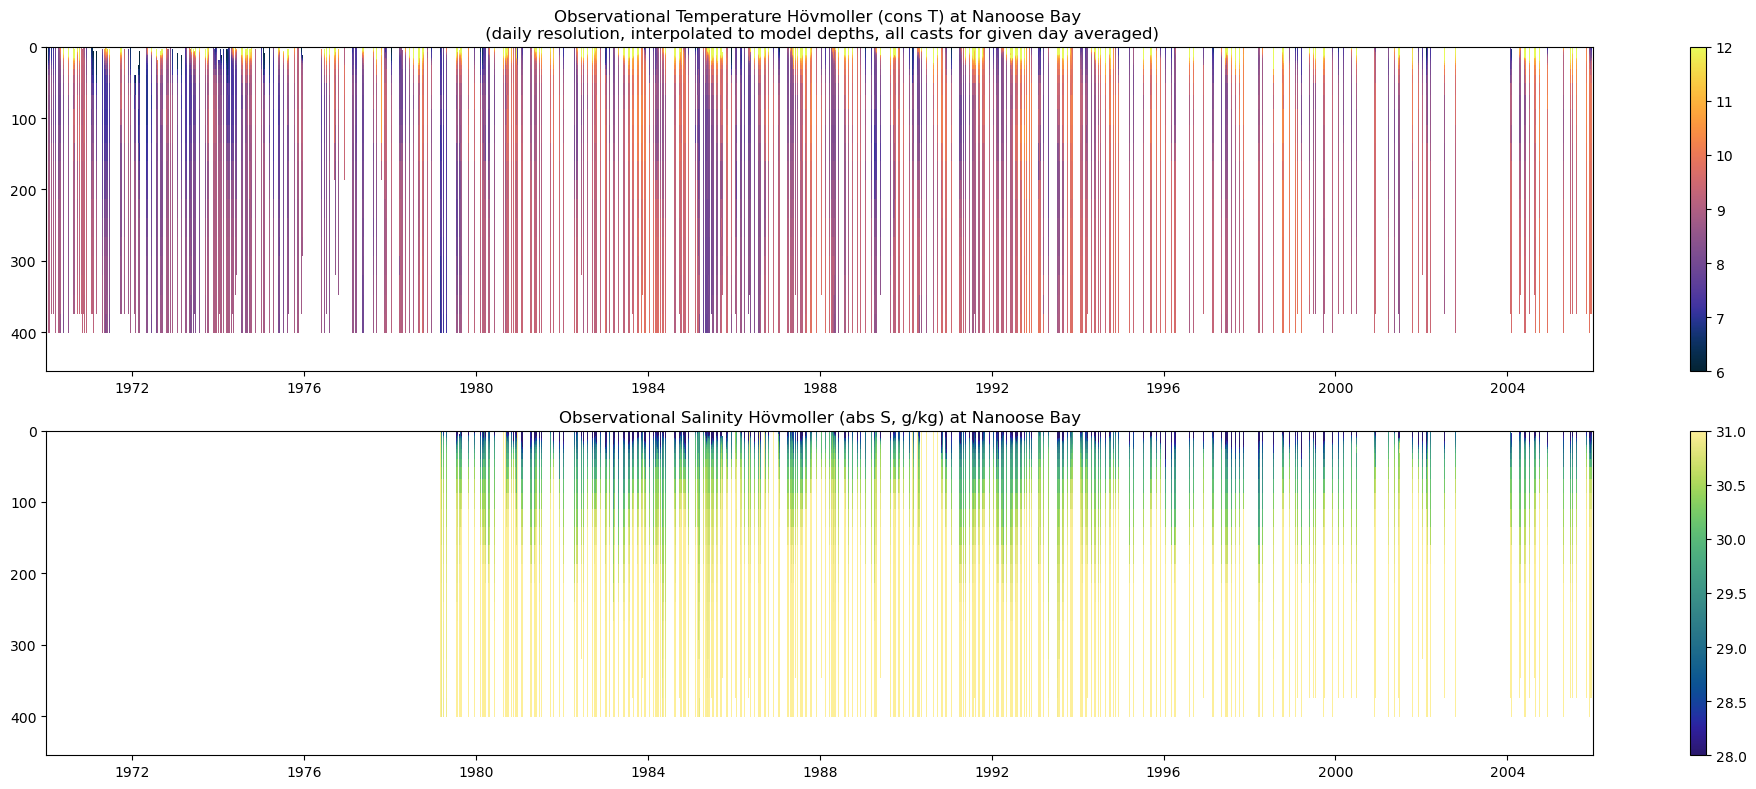

In [49]:
fig, axs = plt.subplots(2, 1, figsize = (20,8))
axs = axs.ravel()
temp_ts[temp_ts <-900] = np.nan
w = axs[0].pcolormesh(dates_all, modd_um, np.transpose(temp_ts), vmin=6, vmax=12, cmap = cm.cm.thermal)
plt.colorbar(w, ax = axs[0])
axs[0].invert_yaxis()

salt_ts[salt_ts <-900] = np.nan
w = axs[1].pcolormesh(dates_all, modd_um, np.transpose(salt_ts), vmin=28, vmax=31, cmap = cm.cm.haline)
plt.colorbar(w, ax = axs[1])
axs[1].invert_yaxis()
axs[0].set_title('Observational Temperature Hövmoller (cons T) at Nanoose Bay \n (daily resolution, interpolated to model depths, all casts for given day averaged)')
axs[1].set_title('Observational Salinity Hövmoller (abs S, g/kg) at Nanoose Bay')

plt.tight_layout()

In [50]:
tslen = (np.shape(temp_ts)[0])

def the_timepd(date):
    tpd = -99
    if ((date.month == 1) & (date.day <= 15)): tpd = 1
    if ((date.month == 1) & (date.day > 15)): tpd = 2   
    if ((date.month == 2) & (date.day <= 15)): tpd = 3
    if ((date.month == 2) & (date.day > 15)): tpd = 4
    if ((date.month == 3) & (date.day <= 15)): tpd = 5
    if ((date.month == 3) & (date.day > 15)): tpd = 6
    if ((date.month == 4) & (date.day <= 15)): tpd = 7
    if ((date.month == 4) & (date.day > 15)): tpd = 8   
    if ((date.month == 5) & (date.day <= 15)): tpd = 9
    if ((date.month == 5) & (date.day > 15)): tpd = 10
    if ((date.month == 6) & (date.day <= 15)): tpd = 11
    if ((date.month == 6) & (date.day > 15)): tpd = 12
    if ((date.month == 7) & (date.day <= 15)): tpd = 12+ 1
    if ((date.month == 7) & (date.day > 15)): tpd = 12+ 2   
    if ((date.month == 8) & (date.day <= 15)): tpd = 12+ 3
    if ((date.month == 8) & (date.day > 15)): tpd = 12+ 4
    if ((date.month == 9) & (date.day <= 15)): tpd = 12+ 5
    if ((date.month == 9) & (date.day > 15)): tpd = 12+ 6
    if ((date.month == 10) & (date.day <= 15)): tpd = 12+ 7
    if ((date.month == 10) & (date.day > 15)): tpd = 12+ 8   
    if ((date.month == 11) & (date.day <= 15)): tpd = 12+ 9
    if ((date.month == 11) & (date.day > 15)): tpd = 12+ 10
    if ((date.month == 12) & (date.day <= 15)): tpd = 12+ 11
    if ((date.month == 12) & (date.day > 15)): tpd = 12+ 12    
    
    return tpd

timeperiod = np.zeros(tslen).astype(int)
for i in range(0,len(timeperiod)):
    timeperiod[i] = int(the_timepd(dates_all[i]))

In [51]:
savenam = 'ctd_ts_timeseries.nc'
data_vars = {
    'salinity':(['time_counter', 'deptht'], salt_ts,
    {'units': 'psu',
    'long_name':'practical salinity'}),
    'temperature':(['time_counter', 'deptht'], temp_ts,
    {'units': 'deg C',
    'long_name':'in situ temperature'}),
    'timeperiod':(['time_counter'], timeperiod,
    {'units': '1-24, first jalf of jan is 1',
    'long_name':''}),             
    }

# define coordinates
coords = {'time_counter': (['time_counter'], dates_all),
    'deptht': (['deptht'], modd_um)}
# define global attributes
attrs = {'made in':'NanooseObs/checkSampleData.ipynb',
'desc': 'yearly medusa files, saving only variables of interest'
}
ds = xr.Dataset(data_vars=data_vars,
coords=coords,
attrs=attrs)
ds.to_netcdf(savenam)

Text(0.5, 0.98, 'observational climatology of T and S from the Nanoose dataset \n biweekly time-periods')

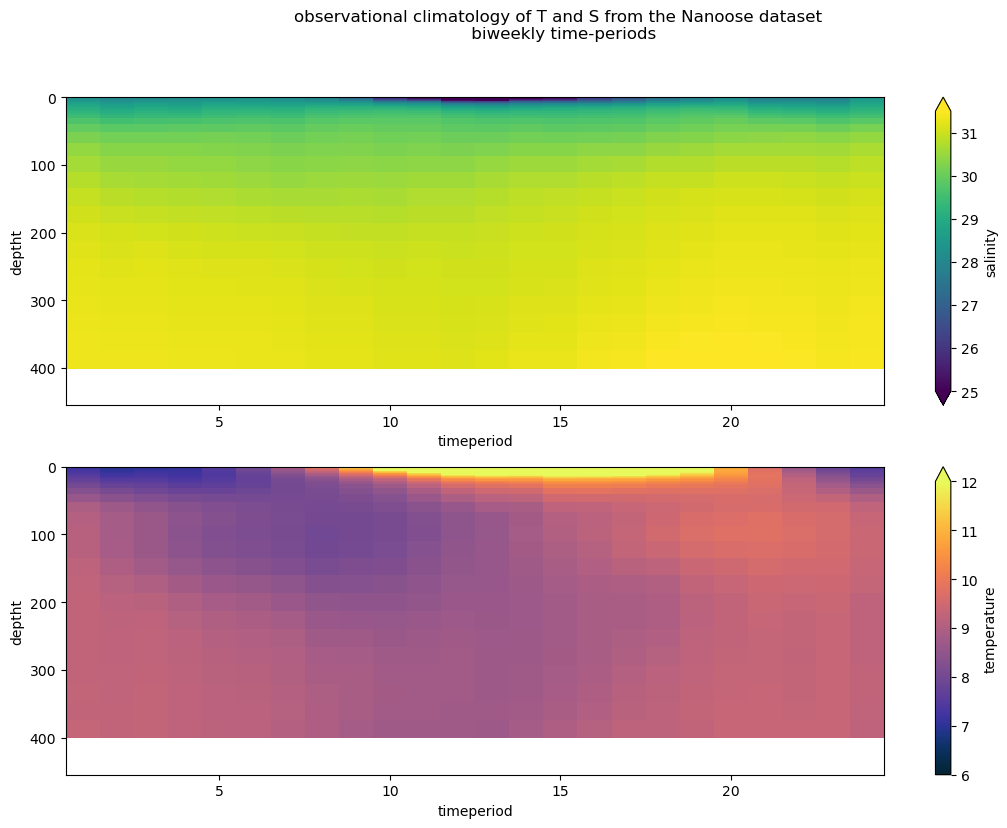

In [52]:
q = ds.salinity.groupby(ds.timeperiod).mean().T

fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

salt_clim = ds.salinity.groupby(ds.timeperiod).mean().T
xr.plot.pcolormesh(salt_clim, ax = axs[0], vmin = 25, vmax = 31.5)

temp_clim = ds.temperature.groupby(ds.timeperiod).mean().T
xr.plot.pcolormesh(temp_clim, ax = axs[1], cmap = cm.cm.thermal, vmin = 6, vmax = 12)

axs[0].invert_yaxis()
axs[1].invert_yaxis()

fig.suptitle('observational climatology of T and S from the Nanoose dataset \n biweekly time-periods')

In [53]:
tdt = np.array(['1970-01-07', '1970-01-23','1970-02-07', '1970-02-23',
'1970-03-07', '1970-03-23','1970-04-07', '1970-04-23',
'1970-05-07', '1970-05-23','1970-06-07', '1970-06-23',
'1970-07-07', '1970-07-23','1970-08-07', '1970-08-23',
'1970-09-07', '1970-09-23','1970-10-07', '1970-10-23',
'1970-11-07', '1970-11-23','1970-12-07', '1970-12-23',
'1971-01-07', '1971-01-23','1971-02-07', '1971-02-23',
'1971-03-07', '1971-03-23','1971-04-07', '1971-04-23',
'1971-05-07', '1971-05-23','1971-06-07', '1971-06-23',
'1971-07-07', '1971-07-23','1971-08-07', '1971-08-23',
'1971-09-07', '1971-09-23','1971-10-07', '1971-10-23',
'1971-11-07', '1971-11-23','1971-12-07', '1971-12-23',
'1972-01-07', '1972-01-23','1972-02-07', '1972-02-23',
'1972-03-07', '1972-03-23','1972-04-07', '1972-04-23',
'1972-05-07', '1972-05-23','1972-06-07', '1972-06-23',
'1972-07-07', '1972-07-23','1972-08-07', '1972-08-23',
'1972-09-07', '1972-09-23','1972-10-07', '1972-10-23',
'1972-11-07', '1972-11-23','1972-12-07', '1972-12-23',
'1973-01-07', '1973-01-23','1973-02-07', '1973-02-23',
'1973-03-07', '1973-03-23','1973-04-07', '1973-04-23',
'1973-05-07', '1973-05-23','1973-06-07', '1973-06-23',
'1973-07-07', '1973-07-23','1973-08-07', '1973-08-23',
'1973-09-07', '1973-09-23','1973-10-07', '1973-10-23',
'1973-11-07', '1973-11-23','1973-12-07', '1973-12-23',
'1974-01-07', '1974-01-23','1974-02-07', '1974-02-23',
'1974-03-07', '1974-03-23','1974-04-07', '1974-04-23',
'1974-05-07', '1974-05-23','1974-06-07', '1974-06-23',
'1974-07-07', '1974-07-23','1974-08-07', '1974-08-23',
'1974-09-07', '1974-09-23','1974-10-07', '1974-10-23',
'1974-11-07', '1974-11-23','1974-12-07', '1974-12-23',
'1975-01-07', '1975-01-23','1975-02-07', '1975-02-23',
'1975-03-07', '1975-03-23','1975-04-07', '1975-04-23',
'1975-05-07', '1975-05-23','1975-06-07', '1975-06-23',
'1975-07-07', '1975-07-23','1975-08-07', '1975-08-23',
'1975-09-07', '1975-09-23','1975-10-07', '1975-10-23',
'1975-11-07', '1975-11-23','1975-12-07', '1975-12-23',
'1976-01-07', '1976-01-23','1976-02-07', '1976-02-23',
'1976-03-07', '1976-03-23','1976-04-07', '1976-04-23',
'1976-05-07', '1976-05-23','1976-06-07', '1976-06-23',
'1976-07-07', '1976-07-23','1976-08-07', '1976-08-23',
'1976-09-07', '1976-09-23','1976-10-07', '1976-10-23',
'1976-11-07', '1976-11-23','1976-12-07', '1976-12-23',
'1977-01-07', '1977-01-23','1977-02-07', '1977-02-23',
'1977-03-07', '1977-03-23','1977-04-07', '1977-04-23',
'1977-05-07', '1977-05-23','1977-06-07', '1977-06-23',
'1977-07-07', '1977-07-23','1977-08-07', '1977-08-23',
'1977-09-07', '1977-09-23','1977-10-07', '1977-10-23',
'1977-11-07', '1977-11-23','1977-12-07', '1977-12-23',
'1978-01-07', '1978-01-23','1978-02-07', '1978-02-23',
'1978-03-07', '1978-03-23','1978-04-07', '1978-04-23',
'1978-05-07', '1978-05-23','1978-06-07', '1978-06-23',
'1978-07-07', '1978-07-23','1978-08-07', '1978-08-23',
'1978-09-07', '1978-09-23','1978-10-07', '1978-10-23',
'1978-11-07', '1978-11-23','1978-12-07', '1978-12-23',
'1979-01-07', '1979-01-23','1979-02-07', '1979-02-23',
'1979-03-07', '1979-03-23','1979-04-07', '1979-04-23',
'1979-05-07', '1979-05-23','1979-06-07', '1979-06-23',
'1979-07-07', '1979-07-23','1979-08-07', '1979-08-23',
'1979-09-07', '1979-09-23','1979-10-07', '1979-10-23',
'1979-11-07', '1979-11-23','1979-12-07', '1979-12-23',
'1980-01-07', '1980-01-23','1980-02-07', '1980-02-23',
'1980-03-07', '1980-03-23','1980-04-07', '1980-04-23',
'1980-05-07', '1980-05-23','1980-06-07', '1980-06-23',
'1980-07-07', '1980-07-23','1980-08-07', '1980-08-23',
'1980-09-07', '1980-09-23','1980-10-07', '1980-10-23',
'1980-11-07', '1980-11-23','1980-12-07', '1980-12-23',
'1981-01-07', '1981-01-23','1981-02-07', '1981-02-23',
'1981-03-07', '1981-03-23','1981-04-07', '1981-04-23',
'1981-05-07', '1981-05-23','1981-06-07', '1981-06-23',
'1981-07-07', '1981-07-23','1981-08-07', '1981-08-23',
'1981-09-07', '1981-09-23','1981-10-07', '1981-10-23',
'1981-11-07', '1981-11-23','1981-12-07', '1981-12-23',
'1982-01-07', '1982-01-23','1982-02-07', '1982-02-23',
'1982-03-07', '1982-03-23','1982-04-07', '1982-04-23',
'1982-05-07', '1982-05-23','1982-06-07', '1982-06-23',
'1982-07-07', '1982-07-23','1982-08-07', '1982-08-23',
'1982-09-07', '1982-09-23','1982-10-07', '1982-10-23',
'1982-11-07', '1982-11-23','1982-12-07', '1982-12-23',
'1983-01-07', '1983-01-23','1983-02-07', '1983-02-23',
'1983-03-07', '1983-03-23','1983-04-07', '1983-04-23',
'1983-05-07', '1983-05-23','1983-06-07', '1983-06-23',
'1983-07-07', '1983-07-23','1983-08-07', '1983-08-23',
'1983-09-07', '1983-09-23','1983-10-07', '1983-10-23',
'1983-11-07', '1983-11-23','1983-12-07', '1983-12-23',
'1984-01-07', '1984-01-23','1984-02-07', '1984-02-23',
'1984-03-07', '1984-03-23','1984-04-07', '1984-04-23',
'1984-05-07', '1984-05-23','1984-06-07', '1984-06-23',
'1984-07-07', '1984-07-23','1984-08-07', '1984-08-23',
'1984-09-07', '1984-09-23','1984-10-07', '1984-10-23',
'1984-11-07', '1984-11-23','1984-12-07', '1984-12-23',
'1985-01-07', '1985-01-23','1985-02-07', '1985-02-23',
'1985-03-07', '1985-03-23','1985-04-07', '1985-04-23',
'1985-05-07', '1985-05-23','1985-06-07', '1985-06-23',
'1985-07-07', '1985-07-23','1985-08-07', '1985-08-23',
'1985-09-07', '1985-09-23','1985-10-07', '1985-10-23',
'1985-11-07', '1985-11-23','1985-12-07', '1985-12-23',
'1986-01-07', '1986-01-23','1986-02-07', '1986-02-23',
'1986-03-07', '1986-03-23','1986-04-07', '1986-04-23',
'1986-05-07', '1986-05-23','1986-06-07', '1986-06-23',
'1986-07-07', '1986-07-23','1986-08-07', '1986-08-23',
'1986-09-07', '1986-09-23','1986-10-07', '1986-10-23',
'1986-11-07', '1986-11-23','1986-12-07', '1986-12-23',
'1987-01-07', '1987-01-23','1987-02-07', '1987-02-23',
'1987-03-07', '1987-03-23','1987-04-07', '1987-04-23',
'1987-05-07', '1987-05-23','1987-06-07', '1987-06-23',
'1987-07-07', '1987-07-23','1987-08-07', '1987-08-23',
'1987-09-07', '1987-09-23','1987-10-07', '1987-10-23',
'1987-11-07', '1987-11-23','1987-12-07', '1987-12-23',
'1988-01-07', '1988-01-23','1988-02-07', '1988-02-23',
'1988-03-07', '1988-03-23','1988-04-07', '1988-04-23',
'1988-05-07', '1988-05-23','1988-06-07', '1988-06-23',
'1988-07-07', '1988-07-23','1988-08-07', '1988-08-23',
'1988-09-07', '1988-09-23','1988-10-07', '1988-10-23',
'1988-11-07', '1988-11-23','1988-12-07', '1988-12-23',
'1989-01-07', '1989-01-23','1989-02-07', '1989-02-23',
'1989-03-07', '1989-03-23','1989-04-07', '1989-04-23',
'1989-05-07', '1989-05-23','1989-06-07', '1989-06-23',
'1989-07-07', '1989-07-23','1989-08-07', '1989-08-23',
'1989-09-07', '1989-09-23','1989-10-07', '1989-10-23',
'1989-11-07', '1989-11-23','1989-12-07', '1989-12-23',
'1990-01-07', '1990-01-23','1990-02-07', '1990-02-23',
'1990-03-07', '1990-03-23','1990-04-07', '1990-04-23',
'1990-05-07', '1990-05-23','1990-06-07', '1990-06-23',
'1990-07-07', '1990-07-23','1990-08-07', '1990-08-23',
'1990-09-07', '1990-09-23','1990-10-07', '1990-10-23',
'1990-11-07', '1990-11-23','1990-12-07', '1990-12-23',
'1991-01-07', '1991-01-23','1991-02-07', '1991-02-23',
'1991-03-07', '1991-03-23','1991-04-07', '1991-04-23',
'1991-05-07', '1991-05-23','1991-06-07', '1991-06-23',
'1991-07-07', '1991-07-23','1991-08-07', '1991-08-23',
'1991-09-07', '1991-09-23','1991-10-07', '1991-10-23',
'1991-11-07', '1991-11-23','1991-12-07', '1991-12-23',
'1992-01-07', '1992-01-23','1992-02-07', '1992-02-23',
'1992-03-07', '1992-03-23','1992-04-07', '1992-04-23',
'1992-05-07', '1992-05-23','1992-06-07', '1992-06-23',
'1992-07-07', '1992-07-23','1992-08-07', '1992-08-23',
'1992-09-07', '1992-09-23','1992-10-07', '1992-10-23',
'1992-11-07', '1992-11-23','1992-12-07', '1992-12-23',
'1993-01-07', '1993-01-23','1993-02-07', '1993-02-23',
'1993-03-07', '1993-03-23','1993-04-07', '1993-04-23',
'1993-05-07', '1993-05-23','1993-06-07', '1993-06-23',
'1993-07-07', '1993-07-23','1993-08-07', '1993-08-23',
'1993-09-07', '1993-09-23','1993-10-07', '1993-10-23',
'1993-11-07', '1993-11-23','1993-12-07', '1993-12-23',
'1994-01-07', '1994-01-23','1994-02-07', '1994-02-23',
'1994-03-07', '1994-03-23','1994-04-07', '1994-04-23',
'1994-05-07', '1994-05-23','1994-06-07', '1994-06-23',
'1994-07-07', '1994-07-23','1994-08-07', '1994-08-23',
'1994-09-07', '1994-09-23','1994-10-07', '1994-10-23',
'1994-11-07', '1994-11-23','1994-12-07', '1994-12-23',
'1995-01-07', '1995-01-23','1995-02-07', '1995-02-23',
'1995-03-07', '1995-03-23','1995-04-07', '1995-04-23',
'1995-05-07', '1995-05-23','1995-06-07', '1995-06-23',
'1995-07-07', '1995-07-23','1995-08-07', '1995-08-23',
'1995-09-07', '1995-09-23','1995-10-07', '1995-10-23',
'1995-11-07', '1995-11-23','1995-12-07', '1995-12-23',
'1996-01-07', '1996-01-23','1996-02-07', '1996-02-23',
'1996-03-07', '1996-03-23','1996-04-07', '1996-04-23',
'1996-05-07', '1996-05-23','1996-06-07', '1996-06-23',
'1996-07-07', '1996-07-23','1996-08-07', '1996-08-23',
'1996-09-07', '1996-09-23','1996-10-07', '1996-10-23',
'1996-11-07', '1996-11-23','1996-12-07', '1996-12-23',
'1997-01-07', '1997-01-23','1997-02-07', '1997-02-23',
'1997-03-07', '1997-03-23','1997-04-07', '1997-04-23',
'1997-05-07', '1997-05-23','1997-06-07', '1997-06-23',
'1997-07-07', '1997-07-23','1997-08-07', '1997-08-23',
'1997-09-07', '1997-09-23','1997-10-07', '1997-10-23',
'1997-11-07', '1997-11-23','1997-12-07', '1997-12-23',
'1998-01-07', '1998-01-23','1998-02-07', '1998-02-23',
'1998-03-07', '1998-03-23','1998-04-07', '1998-04-23',
'1998-05-07', '1998-05-23','1998-06-07', '1998-06-23',
'1998-07-07', '1998-07-23','1998-08-07', '1998-08-23',
'1998-09-07', '1998-09-23','1998-10-07', '1998-10-23',
'1998-11-07', '1998-11-23','1998-12-07', '1998-12-23',
'1999-01-07', '1999-01-23','1999-02-07', '1999-02-23',
'1999-03-07', '1999-03-23','1999-04-07', '1999-04-23',
'1999-05-07', '1999-05-23','1999-06-07', '1999-06-23',
'1999-07-07', '1999-07-23','1999-08-07', '1999-08-23',
'1999-09-07', '1999-09-23','1999-10-07', '1999-10-23',
'1999-11-07', '1999-11-23','1999-12-07', '1999-12-23',
'2000-01-07', '2000-01-23','2000-02-07', '2000-02-23',
'2000-03-07', '2000-03-23','2000-04-07', '2000-04-23',
'2000-05-07', '2000-05-23','2000-06-07', '2000-06-23',
'2000-07-07', '2000-07-23','2000-08-07', '2000-08-23',
'2000-09-07', '2000-09-23','2000-10-07', '2000-10-23',
'2000-11-07', '2000-11-23','2000-12-07', '2000-12-23',
'2001-01-07', '2001-01-23','2001-02-07', '2001-02-23',
'2001-03-07', '2001-03-23','2001-04-07', '2001-04-23',
'2001-05-07', '2001-05-23','2001-06-07', '2001-06-23',
'2001-07-07', '2001-07-23','2001-08-07', '2001-08-23',
'2001-09-07', '2001-09-23','2001-10-07', '2001-10-23',
'2001-11-07', '2001-11-23','2001-12-07', '2001-12-23',
'2002-01-07', '2002-01-23','2002-02-07', '2002-02-23',
'2002-03-07', '2002-03-23','2002-04-07', '2002-04-23',
'2002-05-07', '2002-05-23','2002-06-07', '2002-06-23',
'2002-07-07', '2002-07-23','2002-08-07', '2002-08-23',
'2002-09-07', '2002-09-23','2002-10-07', '2002-10-23',
'2002-11-07', '2002-11-23','2002-12-07', '2002-12-23',
'2003-01-07', '2003-01-23','2003-02-07', '2003-02-23',
'2003-03-07', '2003-03-23','2003-04-07', '2003-04-23',
'2003-05-07', '2003-05-23','2003-06-07', '2003-06-23',
'2003-07-07', '2003-07-23','2003-08-07', '2003-08-23',
'2003-09-07', '2003-09-23','2003-10-07', '2003-10-23',
'2003-11-07', '2003-11-23','2003-12-07', '2003-12-23',
'2004-01-07', '2004-01-23','2004-02-07', '2004-02-23',
'2004-03-07', '2004-03-23','2004-04-07', '2004-04-23',
'2004-05-07', '2004-05-23','2004-06-07', '2004-06-23',
'2004-07-07', '2004-07-23','2004-08-07', '2004-08-23',
'2004-09-07', '2004-09-23','2004-10-07', '2004-10-23',
'2004-11-07', '2004-11-23','2004-12-07', '2004-12-23',
'2005-01-07', '2005-01-23','2005-02-07', '2005-02-23',
'2005-03-07', '2005-03-23','2005-04-07', '2005-04-23',
'2005-05-07', '2005-05-23','2005-06-07', '2005-06-23',
'2005-07-07', '2005-07-23','2005-08-07', '2005-08-23',
'2005-09-07', '2005-09-23','2005-10-07', '2005-10-23',
'2005-11-07', '2005-11-23','2005-12-07', '2005-12-23',], dtype='datetime64')

In [20]:
tdt.shape

(864,)

In [54]:
make_bimonthly = True #don't run this analysis if you don't need to
if make_bimonthly:
    tperiod = ds.timeperiod.values
    timestamp = ds.time_counter.values
    dates_obs = pd.DatetimeIndex(timestamp)
    obs_yrs = np.array(dates_obs.year)

    salt = ds.salinity.values
    temp = ds.temperature.values

    salt_bimonth = np.zeros([864,40]); salt_bimonth[:] = np.nan
    temp_bimonth = np.zeros([864,40]); temp_bimonth[:] = np.nan
    this_timeperiod = np.zeros([864])

    ind = 0
    for yr in range(1970,2005):
        for tp in range(1,25):
            filt = ((obs_yrs == yr) & (tperiod == tp))
            salt_bimonth[ind,:] = np.nanmean((salt[filt,:]), axis = 0)
            temp_bimonth[ind,:] = np.nanmean((temp[filt,:]), axis = 0)
            this_timeperiod[ind] = tp
            ind = ind+1


    savenam = 'ctd_ts_timeseries_bimonthly.nc'
    data_vars = {
        'salinity':(['time_counter', 'deptht'], salt_bimonth,
        {'units': 'psu',
        'long_name':'practical salinity'}),
        'temperature':(['time_counter', 'deptht'], temp_bimonth,
        {'units': 'deg C',
        'long_name':'in situ temperature'}),
        'timeperiod':(['time_counter'], this_timeperiod,
        {'units': '1-24, first jalf of jan is 1',
        'long_name':''}),             
        }

    # define coordinates
    coords = {'time_counter': (['time_counter'], tdt),
        'deptht': (['deptht'], modd_um)}
    # define global attributes
    attrs = {'made in':'NanooseObs/checkSampleData.ipynb',
    'desc': 'yearly medusa files, saving only variables of interest'
    }
    ds2 = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds2.to_netcdf(savenam)

C:\Users\Greig\AppData\Local\Temp\ipykernel_3024\3150781519.py:19: RuntimeWarning: Mean of empty slice
  salt_bimonth[ind,:] = np.nanmean((salt[filt,:]), axis = 0)
C:\Users\Greig\AppData\Local\Temp\ipykernel_3024\3150781519.py:20: RuntimeWarning: Mean of empty slice
  temp_bimonth[ind,:] = np.nanmean((temp[filt,:]), axis = 0)


Text(0.5, 0.98, 'observational timeseries, grouped into bimonthly (~15day) windows')

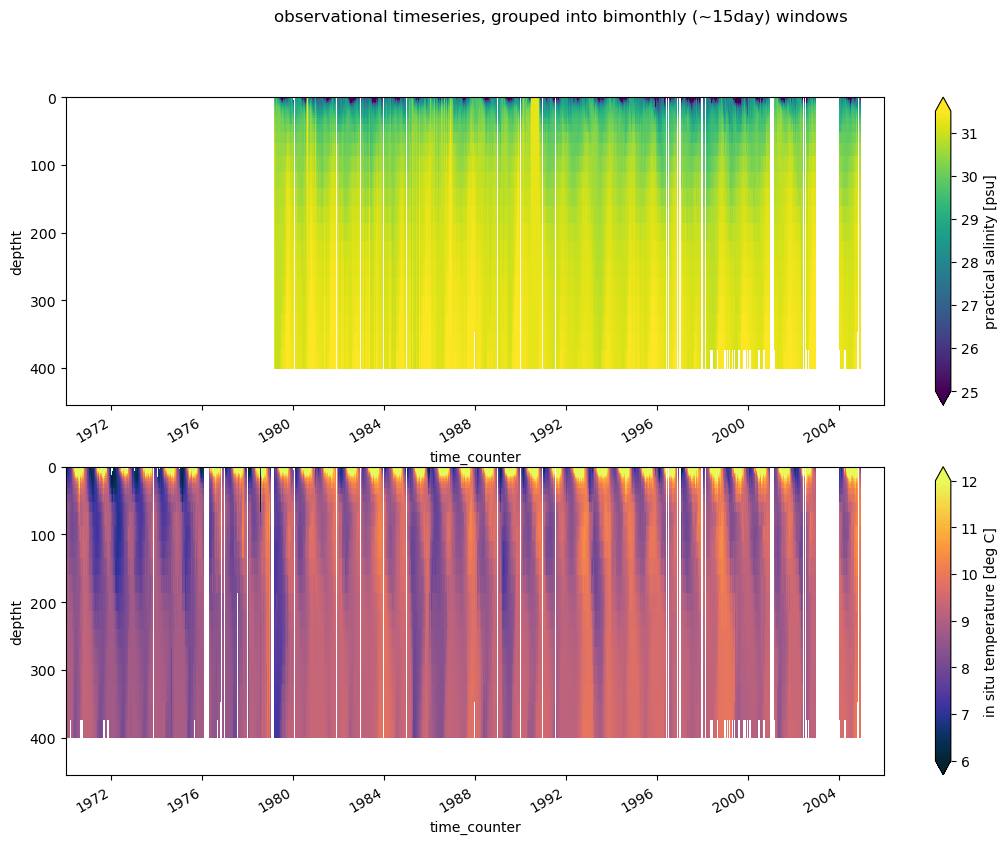

In [55]:
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

salt_bm = ds2.salinity.T
xr.plot.pcolormesh(salt_bm, ax = axs[0], vmin = 25, vmax = 31.5)

temp_bm = ds2.temperature.T
xr.plot.pcolormesh(temp_bm, ax = axs[1], cmap = cm.cm.thermal, vmin = 6, vmax = 12)

axs[0].invert_yaxis()
axs[1].invert_yaxis()

plt.suptitle('observational timeseries, grouped into bimonthly (~15day) windows')

Text(0.5, 0.98, 'observational climatology of T and S from the Nanoose dataset \n biweekly time-periods')

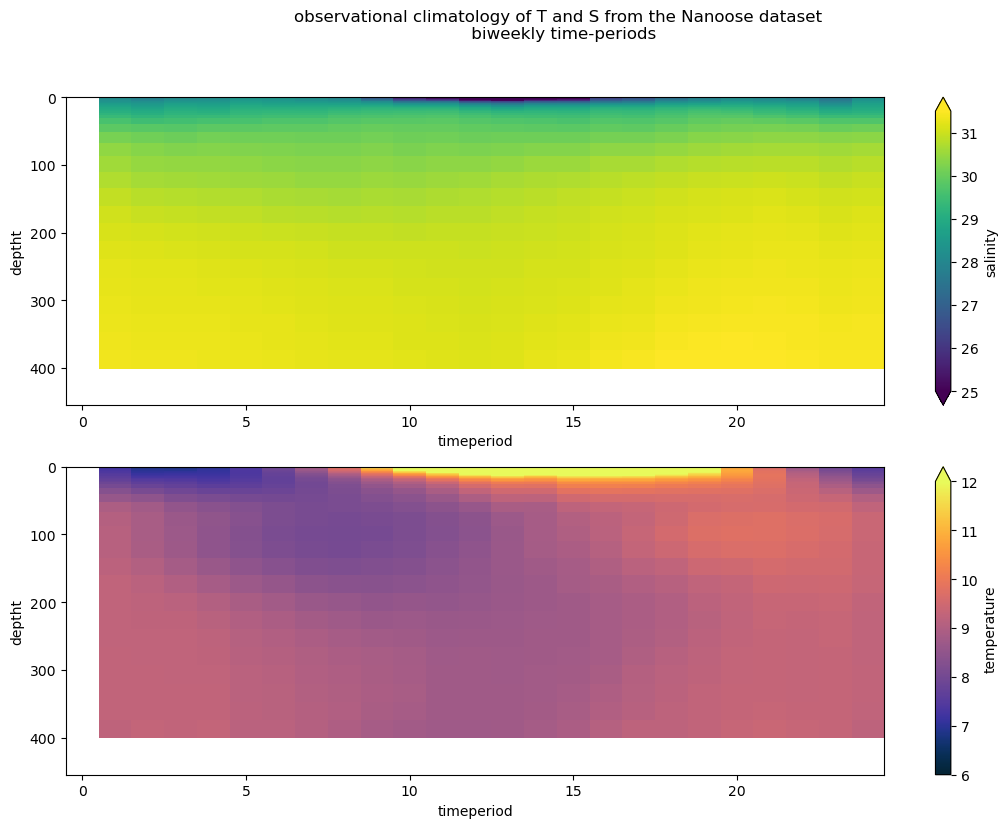

In [56]:
q = ds2.salinity.groupby(ds2.timeperiod).mean().T

fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

salt_clim = ds2.salinity.groupby(ds2.timeperiod).mean().T
xr.plot.pcolormesh(salt_clim, ax = axs[0], vmin = 25, vmax = 31.5)

temp_clim = ds2.temperature.groupby(ds2.timeperiod).mean().T
xr.plot.pcolormesh(temp_clim, ax = axs[1], cmap = cm.cm.thermal, vmin = 6, vmax = 12)

axs[0].invert_yaxis()
axs[1].invert_yaxis()

fig.suptitle('observational climatology of T and S from the Nanoose dataset \n biweekly time-periods')

In [57]:
saltts_minusclim = salt_bm.groupby(ds2.timeperiod)-salt_clim
tempts_minusclim = temp_bm.groupby(ds2.timeperiod)-temp_clim

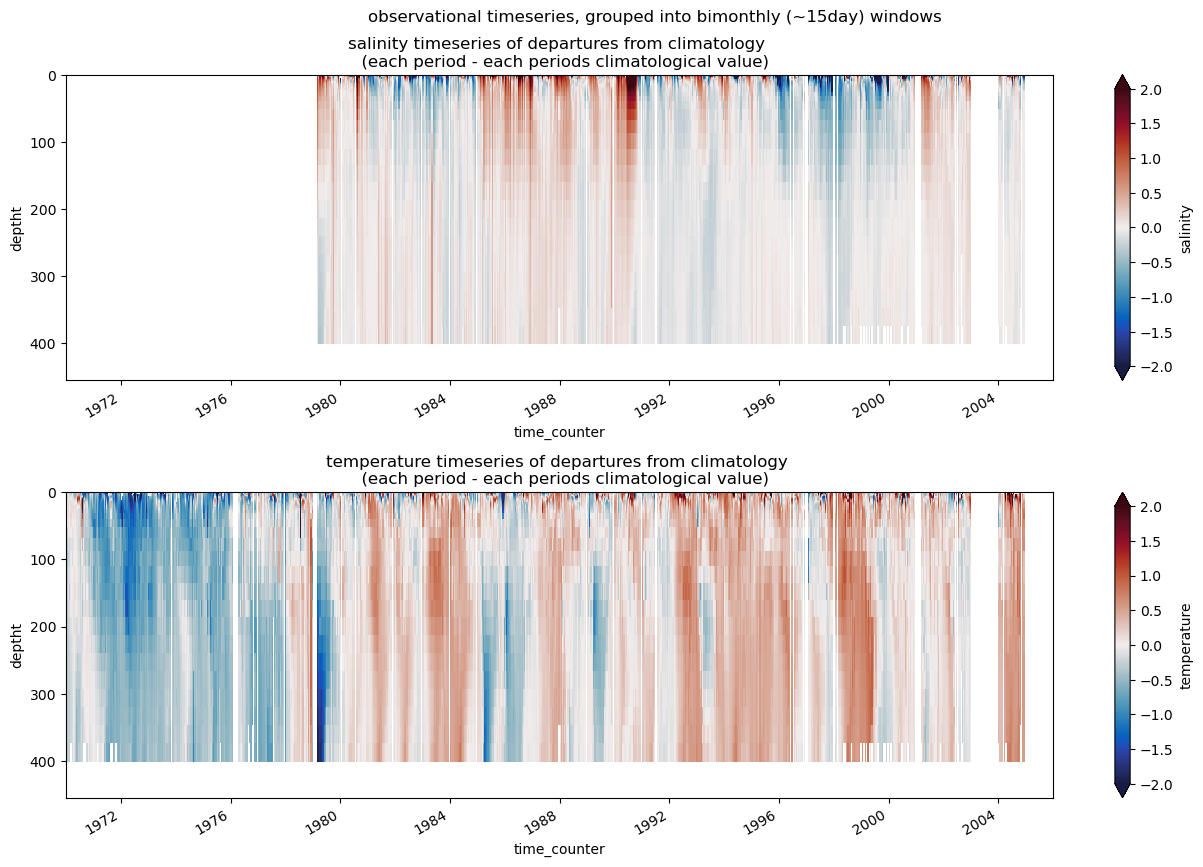

In [58]:
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

xr.plot.pcolormesh(saltts_minusclim, ax = axs[0], cmap = cm.cm.balance, vmin = -2, vmax = 2)

xr.plot.pcolormesh(tempts_minusclim, ax = axs[1], cmap = cm.cm.balance, vmin = -2, vmax = 2)

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[0].set_title('salinity timeseries of departures from climatology \n  (each period - each periods climatological value)')
axs[1].set_title('temperature timeseries of departures from climatology \n  (each period - each periods climatological value)')

plt.suptitle('observational timeseries, grouped into bimonthly (~15day) windows')
plt.tight_layout()

Text(0.5, 0.98, 'Nanoose Bay obs. temperatures, top 10 m of watercolumn, bimonthly sampled  \n (climatological seasonal cycle removed)')

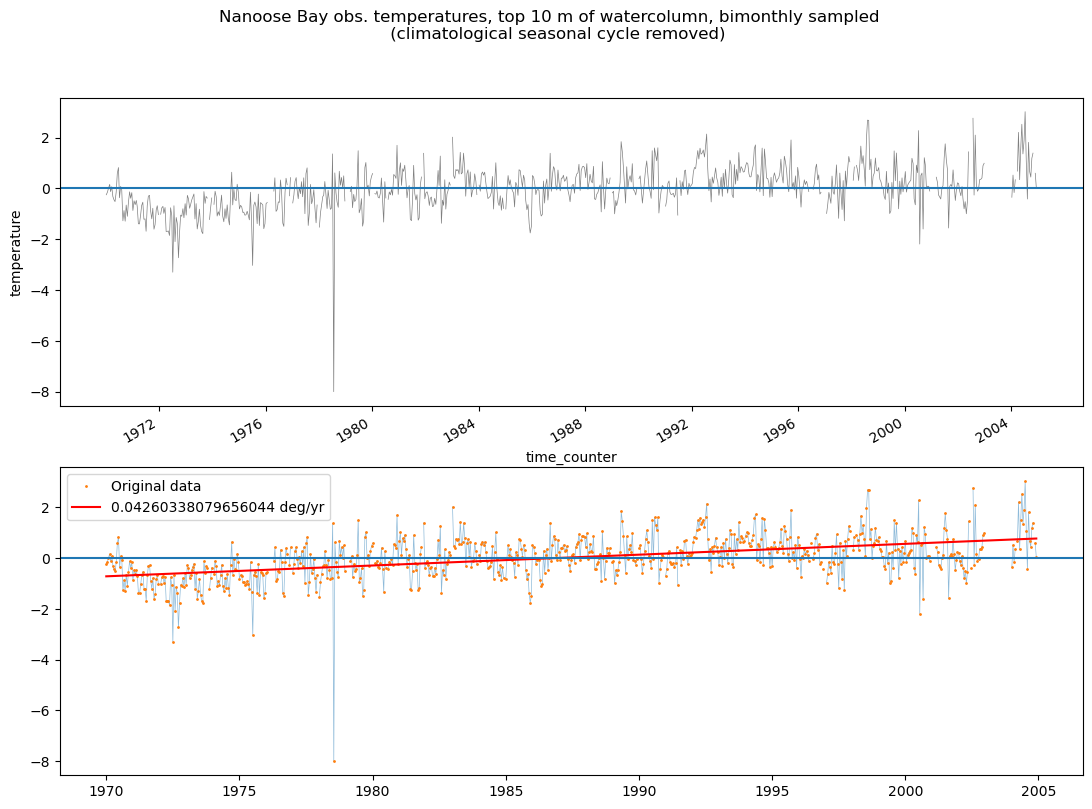

In [59]:
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

top10mtemp = tempts_minusclim.isel(deptht = tempts_minusclim.deptht <10.5).mean(dim = 'deptht')

top10mtemp.plot(ax = axs[0], color = 'k', linewidth = 0.5, alpha = 0.5)
axs[0].axhline(y=0)


## get it from datetimes to numbers to find trend in a per/year thing
tyr = np.arange(1970,2006,(1/24))
axs[1].plot(tyr,top10mtemp.values,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(top10mtemp.values)]
y = top10mtemp.values[~np.isnan(top10mtemp.values)]
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
axs[1].plot(x, y, '.', label='Original data', markersize=2)
axs[1].plot(x, m*x + c, 'r', label=f'{m} deg/yr')
axs[1].legend(loc = 'best')
axs[1].axhline(y=0)

plt.suptitle('Nanoose Bay obs. temperatures, top 10 m of watercolumn, bimonthly sampled  \n (climatological seasonal cycle removed)')

In [98]:
top10mtemp.shape

(864,)

In [100]:
tyr.shape

(840,)

Text(0.5, 0.98, 'Nanoose Bay obs. temperatures, at 4.5 m of watercolumn, bimonthly sampled  \n (climatological seasonal cycle removed)')

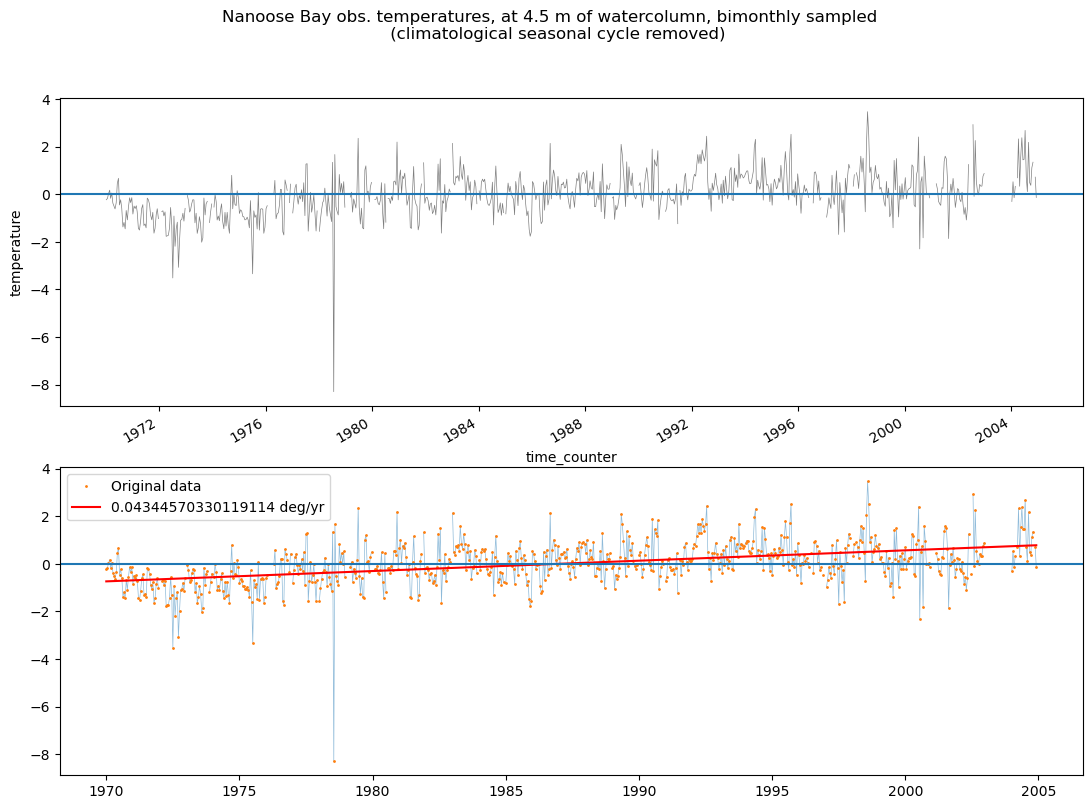

In [105]:
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

onelevel4pt5mtemp = tempts_minusclim.isel(deptht = ((tempts_minusclim.deptht > 4.500070) & (tempts_minusclim.deptht < 4.500072))).mean(dim = 'deptht')

onelevel4pt5mtemp.plot(ax = axs[0], color = 'k', linewidth = 0.5, alpha = 0.5)
axs[0].axhline(y=0)


## get it from datetimes to numbers to find trend in a per/year thing
tyr = np.arange(1970,2006,(1/24))
axs[1].plot(tyr,onelevel4pt5mtemp.values,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(onelevel4pt5mtemp.values)]
y = onelevel4pt5mtemp.values[~np.isnan(onelevel4pt5mtemp.values)]
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
axs[1].plot(x, y, '.', label='Original data', markersize=2)
axs[1].plot(x, m*x + c, 'r', label=f'{m} deg/yr')
axs[1].legend(loc = 'best')
axs[1].axhline(y=0)

plt.suptitle('Nanoose Bay obs. temperatures, at 4.5 m of watercolumn, bimonthly sampled  \n (climatological seasonal cycle removed)')

Text(0.5, 1.0, 'Nanoose Bay obs. temperatures, 4.5 - 400 m of watercolumn, bimonthly sampled  \n (climatological seasonal cycle removed)')

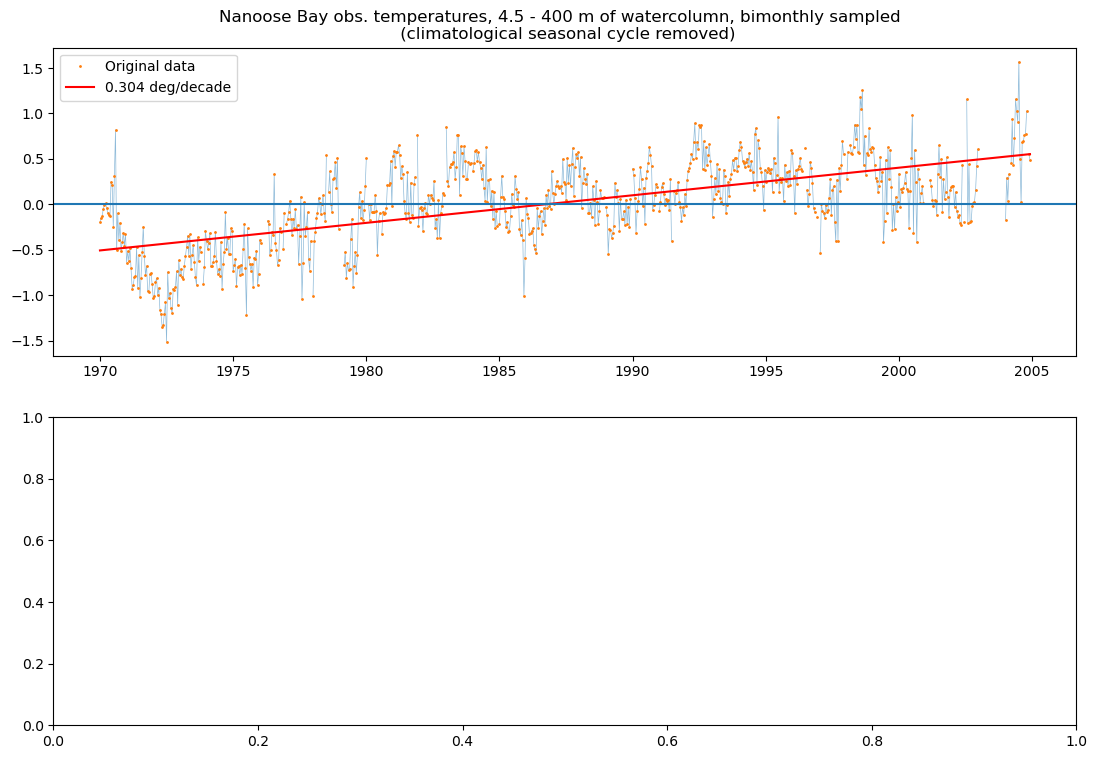

In [68]:
fig, axs = plt.subplots(2,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

fr4pt5mto400m = tempts_minusclim.isel(deptht = ((tempts_minusclim.deptht > 4.5)&(tempts_minusclim.deptht < 400))).mean(dim = 'deptht')
fr4pt5mto400m = fr4pt5mto400m.where(fr4pt5mto400m > -2)

## get it from datetimes to numbers to find trend in a per/year thing
tyr = np.arange(1970,2006,(1/24))
axs[0].plot(tyr,fr4pt5mto400m.values,linewidth = 0.5, alpha = 0.5)

x = tyr[~np.isnan(fr4pt5mto400m.values)]
y = fr4pt5mto400m.values[~np.isnan(fr4pt5mto400m.values)]
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
axs[0].plot(x, y, '.', label='Original data', markersize=2)
axs[0].plot(x, m*x + c, 'r', label=f'{round(m*10,3)} deg/decade')
axs[0].legend(loc = 'best')
axs[0].axhline(y=0)

axs[0].set_title('Nanoose Bay obs. temperatures, 4.5 - 400 m of watercolumn, bimonthly sampled  \n (climatological seasonal cycle removed)')
#fr4pt5mto400m.plot(ax = axs[1], color = 'k', linewidth = 0.5, alpha = 0.5)
#axs[1].axhline(y=0)




In [38]:
tempts_minusclim.where(tempts_minusclim > 0, 2)

<xarray.DataArray 'temperature' (deptht: 40, time_counter: 864)>
array([[0.31357061, 0.24217187, 0.22675397, ..., 2.        , 2.        ,
        2.        ],
       [2.        , 2.        , 0.04916164, ..., 2.        , 2.        ,
        2.        ],
       [2.        , 2.        , 0.05139592, ..., 2.        , 2.        ,
        2.        ],
       ...,
       [2.        , 2.        , 2.        , ..., 2.        , 2.        ,
        2.        ],
       [2.        , 2.        , 2.        , ..., 2.        , 2.        ,
        2.        ],
       [2.        , 2.        , 2.        , ..., 2.        , 2.        ,
        2.        ]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1970-01-07 ... 2005-12-23
  * deptht        (deptht) float64 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
    timeperiod    (time_counter) float64 1.0 2.0 3.0 4.0 5.0 ... 0.0 0.0 0.0 0.0